In [1]:
#//*** GEOPANDAS sources
#https://jcutrer.com/python/learn-geopandas-plotting-usmaps
#https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
#https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
#https://geopandas.org/docs/user_guide/mapping.html

#//*** Build Custom Color Gradients
#https://coolors.co/gradient-palette/ffffff-e0472b?number=9

#//*** pandas_bokeh
#//*** https://pythonawesome.com/bokeh-plotting-backend-for-pandas-and-geopandas/

#//*** Clean geopandas install
#//***conda create -n geopandas -c conda-forge python=3.8 geopandas

Hospitalization research:
Data.gov search for tag: hhs-covid-19

posible lead: https://healthdata.gov/dataset/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/4cnb-m4rz

possible lead individual facility breakdown by week May - October 2021: https://healthdata.gov/dataset/COVID-19-Hospital-Data-Coverage-Report-v4wn-auj8-A/ewep-8fwa

This look like State Level Data: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh

Data CSV Link: https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

Healthdata.gov Hospitalization Search: https://healthdata.gov/browse?q=hospitalization&sortBy=relevance

Hospital Facility TimeSeries: https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/anag-cw7u


Other Sources:
 - COVID-19 State and County Policy Orders (infographic?): https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders-9408a

<a id="top"></a> 
## Internal Links ##

- Working [working](#working).

- [Load/Rebuild County Level Combined Data Set: Vaccination, Cases, Deaths: rebuild county_daily_df](#rebuild_county_daily_df)

- [Load/Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths: rebuild state_daily_df](#rebuild_state_daily_df)

- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)

- [ Load or Rebuild County Level Vaccine Data Set: county_vax_df](#rebuild_county_vax_df)

- [ Build Vaccine Tiers: County Data: county_tier_df](#build_tiers_county)

- [Build Vaccine Tiers: Statewide Data](#build_tiers_statewide)

- [ Build: hospital_df ](#build_hospital_df)

- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

## Analyze ##
- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)

## Graphs ##



### CDC Community Transmission Guidelines

https://covid.cdc.gov/covid-data-tracker/#county-view



![](transmission_risk.png)

<a id="working"></a> 
# Working #

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random
from PIL import Image

import shutil
import json

import geopandas as gpd

import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

import pandas_bokeh
pandas_bokeh.output_notebook()

#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
#https://docs.bokeh.org/en/latest/docs/user_guide/embed.html

#//*** Bokeh Categorical Labels
#https://docs.bokeh.org/en/0.12.10/docs/user_guide/categorical.html

#//*** Color Palettes: https://docs.bokeh.org/en/latest/docs/reference/palettes.html
#//*** Hover Tools: https://docs.bokeh.org/en/latest/docs/user_guide/tools.html
from datetime import datetime
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.stats.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

#//*** Holds 
out_plot = {}
out_stats = {}
out_images = []
out_exec_summary_images = []

med_figsize_x =634
med_figsize_y = 512

#df_list = []

#from sklearn import linear_model
#from math import sqrt
#from sklearn.metrics import mean_squared_error



Loading BokehJS ...

In [3]:
#"https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

#Hospitalizations - State
#https://www.cdc.gov/nhsn/covid19/report-patient-impact.html#anchor_1594393649
#DL: https://www.cdc.gov/nhsn/pdfs/covid19/covid19-NatEst.csv

# File Control #
 * use_cached_files = True - Use the Locally cached versions of the data
 * use_cached_files = False - Download updated source Data
 
 * rebuild_master_files = True - Rebuild county_daily_df. Takes 5-10 minutes
 * rebuild_master_files = False - Uses the cached version of the files

In [4]:
#//************************************************************************
#//*** If True, will rely on locally stored files
#//*** If False, will Download current data and rebuild all data sets
#//*** Should only be set to False if Data needs to be updated
#//************************************************************************
use_cached_files = True
#rebuild_master_files = False

# Filepaths #

In [5]:
#//*** Raw Filenames
confirmed_data_filename = "z_us_confirmed.csv"
death_data_filename = "z_us_death_cases.csv"
vaccine_data_filename = "z_us_vaccination.csv"
county_vaccine_data_filename = "z_us_county_vaccination.csv.zip"
state_hospital_filename = "z_state_hospital.csv"

#//*** Filenames for Caching files locally
attrib_confirm_filename = "attrib_confirm_df.dat.zip"
attrib_death_filename =  "attrib_death_df.dat.zip"
all_dates_filename = "all_dates.json"
geo_vax_filename = "geo_vax_df.dat"
casevax_filename = "casevax.dat.zip"
county_daily_df_filename = "z_county_daily_df.csv.zip"
state_daily_df_filename = "z_state_daily_df.csv.zip"
hospital_df_filename = "z_hospital_df.csv.zip"

county_tier_df_filename = "z_county_tier_df.csv.zip"
whole_county_tier_df_filename = "z_whole_county_tier_df.csv.zip"

In [6]:




#CDC Data: https://catalog.data.gov/dataset/covid-19-vaccinations-in-the-united-statescounty

#//***********************************************************************************************
#//*** California COVID Data website:
#//**************************************
#//*** https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
#//***********************************************************************************************

#//*** Download California Current COVID Demograohic Data
if not use_cached_files:
    try:
        response = requests.get("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
        if response.ok:
            print("US Confirmed Data Downloaded")
            f = open(confirmed_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Confirmed Data Written to file.")
    except:
        print("US Confirmed Data: Trouble Downloading From Johns Hopkins Github")

    try:
        response = requests.get("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
        if response.ok:
            print("US Deaths Data Downloaded")
            f = open(death_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Death Data Written to file.")
    except:
        print("US Death Data: Trouble Downloading From Johns Hopkins Github")
        
    try:
        #response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        response = requests.get("https://data.cdc.gov/api/views/unsk-b7fc/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("Vaccination Data Downloading")
            f = open(vaccine_data_filename, "w")
            f.write(response.text)
            f.close()
            print("US Vaccination Data Written to file.")
    except:
        print("US Vaccine Data: Trouble Downloading From CDC")

    try:
        #//*** CDC Vaccination County Data
        #//*** Source: https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-County/8xkx-amqh
        response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("County Vaccination Data Downloading")
            #//*** Write CSV File
            f = open(county_vaccine_data_filename.replace(".zip",""), "w")
            f.write(response.text)
            f.close()

            #//*** File > 100 mb
            #//*** read the CSV into a Dataframe and pickle the file with compression
            pd.read_csv(county_vaccine_data_filename.replace(".zip","")).to_pickle(county_vaccine_data_filename)

            #//*** Delete the Original CSV File
            os.remove(county_vaccine_data_filename.replace(".zip",""))

            print("US County Vaccination Data Written to file.")
    except:
        print("US County Vaccine Data: Trouble Downloading From CDC")    

    #Hospitalizations - State
    #https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD

    try:
        #response = requests.get("https://data.cdc.gov/api/views/8xkx-amqh/rows.csv?accessType=DOWNLOAD")
        response = requests.get("https://healthdata.gov/api/views/g62h-syeh/rows.csv?accessType=DOWNLOAD")
        if response.ok:
            print("Hospitalization Data Downloading")
            f = open(state_hospital_filename, "w")
            f.write(response.text)
            f.close()
            print("US Hospitalization Data Written to file.")
    except:
        print("US Hospitalization: Trouble Downloading From Healthdata.gov")

#confirm_df = pd.read_csv(confirmed_data_filename, dtype={"FIPS":np.int32})


<a id="rebuild_county_daily_df"></a> 
# Load or Rebuild County Level Combined Data Set: Cases & Deaths #

In [7]:
#use_cached_files=False
if use_cached_files:
    print("Using Cached county_daily_df...")
    county_daily_df = pd.read_pickle(county_daily_df_filename)
else:
    print("Rebuilding county_daily_df...This will take a while.")
    """
    #//***************************************
    #//*** Build Vaccine Geographic Data
    #//***************************************
    print("Loading County Geopandas Shape File")
    #//*** Get Shape File
    county_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')


    #//*** Keep the important Columns
    county_df = county_df[['STATEFP','GEOID','NAME','geometry']]

    county_df['GEOID'] = county_df['GEOID'].astype(int)
    county_df['STATEFP'] = county_df['STATEFP'].astype(int)
    
    #print(counties['GEOID'].unique(),county_df['FIPS'].unique())
    
    
    #print("Merge Shape Data with Vaccine Data...")
    #county_df = counties.merge(county_df,left_on="GEOID",right_on="FIPS")

    #//*** Round the Vaccination Percentages
    #county_df["Series_Complete_Pop_Pct"] = county_df["Series_Complete_Pop_Pct"].round(1)
    #county_df["Administered_Dose1_Pop_Pct"] = county_df["Administered_Dose1_Pop_Pct"].round(1)

    #county_df['Date'] = county_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())


    
    #print("Dropping Duplicates...")
    #county_df = county_df.drop_duplicates()
    """
    
    #//****************************************************
    #//*** Prepare Confirmed Cases and Deaths For Merge
    #//****************************************************

    print("Loading Raw Confirm Cases Data....")
    confirm_df = pd.read_csv(confirmed_data_filename)

    confirm_df = confirm_df[confirm_df['Admin2'] != 'Unassigned']

    #//*** Convert Confirmed Date Columns to Date Objects
    cols = []
    confirm_date_cols = []
    for col in confirm_df.columns:
        if "/" not in col:
            cols.append(col)
        else:
            cols.append(datetime.strptime(col, "%m/%d/%y").date())
            confirm_date_cols.append(datetime.strptime(col, "%m/%d/%y").date())

    confirm_df.columns = cols

    print("Loading Raw Deaths Data....")

    death_df = pd.read_csv(death_data_filename)

    death_df

    death_df['Province_State'].unique()
    death_df = death_df[death_df['iso2'] =='US']
    death_df = death_df[death_df['Province_State'] != "Diamond Princess"]
    death_df = death_df[death_df['Province_State'] != "Grand Princess"]
    death_df = death_df[death_df['Admin2'] != 'Unassigned']
    death_df.dropna(inplace=True)
    death_df['FIPS'] = death_df['FIPS'].astype(int)


    #//*** Convert Confirmed Date Columns to Date Objects
    cols = []
    death_date_cols = []

    for col in death_df.columns:
        if "/" not in col:
            cols.append(col)
        else:
            cols.append(datetime.strptime(col, "%m/%d/%y").date())
            death_date_cols.append(datetime.strptime(col, "%m/%d/%y").date())

    death_df.columns = cols


    ##///**** REBUILD COUNTY_DAILY_DF - This takes a while 15ish Minutes


    #//*** Integrate Confirmed and Deaths with Vaccine Data. Build derived Values
    i = 0

    print("Begin Merge Confirm and Deaths Columns with Vaccination Rows....")
    county_daily_df = pd.DataFrame()

    #//*** Get Min and Max Values
    #start_date = county_df['Date'].min()
    #end_date = county_df['Date'].max()

    #if np.array(confirm_date_cols).max() < end_date:
    #    end_date = np.array(confirm_date_cols).max()

    #print(start_date,end_date)

    #print(county_df)
    #//*** Loop Through Each FIPS County
    for FIPS in death_df.sort_values(['FIPS'])['FIPS'].unique():

    
        i += 1

        attrib = death_df[death_df['FIPS'] == FIPS]
            
            

        #loop_df = pd.concat([loop_df] * (len(death_df[death_df['FIPS']==GEOID])),ignore_index=True)
        
        #//*** Merge Combined Key and Population. Grab a subset of FIPS from death_df
        #loop_df = loop_df.merge(death_df[death_df['FIPS']==GEOID][['FIPS','Combined_Key','Population']],left_on='GEOID',right_on='FIPS')
        
        #//*** Get Confirmed Values for FIPS County
        loop_df = confirm_df[confirm_df['FIPS']==FIPS][confirm_date_cols].transpose()
        
        loop_df = loop_df.reset_index()
        
        loop_df.columns = ['Date','tot_confirm']
        


        #//*** Build Total Deaths for FIPS County
        ds = death_df[death_df['FIPS']==FIPS][death_date_cols].transpose()

        ds = ds.reset_index()
        ds.columns = ['Date','tot_deaths']
        del ds['Date']
        
        #//*** Keep Relevant Columns
                
        for col in ['FIPS','Admin2','Province_State','Combined_Key','Population']:
            loop_df[col]=attrib[col].iloc[0]

        loop_df = loop_df[['Date','FIPS','Admin2','Province_State','Combined_Key','Population','tot_confirm']]

        #//*** Generate new rows based on length of death series
        #loop_df = pd.concat([loop_df] * len(ds),ignore_index=True)
        



        #//*** Join Confirmed Values
        #loop_df = loop_df.join(cs)
        
        #loop_df = cs
        
        #//*** Merge Death Values
        loop_df = loop_df.join(ds)

        #//*** Build New Confirmed Cases
        loop_df['New_Confirm']  = loop_df['tot_confirm'].diff()
        #//*** Reset Negative Cases to 0
        loop_df.loc[loop_df['New_Confirm'] < 0,f'New_Confirm']=0
        

        #//*** Build New Death Cases
        loop_df['New_Deaths']  = loop_df['tot_deaths'].diff()
        
        #//*** Reset Negative Deaths to 0
        loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
        #print(cs)
        #print(ds)

        #//*** Build New Confirmed 7 Day Average
        loop_df['case_7_day_avg']  = loop_df['New_Confirm'].rolling(7).mean()

        #//*** Build New Deaths 7 Day Average
        loop_df['death_7_day_avg']  = loop_df['New_Deaths'].rolling(7).mean()

        #//*** Build New Confirmed 100k 7 day  Average
        loop_df['case_100k_avg']  = loop_df['case_7_day_avg'] / (loop_df['Population'] / 100000 )

        #//*** Build New Confirmed 100k 7 day  Average
        loop_df['death_100k_avg']  = loop_df['death_7_day_avg'] / (loop_df['Population'] / 100000 )
        
        #//*** Set scaled Values to a max of 100 for heatmap purposes
        loop_df['case_scaled_100k'] = loop_df['case_100k_avg']
        loop_df['death_scaled_100k'] = loop_df['death_100k_avg']
        
        loop_df.loc[loop_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        loop_df.loc[loop_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        
        #loop_df['Date'] = loop_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())
        #print(vax_df[vax_df['FIPS']==GEOID])

        #loop_df = loop_df[ loop_df['Date'] >= vax_df['Date'].min() ]
        #del loop_df['FIPS']
        #loop_df = loop_df.merge(vax_df[vax_df['FIPS'] == GEOID],left_on='Date',right_on='Date',how='left')


        #//*** All Data merged and Calculated. Merge with temporary Dataframe()
        county_daily_df = pd.concat([county_daily_df,loop_df])
        
        if i % 100 == 0:
            print(f"Working: {i} of {len(death_df['FIPS'].unique())}")

    county_daily_df = county_daily_df.dropna()
    print(f"Writing county daily to File: {county_daily_df_filename}")
    county_daily_df.to_pickle(county_daily_df_filename)

Using Cached county_daily_df...


In [8]:
county_daily_df['Date']

#datetime.strptime(col, "%m/%d/%y").date()

7      2020-01-29
8      2020-01-30
9      2020-01-31
10     2020-02-01
11     2020-02-02
          ...    
631    2021-10-14
632    2021-10-15
633    2021-10-16
634    2021-10-17
635    2021-10-18
Name: Date, Length: 1978842, dtype: object

In [9]:
"""
            
    print("DataFrame Built")

    county_daily_df = tdf
    
    #//*** Cleanup Column Names
    ren_cols = {
    'Administered_Dose1_Recip' : 'first_dose_count',
    'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
    'Series_Complete_Yes' : 'total_vaccinated_count',
    'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
    }
    #//*** Columns to remove
    del_cols = [ 
        'Recip_County',]
    cols = list(county_daily_df.columns)

    for find,replace in ren_cols.items():
        cols = [replace if i==find else i for i in cols]

    county_daily_df.columns=cols

    for col in del_cols:
        if col in county_daily_df.columns:
            del county_daily_df[col]


    county_daily_df = county_daily_df.dropna()
    print(f"Writing county daily to File: {county_daily_df_filename}")
    county_daily_df.to_pickle(county_daily_df_filename)

    #//*** Namespace cleanup 
    #del county_df
    #del death_df
    #del confirm_df
    #del counties
    #del cols

    county_daily_df
"""

'\n            \n    print("DataFrame Built")\n\n    county_daily_df = tdf\n    \n    #//*** Cleanup Column Names\n    ren_cols = {\n    \'Administered_Dose1_Recip\' : \'first_dose_count\',\n    \'Administered_Dose1_Pop_Pct\' : \'first_dose_pct\',\n    \'Series_Complete_Yes\' : \'total_vaccinated_count\',\n    \'Series_Complete_Pop_Pct\' : \'total_vaccinated_percent\',\n    }\n    #//*** Columns to remove\n    del_cols = [ \n        \'Recip_County\',]\n    cols = list(county_daily_df.columns)\n\n    for find,replace in ren_cols.items():\n        cols = [replace if i==find else i for i in cols]\n\n    county_daily_df.columns=cols\n\n    for col in del_cols:\n        if col in county_daily_df.columns:\n            del county_daily_df[col]\n\n\n    county_daily_df = county_daily_df.dropna()\n    print(f"Writing county daily to File: {county_daily_df_filename}")\n    county_daily_df.to_pickle(county_daily_df_filename)\n\n    #//*** Namespace cleanup \n    #del county_df\n    #del death_df\

<a id="rebuild_county_vax_df"></a> 
# Load or Rebuild County Level Vaccine Data Set: county_vax_df #

In [10]:
#print("Loading Raw Vaccine Data")
#//*** read Raw Vaccine csv
county_vax_df = pd.read_pickle(county_vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','FIPS','Recip_County','Recip_State','Series_Complete_Pop_Pct','Series_Complete_Yes','Administered_Dose1_Pop_Pct','Administered_Dose1_Recip']


#//*** remove States not in continental US
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AK" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "HI" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "AS" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "GU" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "MP" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "PR" ]
county_vax_df = county_vax_df[county_vax_df["Recip_State"] != "VI" ]
county_vax_df = county_vax_df[county_vax_df["FIPS"] != "UNK" ]
county_vax_df['FIPS'] = county_vax_df['FIPS'].astype(int)
county_vax_df['Date'] = county_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y").date())

county_vax_df = county_vax_df[cols]

#//*** Cleanup Column Names
ren_cols = {
'Administered_Dose1_Recip' : 'first_dose_count',
'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
'Series_Complete_Yes' : 'total_vaccinated_count',
'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
}

cols = list(county_vax_df.columns)

for find,replace in ren_cols.items():
    cols = [replace if i==find else i for i in cols]

county_vax_df.columns=cols
    
county_vax_df

Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
0        2021-10-18   8075     Logan County          CO                      32.8                    7356            35.8            8013.0
1        2021-10-18  35013  Dona Ana County          NM                      54.2                  118360            58.1          126735.0
3        2021-10-18  56035  Sublette County          WY                      28.6                    2812            36.1            3553.0
4        2021-10-18  17187    Warren County          IL                      42.8                    7203            50.3            8473.0
5        2021-10-18  19083    Hardin County          IA                      50.4                    8490            53.0            8923.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1017419  2020-12-13  47103   Lincoln County          TN                       0.0                       0             0.0               0.0
1017420  2020-12-13  12009   Brevard County          FL                       0.0                       0             0.0               0.0
1017421  2020-12-13  54043   Lincoln County          WV                       0.0                       0             0.0               0.0
1017422  2020-12-13  48239   Jackson County          TX                       0.0                       0             0.0               0.0
1017423  2020-12-13  54085   Ritchie County          WV                       0.0                       0             0.0               0.0

[963687 rows x 8 columns]

<a id="rebuild_state_daily_df"></a> 
# Load or Rebuild State Level Combined Data Set: Vaccination, Cases, Deaths #

In [11]:
#//******************************
#//**** Build State Vaccine Data
#//**** Orginally geo_vax_df...Now: state_daily_df
#//******************************

if not use_cached_files:
    print("Using Cached state_daily_df...")
    state_daily_df = pd.read_pickle(state_daily_df_filename)
else:
    print("Rebuilding state_daily_df...This goes quickly.")

    #//*** read Raw Vaccine csv
    vax_df = pd.read_csv(vaccine_data_filename)
    #//**** Load Confirmed Data
    confirm_df = pd.read_csv(confirmed_data_filename)
    confirm_df = confirm_df.dropna(subset=["FIPS"])

    #//**** Load death Data
    death_df = pd.read_csv(death_data_filename)
    death_df = death_df[death_df["Admin2"] != "Unassigned"]
    death_df = death_df.dropna(subset=["FIPS"])


    #//*** Filter Columns to get just the Completed Values
    cols = ['Date','Location']
    filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
    for col in vax_df.columns:
        if 'Complete' in col or 'Dose1' in col:
            skipVal = False
            for val in filter_val:
                if val in col:
                    skipVal = True
                    continue
            if skipVal:
                continue
            cols.append(col)

    #//*** Keep Relevant Data
    vax_df = vax_df[cols]

    #//***************************************
    #//*** Build Vaccine Geographic Data
    #//***************************************

    #//*** Get Shape File
    states = gpd.read_file('maps\cb_2018_us_state_20m.shp')

    #//*** Keep the important Columns
    states = states[['STATEFP','GEOID','NAME','geometry']]

    states['GEOID'] = states['GEOID'].astype(int)
    states['STATEFP'] = states['STATEFP'].astype(int)

    #//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
    #//*** Load DF with States and FIPS values
    state_fips = pd.read_csv("state_fips.csv")
    geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

    #//*** remove States not in continental US
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "AK" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "HI" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "AS" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "GU" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "MP" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "PR" ]
    geo_vax_df = geo_vax_df[geo_vax_df["Postal Code"] != "VI" ]

    #//*** Merge Geographic Data with Vaccince Data
    geo_vax_df = states.merge(geo_vax_df,left_on="STATEFP",right_on="FIPS")

    #//*** Round the Vaccination Percentages
    geo_vax_df["Series_Complete_Pop_Pct"] = geo_vax_df["Series_Complete_Pop_Pct"].round(1)
    geo_vax_df["Administered_Dose1_Pop_Pct"] = geo_vax_df["Administered_Dose1_Pop_Pct"].round(1)

    geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))


    #//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

    #//***Process Deaths
    us_deaths_df = pd.DataFrame()

    for group in death_df.groupby('Province_State'):
        loop_stats_df = group[1][group[1].columns[12:]]
        #print(loop_stats_df.columns)

        base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

        base_row = pd.DataFrame(base_row).transpose()
        stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
        stats_df.columns = ['state','Date','tot_death']
        stats_df['state'] = stats_df['state'].fillna(group[0])
        base_row = base_row.merge(stats_df,left_on="state",right_on="state")
        us_deaths_df = pd.concat([us_deaths_df,base_row])

    print(us_deaths_df)

    us_df = pd.DataFrame()
    #//***Process confirmed and merge with deaths
    for group in confirm_df.groupby('Province_State'):
        loop_stats_df = group[1][group[1].columns[11:]]
        #print(loop_stats_df.columns)
        stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
        stats_df.columns = ['Date','tot_confirm']

        us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


    us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))    


    #//*** Build additional stat values and merge with geo_vax_df
    #//*** t_vax_df is a temp dataframe
    t_vax_df = pd.DataFrame()
    for group in us_df.groupby('state'):
        loop_df = group[1].copy()
        #print(loop_df)
        loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

        #//*** Replace Values that Are less than zero with Zero.
        loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

        loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
        loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
        loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

                #//*** Replace Values that Are less than zero with Zero.
        loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
        loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
        loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
        t_vax_df = pd.concat([t_vax_df,geo_vax_df[geo_vax_df['Name']==group[0]].merge(loop_df,left_on="Date", right_on='Date')])


    print(t_vax_df[t_vax_df['state']=='California'])
    geo_vax_df = t_vax_df.sort_values(by=['NAME',"Date"]).copy()

    #//*** Cleanup Column Names
    ren_cols = {
    'Administered_Dose1_Recip' : 'first_dose_count',
    'Administered_Dose1_Pop_Pct' : 'first_dose_pct',
    'Series_Complete_Yes' : 'total_vaccinated_count',
    'Series_Complete_Pop_Pct' : 'total_vaccinated_percent',
    }
    #//*** Columns to remove
    del_cols = [ 
        'Administered_Dose1_Recip_12Plus',
         'Administered_Dose1_Recip_12PlusPop_Pct',
         'Administered_Dose1_Recip_18Plus',
         'Administered_Dose1_Recip_18PlusPop_Pct',
         'Administered_Dose1_Recip_65Plus',
         'Administered_Dose1_Recip_65PlusPop_Pct',
         'Series_Complete_12Plus',
         'Series_Complete_12PlusPop_Pct',
         'Series_Complete_18Plus',
         'Series_Complete_18PlusPop_Pct',
         'Series_Complete_65Plus',
         'Series_Complete_65PlusPop_Pct',]
    vax_cols = list(geo_vax_df.columns)

    for find,replace in ren_cols.items():
        vax_cols = [replace if i==find else i for i in vax_cols]

    geo_vax_df.columns=vax_cols

    for col in del_cols:
        if col in geo_vax_df.columns:
            del geo_vax_df[col]

    state_daily_df = geo_vax_df


    #//*** Write vaccinations to file
    state_daily_df.to_pickle(state_daily_df_filename)        
    print("Geographic Vaccinations Built")

    #//*** Temp File Cleanup
    del geo_vax_df
    del us_deaths_df
    del us_df
    del t_vax_df

Rebuilding state_daily_df...This goes quickly.
       state population      Date tot_death
0    Alabama    4903185   1/22/20         0
1    Alabama    4903185   1/23/20         0
2    Alabama    4903185   1/24/20         0
3    Alabama    4903185   1/25/20         0
4    Alabama    4903185   1/26/20         0
..       ...        ...       ...       ...
631  Wyoming     578759  10/14/21      1080
632  Wyoming     578759  10/15/21      1080
633  Wyoming     578759  10/16/21      1080
634  Wyoming     578759  10/17/21      1080
635  Wyoming     578759  10/18/21      1080

[36888 rows x 4 columns]
     STATEFP  GEOID        NAME                                           geometry        Name Postal Code  FIPS       Date Location  Administered_Dose1_Recip  Administered_Dose1_Pop_Pct  \
0          6      6  California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...  California          CA     6 2021-10-18       CA                  28997722                        73.4   
1          6      6

- [ go to Top](#top)
- [ Build State Level: state_case_death_df - cases & deaths only ](#build_state_case_death_df)
<a id="build_state_case_death_df"></a> 
# Build State Level: state_case_death_df - cases & deaths only #




In [12]:
#//**************************************************************************************************
#//**** Build Just Cases and Deaths at State Level. These will integrate with Hospitalizations
#//**** Orginally geo_vax_df...Now: state_daily_df
#//**************************************************************************************************


#//**** Load Confirmed Data
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df.dropna(subset=["FIPS"])

#//**** Load death Data
death_df = pd.read_csv(death_data_filename)
death_df = death_df[death_df["Admin2"] != "Unassigned"]
death_df = death_df.dropna(subset=["FIPS"])

#//**** Load raw Vax Data
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)


#//***************************************
#//*** Build Vaccine Geographic Data
#//***************************************

#//*** Get Shape File
state_case_death_df = gpd.read_file('maps\cb_2018_us_state_20m.shp')

#//*** Keep the important Columns
state_case_death_df = state_case_death_df[['STATEFP','GEOID','NAME','geometry']]

state_case_death_df['GEOID'] = state_case_death_df['GEOID'].astype(int)
state_case_death_df['STATEFP'] = state_case_death_df['STATEFP'].astype(int)



#//*** Vaccine Info only has State Abbreviations. Need to add FIPS codes to merge with geographic data
#//*** Load DF with States and FIPS values
#state_fips = pd.read_csv("state_fips.csv")
#geo_vax_df = state_fips.merge(vax_df,left_on="Postal Code",right_on="Location")

#//*** remove States not in continental US
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Alaska" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Hawaii" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "Puerto Rico" ]
state_case_death_df = state_case_death_df[state_case_death_df["NAME"] != "District of Columbia" ]

#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "HI" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "AS" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "GU" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "MP" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "PR" ]
#state_case_death_df = state_case_death_df[state_case_death_df["Postal Code"] != "VI" ]



#geo_vax_df['Date'] = geo_vax_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%Y"))

state_case_death_df = state_case_death_df.sort_values('NAME').reset_index()

#//*** Extract Deaths and Confirmed Cases From JOhns Hopkins Column wise data and merge with Vaccine Row Data

#//***Process Deaths
us_deaths_df = pd.DataFrame()

for group in death_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[12:]]
    #print(loop_stats_df.columns)

    base_row = pd.Series([group[0],group[1]['Population'].sum()], index=['state','population'])

    base_row = pd.DataFrame(base_row).transpose()
    stats_df = pd.DataFrame([[group[0]],loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['state','Date','tot_death']
    stats_df['state'] = stats_df['state'].fillna(group[0])
    base_row = base_row.merge(stats_df,left_on="state",right_on="state")
    us_deaths_df = pd.concat([us_deaths_df,base_row])

#print(us_deaths_df)

us_df = pd.DataFrame()
#//***Process confirmed and merge with deaths
for group in confirm_df.groupby('Province_State'):
    loop_stats_df = group[1][group[1].columns[11:]]
    #print(loop_stats_df.columns)
    stats_df = pd.DataFrame([loop_stats_df.sum().index,loop_stats_df.sum()]).transpose()
    stats_df.columns = ['Date','tot_confirm']

    us_df = pd.concat([us_df,us_deaths_df[us_deaths_df['state']==group[0]].merge(stats_df,left_on='Date',right_on='Date')])


us_df['Date'] = us_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))  
us_df = us_df.reset_index(drop='True')

for col in ['New_Cases','New_Deaths']:
    us_df[col] = np.nan



#//*** Drops Diamon Princess, Virgin Islands, and anything not listed as a state in the continental united states
state_case_death_df = state_case_death_df.merge(us_df, left_on='NAME', right_on='state')
tdf = pd.DataFrame()

for group in state_case_death_df.groupby('state'):
    loop_df = group[1].copy()
    
    
    
    loop_df['New_Cases'] = loop_df['tot_confirm'].copy().diff(2)

    #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Cases'] < 0,f'New_Cases']=0

    loop_df['case_7_day_avg'] = loop_df['New_Cases'].rolling(7).mean()
    loop_df['case_avg_100k'] = loop_df['New_Cases'] / (loop_df['population'] / 100000)
    loop_df['New_Deaths'] = loop_df['tot_death'].copy().diff(2)

            #//*** Replace Values that Are less than zero with Zero.
    loop_df.loc[loop_df['New_Deaths'] < 0,f'New_Deaths']=0
    loop_df['death_7_day_avg'] = loop_df['New_Deaths'].rolling(7).mean()
    loop_df['death_avg_100k'] = loop_df['New_Deaths'] / (loop_df['population'] / 100000)
    
    loop_df = loop_df.dropna()
    
    loop_df['loc'] = (state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0]
    
    #print((state_daily_df[state_daily_df['GEOID'] == loop_df['GEOID'].iloc[0]])['Location'].iloc[0])
    #print(loop_df)
    tdf = pd.concat([tdf,loop_df])
state_case_death_df = tdf
del tdf
del us_df
del us_deaths_df

state_case_death_df = state_case_death_df.sort_values(['Date','NAME'])
state_case_death_df
#print(state_case_death_df)

index  STATEFP  GEOID           NAME                                           geometry          state population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg  \
8          8        1      1        Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...        Alabama    4903185 2020-01-30         0           0         0          0        0.000000   
644       50        4      4        Arizona  POLYGON ((-114.79968 32.59362, -114.80939 32.6...        Arizona    7278717 2020-01-30         0           1         0          0        0.285714   
1280       9        5      5       Arkansas  POLYGON ((-94.61792 36.49941, -94.36120 36.499...       Arkansas    3017804 2020-01-30         0           0         0          0        0.000000   
1916      12        6      6     California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     California   39512223 2020-01-30         0           2         0          0        0.571429   
2552      42        8      8       Colorado  POLYGON ((-109.05996 38.49999, -109.05151 39.1...       Colorado    5758736 2020-01-30         0           0         0          0        0.000000   
...      ...      ...    ...            ...                                                ...            ...        ...        ...       ...         ...       ...        ...             ...   
27983     18       51     51       Virginia  MULTIPOLYGON (((-76.02347 37.28907, -75.98712 ...       Virginia    8535519 2021-10-18     13486      907882      4944         95     4928.857143   
28619      6       53     53     Washington  MULTIPOLYGON (((-123.23715 48.68347, -123.0704...     Washington    7614893 2021-10-18      8230      695016         0          0     3929.285714   
29255     46       54     54  West Virginia  POLYGON ((-82.59886 38.20101, -82.58469 38.240...  West Virginia    1792147 2021-10-18      4134      261133      1548         26     2077.714286   
29891     15       55     55      Wisconsin  MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ...      Wisconsin    5822434 2021-10-18      9164      858050      2843          2     5341.428571   
30527     45       56     56        Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...        Wyoming     578759 2021-10-18      1080       98165      1028          0      837.428571   

      case_avg_100k  death_7_day_avg death_avg_100k loc  
8               0.0         0.000000            0.0  AL  
644             0.0         0.000000            0.0  AZ  
1280            0.0         0.000000            0.0  AR  
1916            0.0         0.000000            0.0  CA  
2552            0.0         0.000000            0.0  CO  
...             ...              ...            ...  ..  
27983     57.922664       103.857143       1.112996  VA  
28619           0.0        54.285714            0.0  WA  
29255     86.376843        47.285714       1.450774  WV  
29891     48.828377        38.000000        0.03435  WI  
30527    177.621428        11.142857            0.0  WY  

[30144 rows x 17 columns]

<a id="rebuild_column_data_for_bokeh"></a> 
# Load or Rebuild Columwise Dataframes for Bokeh Slider Plots: attrib_confirm_df, attrib_death_df #

In [13]:

if use_cached_files:
    #//*** Load Locally stored data
    attrib_confirm_df = pd.read_pickle(attrib_confirm_filename)
    #print("Loading Cached: confirm_df")
    attrib_death_df = pd.read_pickle(attrib_death_filename)
    #print("Loading Cached: death_df")

    #print("Load Geo Vaccine Data")
    #geo_vax_df = pd.read_pickle(geo_vax_filename)

    #print("Load Casevax_df: Combined Case, Death, Vaccination Data ")
    #casevax_df = pd.read_pickle(casevax_filename)

    #//**** Load death Data
    #death_df = pd.read_csv(death_data_filename)
    #confirm_df = pd.read_csv(confirmed_data_filename)   
    #confirm_df = confirm_df.dropna(subset=["FIPS"])

    # Read all dates JSON
    with open(all_dates_filename, "r") as infile:
        all_dates = json.loads(infile.read())['all_dates']
    #print("Loading Cached: all_dates")
else:
    #    print("Re-Building Data...")
    #//**** Load Confirmed Data
    confirm_df = pd.read_csv(confirmed_data_filename)
    confirm_df = confirm_df.dropna(subset=["FIPS"])

    #//**** Load death Data
    death_df = pd.read_csv(death_data_filename)
    death_df = death_df[death_df["Admin2"] != "Unassigned"]
    death_df = death_df.dropna(subset=["FIPS"])

    #//*** Rename Columns to sync dataframes by FIPS/GEOID

    ren_cols = {
        "FIPS" : "GEOID"
    }

    #//*********************************
    #//*** Rename Confirmed Cols
    #//*********************************

    #//*** Get columns
    cols = np.array(confirm_df.columns)

    #//*** Rplace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** update columns
    confirm_df.columns = cols

    #//*********************************
    #//*** Rename Death Cols
    #//*********************************
    #//*** Get columns
    cols = np.array(death_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** update columns
    death_df.columns = cols


    confirm_df["GEOID"] = confirm_df["GEOID"].astype(int)
    death_df["GEOID"] =   death_df["GEOID"].astype(int)

    #//*** US States Only. Lose the Territories
    confirm_df = confirm_df[confirm_df['iso3'] == 'USA']
    death_df = death_df[death_df['iso3'] == 'USA']


    #//*** Get Shape File
    states = gpd.read_file('maps\cb_2018_us_county_20m.shp')

    #//*** Keep the important Columns
    states = states[['STATEFP','GEOID','NAME','geometry']]


    states['GEOID'] = states['GEOID'].astype(int)

    #//*** Merge with Shapes
    confirm_df = states.merge(confirm_df,left_on="GEOID",right_on="GEOID")
    death_df = states.merge(death_df,left_on="GEOID",right_on="GEOID")

    #//*** Remove Extra Columns
    rem_cols = ['iso2','iso3','code3',"Admin2","Country_Region","Lat","Long_","UID"]

    cols = list(confirm_df.columns)

    for col in rem_cols:
        cols.remove(col)

    confirm_df = confirm_df[cols]

    cols = list(death_df.columns)

    for col in rem_cols:
        cols.remove(col)

    death_df = death_df[cols]

    #//*** Convert Cumulative Cases to Daily Cases
    confirm_df[confirm_df.columns[6:]] = confirm_df[confirm_df.columns[6:]].diff(axis = 1, periods = 1)
    death_df[death_df.columns[7:]]     = death_df[death_df.columns[7:]].diff(axis = 1, periods = 1)

    #//*** Convert to 7-day Rolling Mean of New Cases
    confirm_df[confirm_df.columns[6:]] = confirm_df[confirm_df.columns[6:]].rolling(7,axis=1).mean()
    death_df[death_df.columns[7:]] = death_df[death_df.columns[7:]].rolling(7,axis=1).mean()


    #//*** Remove the single na column
    confirm_df = confirm_df.dropna(axis=1)
    death_df = death_df.dropna(axis=1)



    #//**** Merge Population with confirm. Pop_df is first to keep population stats away from the data columns that are added sequentially every day
    confirm_df = confirm_df.merge(death_df[['GEOID','Population']].copy(),left_on="GEOID",right_on="GEOID")

    #//*** Generate population 100k values
    confirm_df['pop_100k'] = confirm_df['Population'] / 100000
    death_df['pop_100k'] = death_df['Population'] / 100000

    #//*** Filter out Hawaii and Alaska
    confirm_df = confirm_df[confirm_df["Province_State"] != "Hawaii"]
    confirm_df = confirm_df[confirm_df["Province_State"] != "Alaska"]

    death_df = death_df[death_df["Province_State"] != "Hawaii"]
    death_df = death_df[death_df["Province_State"] != "Alaska"]

        #//*** Split Attribute Columns from Data Columns
    attrib_confirm_df = confirm_df[confirm_df.columns[:6]].copy()
    print(attrib_confirm_df)
    data_confirm_df = confirm_df[confirm_df.columns[6:]].copy()

    #//*** Move Last two Data Cols to attrib_confirm_df
    last_cols = data_confirm_df.columns[-2:]

    for col in last_cols:
        #//*** Add Column to attrib_confirm_df
        attrib_confirm_df[col] = data_confirm_df[col]

        #//*** Delete Column from data_confirm_df
        del data_confirm_df[col]

  
    

    #//*** Split Death Columns into attrib_death_df and data_death_df
    attrib_death_df = death_df[death_df.columns[:7]].copy()
    
    data_death_df = death_df[death_df.columns[7:]].copy()

    #//*** Move Last two Data Cols to attrib_confirm_df
    last_cols = death_df.columns[-1:]

    for col in last_cols:
        #//*** Add Column to attrib_confirm_df
        attrib_death_df[col] = data_death_df[col]

        #//*** Delete Column from data_confirm_df
        del data_death_df[col]



    #//*** Rename Attrib Columns for Cleanliness and Vanity
    ren_cols = {
        "POPESTIMATE" : "Population",
        "Combined_Key" : "Loc",
        "STNAME" : "State",
        "CTYNAME" : "County",
        #"9/17/21" : "New_Cases_9/17/21"
    }

    #//*** Get columns
    cols = np.array(attrib_confirm_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** Change Column Names    
    attrib_confirm_df.columns = cols


    #//**** clean Combined County Names
    attrib_confirm_df['Loc'] = attrib_confirm_df['Loc'].str.replace(", US","")

    #//**** Rename DEATH_DF Columns
    #//*** Get columns
    cols = np.array(attrib_death_df.columns)

    #//*** Replace Values
    for find_col,replace_col in ren_cols.items():
        cols = np.where(cols == find_col,replace_col,cols)

    #//*** Change Column Names    
    attrib_death_df.columns = cols


    #//**** clean Combined County Names
    attrib_confirm_df['Loc'] = attrib_confirm_df['Loc'].str.replace(", US","")
    attrib_death_df['Loc'] = attrib_death_df['Loc'].str.replace(", US","")


    #//*** Clean Attributes
    attrib_confirm_df

    #//**********************
    #//*** Build Daily Data
    #//**********************

    #//*** Get All Dates
    all_dates = list(data_confirm_df.columns)
    all_dates

    start_time = time.time()
    print(f"Begin Building Case Attributes...")


    #//*** Loop through each date and build daily derived Data
    for date in all_dates:

        #//*** Add New Cases for each Date
        col = f"{date}_New_Cases"
        attrib_confirm_df[col] = data_confirm_df[date].astype(int)
        
        col = f"{date}_New_Deaths"
        attrib_death_df[col]   = data_death_df[date].astype(int)

        #//*** Calculate New Cases Per 100k
        col = f"{date}_New_Cases_per_100k"
        attrib_confirm_df[col] = (data_confirm_df[date] / attrib_confirm_df['pop_100k']).astype(int)
        
        death_col = f"{date}_New_Deaths_per_100k"
        attrib_death_df[death_col] =   (data_death_df[date] / attrib_death_df['pop_100k']).astype(int)

        #//*** Build Scaled 100k cases (min=0, max=100)
        #//*** Make a copy to date_scaled_100k
        attrib_confirm_df[f"{date}_scaled_100k"] = attrib_confirm_df[col]
        attrib_death_df[f"{date}_scaled_100k"]   = attrib_death_df[death_col]


        #//*** Replace Values < 0 with 0. Negative values are due to adjustments from previous day values
        attrib_confirm_df.loc[attrib_confirm_df[f"{date}_scaled_100k"] < 0,f"{date}_scaled_100k"]=0
        attrib_death_df.loc[attrib_death_df[f"{date}_scaled_100k"] < 0,f"{date}_scaled_100k"]=0

        #//*** Replace Values < 0 with 0. Negative values are due to adjustments from previous day values
        #//*** Set Maximum community transmission to 100. This is the Max value on the CDC Scale, and it quiets this
        attrib_confirm_df.loc[attrib_confirm_df[f"{date}_scaled_100k"] > 100,f"{date}_scaled_100k"]=100
        attrib_death_df.loc[attrib_death_df[f"{date}_scaled_100k"] > 100,f"{date}_scaled_100k"]=100

    #//*** Everything to a file
    attrib_confirm_df.to_pickle(attrib_confirm_filename)
    attrib_death_df.to_pickle(attrib_death_filename)


    # Writing to sample.json
    with open(all_dates_filename, "w") as outfile:
        outfile.write(json.dumps({"all_dates" : all_dates}))


    print("Done!")


- [ go to Top](#top)
- [ Build: hospital_df](#build_hospital_df)
<a id="build_hospital_df"></a> 
# Build: hospital_df #


In [14]:
#//*** Raw data description
#https://healthdata.gov/Hospital/COVID-19-Reported-Patient-Impact-and-Hospital-Capa/g62h-syeh
#//*** There are 116 Columns. Gotta Pair it down

hospital_df = pd.read_csv(state_hospital_filename)
hospital_df

#//*** Remove columns that include these words
exclude_cols = ['coverage','numerator','denominator','previous','influenza','geocoded_state','total_pediatric_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_not_reported','anticipated','staffed_icu_adult_patients_confirmed_covid','total_adult_patients_hospitalized_confirmed_covid','critical_staffing_shortage_today_no','deaths_covid']

cols = []

for col in hospital_df.columns:
    for frag in exclude_cols:
        if frag in col:
            del hospital_df[col]
            break
            
            
#//*** rename columns for redability            
ren_cols = {
    'critical_staffing_shortage_today_yes' : "short_staffed",
    'hospital_onset_covid' : 'got_covid_at_hosp',
    'inpatient_beds' : 'total_beds',
    'inpatient_beds_used' : "beds_used",
    'inpatient_beds_used_covid' : 'covid_beds_used',
    'staffed_adult_icu_bed_occupancy' : "icu_occupancy",
    'staffed_icu_adult_patients_confirmed_and_suspected_covid' : 'covid_icu',
    'total_adult_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_adult',
    'total_pediatric_patients_hospitalized_confirmed_and_suspected_covid' : 'covid_beds_kids',
    'total_staffed_adult_icu_beds' : 'icu_total',
    'inpatient_beds_utilization' : 'beds_used_pct',
    'percent_of_inpatients_with_covid' : 'covid_patients_pct',
    'inpatient_bed_covid_utilization' : 'covid_beds_pct',
    'adult_icu_bed_covid_utilization' : 'icu_used',
    'adult_icu_bed_utilization' : 'icu_used_pct',
    'on_hand_supply_therapeutic_a_casirivimab_imdevimab_courses' : 'therapy_a',
    'on_hand_supply_therapeutic_b_bamlanivimab_courses' : 'therapy_b',
    'on_hand_supply_therapeutic_c_bamlanivimab_etesevimab_courses' : 'therapy_b',
    'date' : 'Date',
}

#//*** Rename Columns for readability
cols = hospital_df.columns
for find_col,replace_col in ren_cols.items():
    if find_col in cols:
        cols = np.where(cols == find_col,replace_col,cols)

hospital_df.columns = cols

#//*** Convert everything to floats where possible
for col in hospital_df.columns:
    try:
        hospital_df[col] = hospital_df[col].astype(float)
    except:
        continue
        
hospital_df['Date'] = hospital_df['Date'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d").date())
        
hospital_df = hospital_df.sort_values('Date')

hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
269      AL  2020-01-01            0.0                NaN         6.0        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
26483    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
29334    IN  2020-01-01            0.0                0.0        30.0       15.0              0.0            NaN        NaN               NaN              NaN        NaN       0.500000   
28337    LA  2020-01-01            0.0                NaN         NaN        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
30639    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
19654    ND  2021-10-18           13.0                3.0      2226.0     1612.0            223.0           69.0       64.0             213.0             10.0       79.0       0.724169   
21593    VA  2021-10-18           19.0               42.0     17587.0    12756.0           1428.0         1388.0      345.0            1404.0             24.0     1936.0       0.725308   
23762    AZ  2021-10-18           34.0               31.0     15361.0    11028.0           1648.0         1330.0      402.0            1615.0             33.0     2124.0       0.717922   
12019    CA  2021-10-18          107.0               47.0     61322.0    46512.0           3981.0         5297.0     1036.0            3910.0             71.0     7013.0       0.758488   
15051    WY  2021-10-18           10.0                0.0      1603.0      773.0            221.0           85.0       58.0             220.0              1.0      139.0       0.482221   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
269                   NaN             NaN       NaN           NaN        NaN        NaN        NaN  
26483            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
29334            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
28337                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
30639                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
19654            0.140163        0.101364  0.373333      0.873418      668.0      187.0      239.0  
21593            0.113252        0.082301  0.183218      0.716942     2580.0     3564.0     1041.0  
23762            0.152226        0.109255  0.195240      0.626177     2121.0      928.0      444.0  
12019            0.086632        0.065760  0.151551      0.755312    11232.0    10056.0     4413.0  
15051            0.292715        0.142122  0.436090      0.611511      951.0      623.0      579.0  

[31925 rows x 20 columns]

<a id="build_tiers_statewide"></a> 
# Build Vaccine Tiers: Statewide Data #

In [15]:
#//*** Build State Tiers By Vaccinated Percent

plot_df = state_daily_df

print()
plot_df = plot_df[plot_df['Date'] > plot_df['Date'].unique()[0]]
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].min())
print(plot_df[plot_df['Date'] == plot_df['Date'].max()]['total_vaccinated_percent'].max())


#//*** Build Sorted list of States by Vaccination
#cats = list(plot_df[plot_df['Date'] == plot_df['Date'].min()].sort_values('death_7_day_avg',ascending=False)['state'])
#cats

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
#category_col = 'Name'
vax_range_dict = {}
vax_range_dict['40'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] < 45) ]['Name'])
vax_range_dict['45'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 45) & (plot_df['total_vaccinated_percent'] < 50)]['Name'])
vax_range_dict['50'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 50) & (plot_df['total_vaccinated_percent'] < 55)]['Name'])
vax_range_dict['55'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 55) & (plot_df['total_vaccinated_percent'] < 60)]['Name'])
vax_range_dict['60'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 60) & (plot_df['total_vaccinated_percent'] < 65)]['Name'])
vax_range_dict['65'] = list(plot_df[(plot_df['Date'] == plot_df['Date'].max()) & (plot_df['total_vaccinated_percent'] >= 65) ]['Name'])


vax_tier_state_df = pd.DataFrame()

cols = ['Date','tier','population','total_vaccinated_count','first_dose_count','tot_confirm','tot_death','New_Cases','New_Deaths']





for index in ['40','45','50','55','60','65']:

    tier_df = pd.DataFrame()

    #//*** Get DF that contains list of States. Loop through those tiers and combine them
    for group in plot_df[plot_df['Name'].str.contains('|'.join(vax_range_dict[index]))].groupby('Date'):

        loop_list = [group[0],f'total_{index}']
        for col in cols[2:]:
            loop_list.append(group[1][col].astype(int).sum())

        loop_df = pd.DataFrame(loop_list).transpose()
        loop_df.columns = cols

        for col in cols[2:]:
            loop_df[col] = loop_df[col].astype(int)
            
        tier_df = pd.concat([tier_df, loop_df])
        #print(loop_df)

    tier_df['case_7_day_avg'] = tier_df['New_Cases'].rolling(14).mean()
    tier_df['death_7_day_avg'] = tier_df['New_Deaths'].rolling(14).mean()

    tier_df['case_avg_100k'] = tier_df['case_7_day_avg'] / (tier_df['population'] / 100000) 
    tier_df['death_avg_100k'] = tier_df['death_7_day_avg'] / (tier_df['population'] / 100000) 
    
    tier_df['total_vaccinated_percent'] = tier_df['total_vaccinated_count'] / tier_df['population']
    tier_df['first_dose_pct'] = tier_df['first_dose_count'] / tier_df['population']
    
    vax_tier_state_df = pd.concat([vax_tier_state_df,tier_df])

vax_tier_state_df.dropna(inplace=True)
vax_tier_state_df = vax_tier_state_df.reset_index()
#print(vax_tier_state_df)

#//*** Build Sorted list of States by Vaccination
cats = list(vax_tier_state_df['tier'].unique())
cats

vax_tier_state_df[vax_tier_state_df['tier'] == 'total_40'].reset_index()


40.8
70.6


level_0  index       Date      tier  population  total_vaccinated_count  first_dose_count  tot_confirm  tot_death  New_Cases  New_Deaths  case_7_day_avg  death_7_day_avg  case_avg_100k  \
0          0      0 2020-12-28  total_40    12037305                       0                 0       818136      12391      10545         161    16147.642857       221.785714     134.146662   
1          1      0 2020-12-29  total_40    12037305                       0                 0       827056      12538      14915         260    16085.142857       228.571429     133.627443   
2          2      0 2020-12-30  total_40    12037305                       0                 0       838097      12647      19961         256    16188.214286       226.071429     134.483709   
3          3      0 2020-12-31  total_40    12037305                       0                 0       847857      12826      20801         288    16276.071429       223.428571     135.213583   
4          4      0 2021-01-01  total_40    12037305                       0                 0       857439      12923      19342         276    16119.928571       223.357143     133.916425   
..       ...    ...        ...       ...         ...                     ...               ...          ...        ...        ...         ...             ...              ...            ...   
290      290      0 2021-10-14  total_40    12037305                 5209121           6153312      1937196      33353      10710         378     9272.285714       267.571429      77.029582   
291      291      0 2021-10-15  total_40    12037305                 5219779           6161680      1942114      33498      10300         353     9010.642857       263.642857      74.855982   
292      292      0 2021-10-16  total_40    12037305                 5231374           6171368      1944855      33540       7659         187     8799.428571       253.785714      73.101318   
293      293      0 2021-10-17  total_40    12037305                 5238534           6177281      1946563      33540       4449          42     8673.142857       249.000000      72.052198   
294      294      0 2021-10-18  total_40    12037305                 5241926           6180061      1950678      33630       5823          90     8566.285714       247.642857      71.164482   

     death_avg_100k  total_vaccinated_percent  first_dose_pct  
0          1.842486                  0.000000        0.000000  
1          1.898859                  0.000000        0.000000  
2          1.878090                  0.000000        0.000000  
3          1.856135                  0.000000        0.000000  
4          1.855541                  0.000000        0.000000  
..              ...                       ...             ...  
290        2.222852                  0.432748        0.511187  
291        2.190215                  0.433634        0.511882  
292        2.108327                  0.434597        0.512687  
293        2.068569                  0.435192        0.513178  
294        2.057295                  0.435473        0.513409  

[295 rows x 17 columns]

In [16]:
state_case_death_df

index  STATEFP  GEOID           NAME                                           geometry          state population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg  \
8          8        1      1        Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...        Alabama    4903185 2020-01-30         0           0         0          0        0.000000   
644       50        4      4        Arizona  POLYGON ((-114.79968 32.59362, -114.80939 32.6...        Arizona    7278717 2020-01-30         0           1         0          0        0.285714   
1280       9        5      5       Arkansas  POLYGON ((-94.61792 36.49941, -94.36120 36.499...       Arkansas    3017804 2020-01-30         0           0         0          0        0.000000   
1916      12        6      6     California  MULTIPOLYGON (((-118.59397 33.46720, -118.4847...     California   39512223 2020-01-30         0           2         0          0        0.571429   
2552      42        8      8       Colorado  POLYGON ((-109.05996 38.49999, -109.05151 39.1...       Colorado    5758736 2020-01-30         0           0         0          0        0.000000   
...      ...      ...    ...            ...                                                ...            ...        ...        ...       ...         ...       ...        ...             ...   
27983     18       51     51       Virginia  MULTIPOLYGON (((-76.02347 37.28907, -75.98712 ...       Virginia    8535519 2021-10-18     13486      907882      4944         95     4928.857143   
28619      6       53     53     Washington  MULTIPOLYGON (((-123.23715 48.68347, -123.0704...     Washington    7614893 2021-10-18      8230      695016         0          0     3929.285714   
29255     46       54     54  West Virginia  POLYGON ((-82.59886 38.20101, -82.58469 38.240...  West Virginia    1792147 2021-10-18      4134      261133      1548         26     2077.714286   
29891     15       55     55      Wisconsin  MULTIPOLYGON (((-86.93428 45.42115, -86.83575 ...      Wisconsin    5822434 2021-10-18      9164      858050      2843          2     5341.428571   
30527     45       56     56        Wyoming  POLYGON ((-111.05689 44.86666, -111.04432 45.0...        Wyoming     578759 2021-10-18      1080       98165      1028          0      837.428571   

      case_avg_100k  death_7_day_avg death_avg_100k loc  
8               0.0         0.000000            0.0  AL  
644             0.0         0.000000            0.0  AZ  
1280            0.0         0.000000            0.0  AR  
1916            0.0         0.000000            0.0  CA  
2552            0.0         0.000000            0.0  CO  
...             ...              ...            ...  ..  
27983     57.922664       103.857143       1.112996  VA  
28619           0.0        54.285714            0.0  WA  
29255     86.376843        47.285714       1.450774  WV  
29891     48.828377        38.000000        0.03435  WI  
30527    177.621428        11.142857            0.0  WY  

[30144 rows x 17 columns]

In [17]:
hospital_df

state        Date  short_staffed  got_covid_at_hosp  total_beds  beds_used  covid_beds_used  icu_occupancy  covid_icu  covid_beds_adult  covid_beds_kids  icu_total  beds_used_pct  \
269      AL  2020-01-01            0.0                NaN         6.0        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
26483    TX  2020-01-01            0.0                0.0       790.0       42.0              0.0            NaN        NaN               NaN              NaN        NaN       0.656250   
29334    IN  2020-01-01            0.0                0.0        30.0       15.0              0.0            NaN        NaN               NaN              NaN        NaN       0.500000   
28337    LA  2020-01-01            0.0                NaN         NaN        NaN              NaN            NaN        NaN               NaN              NaN        NaN            NaN   
30639    NC  2020-01-01            0.0                0.0        72.0        NaN              0.0            NaN        NaN               NaN              NaN        NaN            NaN   
...     ...         ...            ...                ...         ...        ...              ...            ...        ...               ...              ...        ...            ...   
19654    ND  2021-10-18           13.0                3.0      2226.0     1612.0            223.0           69.0       64.0             213.0             10.0       79.0       0.724169   
21593    VA  2021-10-18           19.0               42.0     17587.0    12756.0           1428.0         1388.0      345.0            1404.0             24.0     1936.0       0.725308   
23762    AZ  2021-10-18           34.0               31.0     15361.0    11028.0           1648.0         1330.0      402.0            1615.0             33.0     2124.0       0.717922   
12019    CA  2021-10-18          107.0               47.0     61322.0    46512.0           3981.0         5297.0     1036.0            3910.0             71.0     7013.0       0.758488   
15051    WY  2021-10-18           10.0                0.0      1603.0      773.0            221.0           85.0       58.0             220.0              1.0      139.0       0.482221   

       covid_patients_pct  covid_beds_pct  icu_used  icu_used_pct  therapy_a  therapy_b  therapy_b  
269                   NaN             NaN       NaN           NaN        NaN        NaN        NaN  
26483            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
29334            0.000000        0.000000       NaN           NaN        NaN        NaN        NaN  
28337                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
30639                 NaN             NaN       NaN           NaN        NaN        NaN        NaN  
...                   ...             ...       ...           ...        ...        ...        ...  
19654            0.140163        0.101364  0.373333      0.873418      668.0      187.0      239.0  
21593            0.113252        0.082301  0.183218      0.716942     2580.0     3564.0     1041.0  
23762            0.152226        0.109255  0.195240      0.626177     2121.0      928.0      444.0  
12019            0.086632        0.065760  0.151551      0.755312    11232.0    10056.0     4413.0  
15051            0.292715        0.142122  0.436090      0.611511      951.0      623.0      579.0  

[31925 rows x 20 columns]

- [ go to Top](#top)
- [ Build: state_hosp_tiers_df](#state_hosp_tiers_df)

<a id="state_hosp_tiers_df"></a> 
# Build: state_hosp_tiers_df #

In [18]:
working_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]



hosp_tier_dict = {}
#//*** Group FIPS by Total vaccinated Percent
#//*** Put Results in Dictionary
for i in range(20):
    low_i = i * 5
    high_i = low_i+5
    loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
    if len(loop_df) > 0:
        
        hosp_tier_dict[low_i] = {'FIPS' : list(loop_df['FIPS'].astype(int).unique()), 'state' : list(loop_df['Postal Code'].unique())}
print(hosp_tier_dict)


state_hosp_tiers_df = pd.DataFrame()

hosp_cols = ['total_beds','beds_used','covid_beds_used','icu_total','icu_used','covid_icu','covid_beds_adult','covid_beds_kids']

sum_cols_state = ['population','tot_confirm','tot_death']

working_df = state_case_death_df

#//*** Get DF that contains list of States. Loop through those tiers and combine them
for tier,loop_dict in hosp_tier_dict.items():
    FIPS_list = loop_dict['FIPS']
    state_list = loop_dict['state']
    date_df = pd.DataFrame()
    print(tier)
    for group in working_df[working_df['GEOID'].isin(FIPS_list)].groupby('Date'):
        
        #print(hospital_df[hospital_df['Date'] == group[0]])
        
        #//*** Get the first row, this will hold all the columns and attributes
        out_df = group[1].iloc[0].copy()
        
        
        #//*** Sum appropriate columns for aggregation
        for col in sum_cols_state:
            
            val = group[1][col].sum()
                
            out_df[col] = val

        #//*** Keep a list of all FIPS values in tier, just in case
        out_df['FIPS'] = FIPS_list

        out_df['tier'] = f"total_{tier}"
        
        
        #//*** Get Hospital values for given states on given day
        thosp = hospital_df[hospital_df['state'].isin(state_list)]
        thosp = thosp[thosp['Date']==group[0]]
        
        #print(thosp)
        #print(thosp['total_beds'].sum())
        #//*** Sum the hospital columns
        for col in hosp_cols:
            out_df[col] = np.array(thosp[col].sum())
            #print(col," - ",np.array(thosp[col].sum()) )
            
            

        
        #print(out_df)
        #//*** Add this single row based on date
        date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])
        

        date_df['New_Cases'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_death'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Cases'] < 0,f'New_Cases']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Cases'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_avg_100k'] = date_df['case_7_day_avg'] / (date_df['population'] / 100000 )
        date_df['death_avg_100k'] = date_df['death_7_day_avg'] / (date_df['population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_avg_100k']
        date_df['death_scaled_100k'] = date_df['death_avg_100k']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5
        
        


        #print( hospital_df[hospital_df['Date'] == group[0]] )

        #date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['population']) * 100)
        #date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['population']) * 100)
    
    
    date_df = date_df.dropna(subset=['case_avg_100k'])
    state_hosp_tiers_df = pd.concat([state_hosp_tiers_df,date_df])
    #print(state_hosp_tiers_df)
print("Done!")

#//*** Cleanup the shape columns. those are not needed here
for col in ['index','STATEFP','GEOID','NAME','geometry','state']:
    if col in state_hosp_tiers_df.columns:
        del state_hosp_tiers_df[col]
state_hosp_tiers_df

{40: {'FIPS': [1, 16, 28, 54, 56], 'state': ['AL', 'ID', 'MS', 'WV', 'WY']}, 45: {'FIPS': [5, 13, 18, 22, 29, 30, 38, 40, 45, 47], 'state': ['AR', 'GA', 'IN', 'LA', 'MO', 'MT', 'ND', 'OK', 'SC', 'TN']}, 50: {'FIPS': [4, 17, 19, 20, 21, 26, 32, 37, 39, 46, 48, 49], 'state': ['AZ', 'IL', 'IA', 'KS', 'KY', 'MI', 'NV', 'NC', 'OH', 'SD', 'TX', 'UT']}, 55: {'FIPS': [10, 12, 27, 31, 42, 55], 'state': ['DE', 'FL', 'MN', 'NE', 'PA', 'WI']}, 60: {'FIPS': [6, 8, 33, 35, 41, 51, 53], 'state': ['CA', 'CO', 'NH', 'NM', 'OR', 'VA', 'WA']}, 65: {'FIPS': [9, 23, 24, 25, 34, 36, 44], 'state': ['CT', 'ME', 'MD', 'MA', 'NJ', 'NY', 'RI']}, 70: {'FIPS': [50], 'state': ['VT']}}
40
45
50
55
60
65
70
Done!


population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
16      12037305 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
17      12037305 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
18      12037305 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
19      12037305 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
20      12037305 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
...          ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
27343     623989 2021-10-14       342       36503       478          3      471.428571     75.550782         3.857143       0.618143  VT                 [50]  total_70     1222.0     961.0   
27344     623989 2021-10-15       343       36730       378          3      443.714286     71.109312         3.571429       0.572354  VT                 [50]  total_70     1211.0     956.0   
27345     623989 2021-10-16       345       37069       566          3      448.000000     71.796137         3.000000       0.480778  VT                 [50]  total_70     1214.0     924.0   
27346     623989 2021-10-17       345       37318       588          2      465.142857     74.543439         2.857143       0.457884  VT                 [50]  total_70     1214.0     890.0   
27347     623989 2021-10-18       346       37519       450          1      467.571429      74.93264         3.000000       0.480778  VT                 [50]  total_70     1214.0     890.0   

      covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
16                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
17                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
18                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
19                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
20                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...               ...       ...                ...       ...              ...             ...              ...               ...  
27343            47.0     103.0  0.195876288659794      19.0             43.0             4.0        75.550782          0.618143  
27344            44.0      96.0  0.130434782608696      12.0             40.0             4.0        71.109312          0.572354  
27345            41.0      98.0  0.130434782608696      12.0             40.0             1.0        71.796137          0.480778  
27346            38.0      98.0  0.119565217391304      11.0             37.0             1.0        74.543439          0.457884  
27347            38.0      98.0  0.119565217391304      11.0             37.0             1.0         74.93264          0.480778  

[4340 rows x 23 columns]

<a id="build_tiers_county"></a> 
# Build Vaccine Tiers: County Data: county_tier_df #

In [19]:

if use_cached_files:
    print("Loading Cached County Tier Data")
    county_tier_df = pd.read_pickle(county_tier_df_filename)
else:
    print("Rebuilding Cached County Tier Data. This will take a while.")
    #print(county_vax_df['Date'].min(),county_vax_df['Date'].max())
    #print(county_daily_df['Date'].min(),county_daily_df['Date'].max())
    start_date = county_vax_df['Date'].min()
    end_date = county_daily_df['Date'].max()

    #//*** Associate FIPS with Vaccination Rates
    county_tier_dict = {}

    working_df = county_vax_df[county_vax_df['Date'] == county_daily_df['Date'].max()]

    #//*** Remove counties with 0 percent Vaccinations. They are likely non-reporting counties (like the entire state of texas)
    working_df = working_df[working_df['total_vaccinated_percent'] > 0]

    print(working_df['total_vaccinated_percent'].max())
    print(working_df['total_vaccinated_percent'].min())

    #//*** Group FIPS by Total vaccinated Percent
    #//*** Put Results in Dictionary
    for i in range(20):
        low_i = i * 5
        high_i = low_i+5
        loop_df = working_df[ (working_df['total_vaccinated_percent'] >= low_i) & (working_df['total_vaccinated_percent'] < high_i) ]
        if len(loop_df) > 0:
            county_tier_dict[low_i] = list(loop_df['FIPS'].astype(int).unique())

    #//*** Reset Working_df    
    #//*** Remove counties with 0 percent Vaccinations. They are likely non-reporting counties (like the entire state of texas)
    working_df = county_daily_df[county_daily_df['Date'] >= start_date]
    #//*********************************
    #//*** Build county_tier_df values
    #//*********************************
    county_tier_df = pd.DataFrame()

    sum_cols_county = ['Population','tot_confirm','tot_deaths']
    sum_cols_vax = ['total_vaccinated_count','first_dose_count']
    reset_cols = ['New_Confirm','New_Deaths','case_7_day_avg','death_7_day_avg','case_100k_avg','death_100k_avg','case_scaled_100k','death_scaled_100k','total_vaccinated_percent','first_dose_pct']

    for tier,FIPS_list in county_tier_dict.items():
        print(tier)
        date_df = pd.DataFrame()

        #//*** Get the dates for these specific FIPS
        #//*** Sum the values in the SUM cols. 
        for group in working_df[working_df['FIPS'].isin(FIPS_list)].groupby('Date'):
            #//*** Handles the output of this FIPS/DATE

            if group[0] not in county_vax_df['Date'].unique():
                continue

            #//*** Get the first row, this will hold all the columns and attributes
            out_df = group[1].iloc[0].copy()


            #//*** Sum appropriate columns for aggregation
            for col in sum_cols_county:
                out_df[col] = group[1][col].sum()

            t_vax_df = county_vax_df[(county_vax_df['FIPS'].isin(FIPS_list))]

            t_vax_df = t_vax_df[t_vax_df['Date'] == group[0]]


            out_df['total_vaccinated_percent'] = -1
            out_df['total_vaccinated_count'] = t_vax_df['total_vaccinated_count'].sum()
            out_df['first_dose_pct'] = -1
            out_df['first_dose_count'] = t_vax_df['first_dose_count'].sum()


            #//*** Set derived Columns to -1. This is a programming fail safe to make sure we get them all
            for col in reset_cols:
                out_df[col] = -1

            #//*** Keep a list of all FIPS values in tier, just in case
            out_df['FIPS'] = FIPS_list

            out_df['tier'] = f"total_{tier}"
            #//*** Add this single row based on date
            date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])

        #//*** County/FIPS have been aggregated by date. Build the derived data



        date_df['New_Confirm'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_deaths'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Confirm'] < 0,f'New_Confirm']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Confirm'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_100k_avg'] = date_df['case_7_day_avg'] / (date_df['Population'] / 100000 )
        date_df['death_100k_avg'] = date_df['death_7_day_avg'] / (date_df['Population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_100k_avg']
        date_df['death_scaled_100k'] = date_df['death_100k_avg']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5

        date_df['total_vaccinated_percent'] = ((date_df['total_vaccinated_count'] / date_df['Population']) * 100)
        date_df['first_dose_pct'] = ((date_df['first_dose_count'] / date_df['Population']) * 100)

        date_df = date_df.dropna()
        county_tier_df = pd.concat([county_tier_df,date_df])


    #//*** Cap Vaccinations at 100%. Some people must travel out of county to get vaccinated
    county_tier_df.loc[county_tier_df[f"total_vaccinated_percent"] > 100,f"total_vaccinated_percent"]=100
    county_tier_df.loc[county_tier_df[f"first_dose_pct"] > 100,f"first_dose_pct"]=100
    county_tier_df.to_pickle(county_tier_df_filename)

    county_tier_df


Loading Cached County Tier Data


In [20]:

if use_cached_files:
    print("Loading Cached Whole County Tier Data")
    whole_county_tier_df = pd.read_pickle(whole_county_tier_df_filename)
else:
    #//*** Set Some Constants
    #start_summer_date =  datetime(2021, 1, 7).date()
    print("Buiding Whole County Tier")
    whole_county_tier_df = pd.DataFrame()

    #working_df = county_daily_df[county_daily_df['Date'] < start_summer_date]
    reset_cols = ['New_Confirm','New_Deaths','case_7_day_avg','death_7_day_avg','case_100k_avg','death_100k_avg','case_scaled_100k','death_scaled_100k']
    sum_cols_county = ['Population','tot_confirm','tot_deaths']

    #//*** Build list of tiers and FIPS from final Day or County_tier_df
    for row in county_tier_df[county_tier_df['Date'] == county_tier_df['Date'].max()][['tier','FIPS']].iterrows():
        tier = row[1]['tier']
        print(tier)
        FIPS_list = row[1]['FIPS']
        date_df = pd.DataFrame()
        for group in county_daily_df[county_daily_df['FIPS'].isin(FIPS_list)].groupby('Date'):

            #//*** Get the first row, this will hold all the columns and attributes
            out_df = group[1].iloc[0].copy()

            #//*** Sum appropriate columns for aggregation
            for col in sum_cols_county:
                out_df[col] = group[1][col].sum()

            #//*** Set derived Columns to -1. This is a programming fail safe to make sure we get them all
            for col in reset_cols:
                out_df[col] = -1

            #//*** Keep a list of all FIPS values in tier, just in case
            out_df['FIPS'] = FIPS_list

            out_df['tier'] = f"{tier}"

            date_df = pd.concat([date_df,pd.DataFrame(out_df).transpose()])


        date_df['New_Confirm'] = date_df['tot_confirm'].diff(2)
        date_df['New_Deaths'] = date_df['tot_deaths'].diff(2)

        #//*** Reset Negative Confirmed to 0
        date_df.loc[date_df['New_Confirm'] < 0,f'New_Confirm']=0

        #//*** Reset Negative Deaths to 0
        date_df.loc[date_df['New_Deaths'] < 0,f'New_Deaths']=0

        date_df['case_7_day_avg'] = date_df['New_Confirm'].rolling(7).mean()
        date_df['death_7_day_avg'] = date_df['New_Deaths'].rolling(7).mean()

        date_df['case_100k_avg'] = date_df['case_7_day_avg'] / (date_df['Population'] / 100000 )
        date_df['death_100k_avg'] = date_df['death_7_day_avg'] / (date_df['Population'] / 100000 )

        #//*** Cap 100k values at 100 & 5 for plotting
        date_df['case_scaled_100k'] = date_df['case_100k_avg']
        date_df['death_scaled_100k'] = date_df['death_100k_avg']

        date_df.loc[date_df[f"case_scaled_100k"] > 100,f"case_scaled_100k"]=100
        date_df.loc[date_df[f"death_scaled_100k"] > 5,f"death_scaled_100k"]=5

        date_df = date_df.dropna()
       
        whole_county_tier_df = pd.concat([whole_county_tier_df,date_df])
    print("Writing Whole_county_tier_df to file....")
    whole_county_tier_df.to_pickle(whole_county_tier_df_filename)
    print(whole_county_tier_df)
    print(county_daily_df['Date'].min(),county_tier_df['Date'].min())


Loading Cached Whole County Tier Data


In [21]:
print(county_daily_df['Date'].min())
print(whole_county_tier_df['Date'].min())

whole_county_tier_df

2020-01-29
2020-02-06


Date                          FIPS         Admin2 Province_State                Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  death_7_day_avg  \
15   2020-02-06  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
16   2020-02-07  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
17   2020-02-08  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
18   2020-02-09  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
19   2020-02-10  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
..          ...                           ...            ...            ...                         ...        ...         ...        ...         ...        ...             ...              ...   
631  2021-10-14                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20118        519         190          1      127.285714         0.428571   
632  2021-10-15                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20156        519         131          0      119.714286         0.285714   
633  2021-10-16                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20156        519          38          0      111.428571         0.285714   
634  2021-10-17                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20156        519           0          0      111.428571         0.285714   
635  2021-10-18                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20295        520         139          1      131.285714         0.428571   

    case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15            0.0            0.0              0.0               0.0   total_0  
16            0.0            0.0              0.0               0.0   total_0  
17            0.0            0.0              0.0               0.0   total_0  
18            0.0            0.0              0.0               0.0   total_0  
19            0.0            0.0              0.0               0.0   total_0  
..            ...            ...              ...               ...       ...  
631    154.709525       0.520907              100          0.520907  total_95  
632    145.506826       0.347272              100          0.347272  total_95  
633    135.435947       0.347272              100          0.347272  total_95  
634    135.435947       0.347272              100          0.347272  total_95  
635    159.571328       0.520907              100          0.520907  total_95  

[12420 rows x 17 columns]

- [ Graph Tiers: county_tier_df](#graph_tiers_county)
<a id="graph_tiers_county"></a> 
# Graph Tiers: county_tier_df #

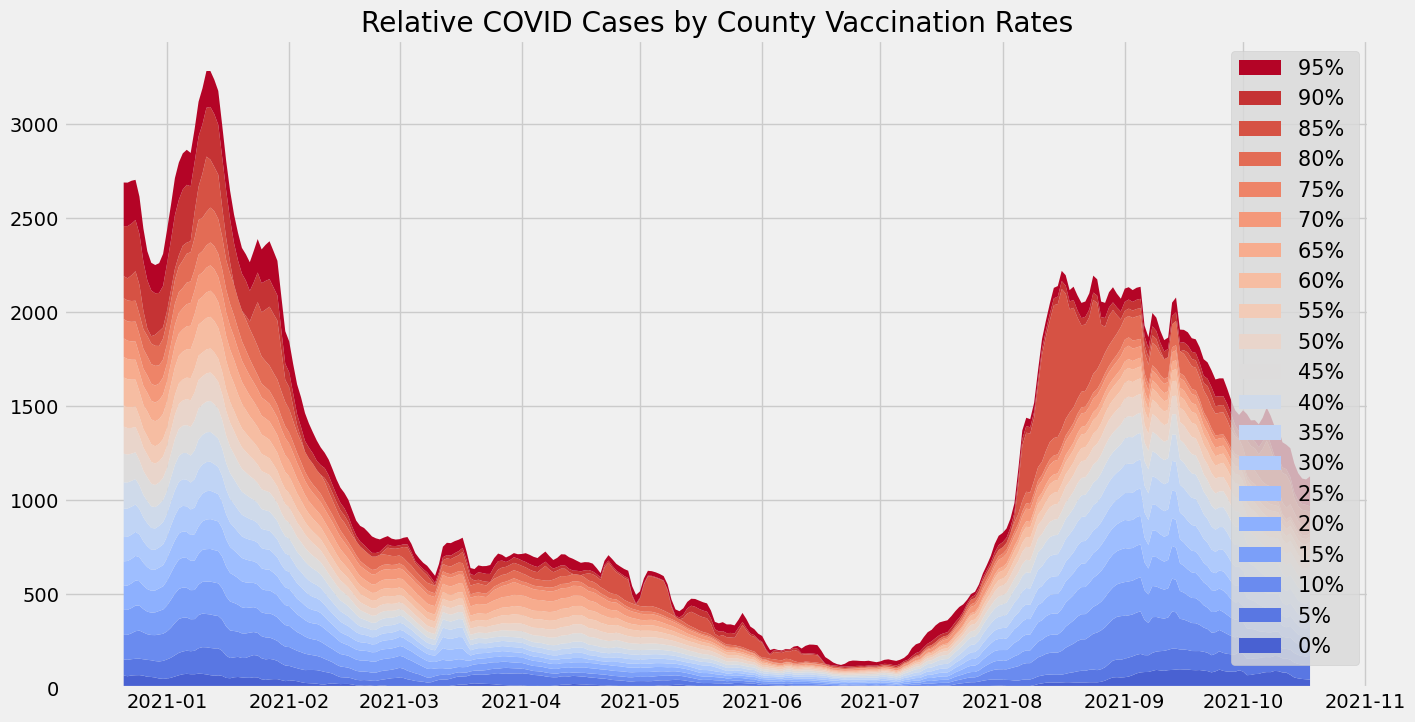

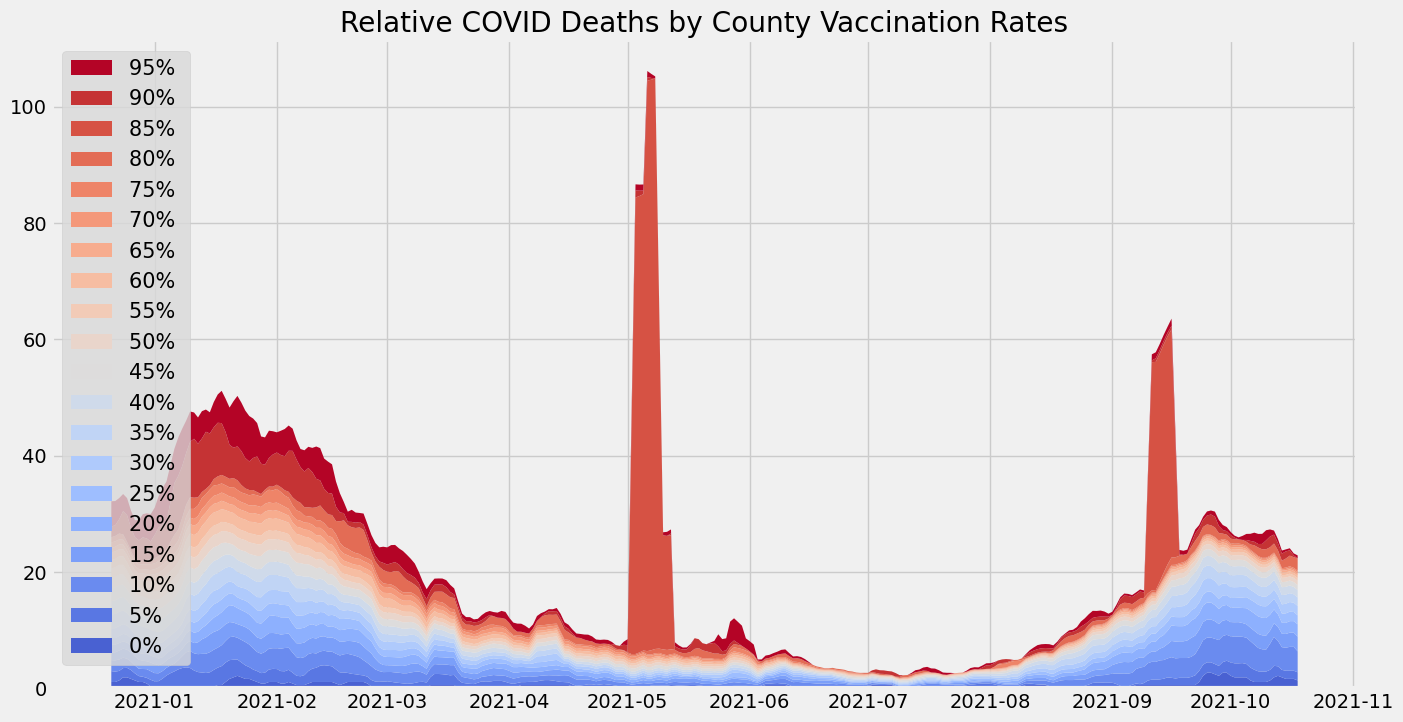

In [22]:
exec_fig_width =15
exec_fig_height=8
fontsize=15

county_cats = county_tier_df['tier'].unique()
county_cats

plot_df = county_tier_df


county_cats = ['total_0','total_20','total_40','total_60','total_80','total_95']
county_cats = county_tier_df['tier'].unique()
plot_dict = {}

#//*** Values for Each Category

#//*** Display Labels for Legend
key_county_label_dict = {}

#//*** Generate Label Display Names
for cat in county_cats:
    value = int(cat.replace("total_",""))
    
    key_county_label_dict[cat] = f"{value}% "
    

#//*** Category is the State Name
category_col = 'tier'

for cat in county_cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['case_100k_avg'].astype(float)
    
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] = v1
    
#//*** Get a color Palette
item_count = len(county_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)


vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

colors = {}
counter = 0
for period in plot_dict.keys():
    colors[period] = colors_palette[counter]
    counter+=1
    
labels=key_county_label_dict.values()


plt.rcdefaults()
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()


fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)


labels=key_county_label_dict.values()
ax.stackplot(plot_df['Date'].unique(),
             plot_dict.values(),
             labels=labels,
             colors=colors_palette,
            )


plt.title('Relative COVID Cases by County Vaccination Rates')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize).legendHandles


#outfilename='z_exec_summary_relative_covid_rates_by_vax.jpg'
#out_exec_summary_images.append(outfilename)
#fig.savefig(outfilename)
#handles = plt.legend().legendHandles
plt.show()

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in county_cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['death_100k_avg'].astype(float)
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] =  (v1)

#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)

labels=key_county_label_dict.values()


ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
            colors=colors_palette,
            )

plt.title('Relative COVID Deaths by County Vaccination Rates')

plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9',fontsize=fontsize).legendHandles

plt.show()


In [23]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()
county_cats = county_tier_df['tier'].unique()
tot_pop = county_tier_df['Population'].unique().sum()
category_col = 'tier'

print(whole_county_tier_df['Date'].min())

#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]
print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period_100k'
col2= 'death_period_100k'
#print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
#print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))

col1= 'death_period_100k'
print(start_summary_df[col1])
print(summer_summary_df[col1])
print(start_summary_df[col1] /  start_summary_df[col1].iloc[0])
print(summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])
print( np.array(start_summary_df[col1] /  start_summary_df[col1].iloc[0]) - np.array((summer_summary_df[col1] /  summer_summary_df[col1].iloc[0])))


#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
#county_summary_df.reset_index()



2020-02-06
2020-02-06
6     10393.368169
7     11064.665505
8     10522.358394
9     10856.811227
10    10169.046658
11     9871.915887
12    10087.199643
13     9344.787183
14     9525.545273
Name: confirm_period_100k, dtype: float64
26    4629.001776
27    5102.199463
28    4671.045312
29    3764.723921
30    3557.273497
31    2925.105406
32    2513.695842
33    1768.857356
34    2463.306711
Name: confirm_period_100k, dtype: float64

6     1.000000
7     1.064589
8     1.012411
9     1.044590
10    0.978417
11    0.949828
12    0.970542
13    0.899111
14    0.916502
Name: confirm_period_100k, dtype: float64
26    1.000000
27    1.102225
28    1.009083
29    0.813291
30    0.768475
31    0.631908
32    0.543032
33    0.382125
34    0.532146
Name: confirm_period_100k, dtype: float64
[ 0.         -0.03763556  0.00332818  0.2312996   0.20994157  0.3179199
  0.42750999  0.51698556  0.38435583]
6     186.790093
7     207.227587
8     185.777303
9     194.852308
10    162.934971
11    176.2

index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
26      0  total_30  summer     9450180  0.031819  2021-07-01  2021-10-18          437449          4629.001776            5137          54.358753
27      0  total_35  summer    16060603  0.054076  2021-07-01  2021-10-18          819444          5102.199463            9638          60.010200
28      0  total_40  summer    24033614  0.080921  2021-07-01  2021-10-18         1122621          4671.045312           11980          49.846852
29      0  total_45  summer    40580479  0.136633  2021-07-01  2021-10-18         1527743          3764.723921           14899          36.714697
30      0  total_50  summer    48443253  0.163107  2021-07-01  2021-10-18         1723259          3557.273497           12078          24.932265
31      0  total_55  summer    54468738  0.183395  2021-07-01  2021-10-18         1593268          2925.105406            9858          18.098455
32      0  total_60  summer    51896772  0.174735  2021-07-01  2021-10-18         1304527          2513.695842            7569          14.584722
33      0  total_65  summer    18867717  0.063527  2021-07-01  2021-10-18          333743          1768.857356            2086          11.055922
34      0  total_70  summer    19201263  0.064650  2021-07-01  2021-10-18          472986          2463.306711            1690           8.801504

In [24]:
start_summary_df

index      tier period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
6       0  total_30  start     9450180  0.031819  2020-02-06  2021-06-30          982192         10393.368169           17652         186.790093
7       0  total_35  start    16060603  0.054076  2020-02-06  2021-06-30         1777052         11064.665505           33282         207.227587
8       0  total_40  start    24033614  0.080921  2020-02-06  2021-06-30         2528903         10522.358394           44649         185.777303
9       0  total_45  start    40580479  0.136633  2020-02-06  2021-06-30         4405746         10856.811227           79072         194.852308
10      0  total_50  start    48443253  0.163107  2020-02-06  2021-06-30         4926217         10169.046658           78931         162.934971
11      0  total_55  start    54468738  0.183395  2020-02-06  2021-06-30         5377108          9871.915887           96022         176.288278
12      0  total_60  start    51896772  0.174735  2020-02-06  2021-06-30         5234931         10087.199643           96286         185.533698
13      0  total_65  start    18867717  0.063527  2020-02-06  2021-06-30         1763148          9344.787183           35376         187.494862
14      0  total_70  start    19201263  0.064650  2020-02-06  2021-06-30         1829025          9525.545273           35072         182.654651

In [25]:
county_vax_df[county_vax_df['FIPS'] == 13053]
county_vax_df[county_vax_df['FIPS'] == 35031]


Date   FIPS     Recip_County Recip_State  total_vaccinated_percent  total_vaccinated_count  first_dose_pct  first_dose_count
2940     2021-10-18  35031  McKinley County          NM                      99.9                   71904            99.9           79558.0
5041     2021-10-17  35031  McKinley County          NM                      99.9                   71823            99.9           79436.0
6940     2021-10-16  35031  McKinley County          NM                      99.9                   71780            99.9           79325.0
9878     2021-10-15  35031  McKinley County          NM                      99.9                   71690            99.9           79125.0
14247    2021-10-14  35031  McKinley County          NM                      99.9                   71601            99.9           78962.0
...             ...    ...              ...         ...                       ...                     ...             ...               ...
1003578  2020-12-17  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1007137  2020-12-16  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1008582  2020-12-15  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1011107  2020-12-14  35031  McKinley County          NM                       0.0                       0             0.0               0.0
1014213  2020-12-13  35031  McKinley County          NM                       0.0                       0             0.0               0.0

[310 rows x 8 columns]

# Build Statewide Overview Summary Dictionary #

In [26]:


category_col = 'tier'
overview_state_dict = {}
start_date =  vax_tier_state_df['Date'].min()
end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population']
    loop_dict['pop_pct'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].min()
    loop_dict['date_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat]['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['tot_death'] - vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = vax_tier_state_df[vax_tier_state_df[category_col]==cat].iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
    
#//*** Display Labels for Legend
key_label_dict = {}

#//*** Generate Label Display Names
for cat in cats:
    value = int(cat.replace("total_",""))
    key_label_dict[cat] = f"{value}%: {', '.join(overview_state_dict[cat]['states'])}"
    key_label_dict[cat] = f"{value}% "
    
overview_state_dict
key_label_dict

{'total_40': '40% ',
 'total_45': '45% ',
 'total_50': '50% ',
 'total_55': '55% ',
 'total_60': '60% ',
 'total_65': '65% '}

# Statewide Vax Tier Graphs #

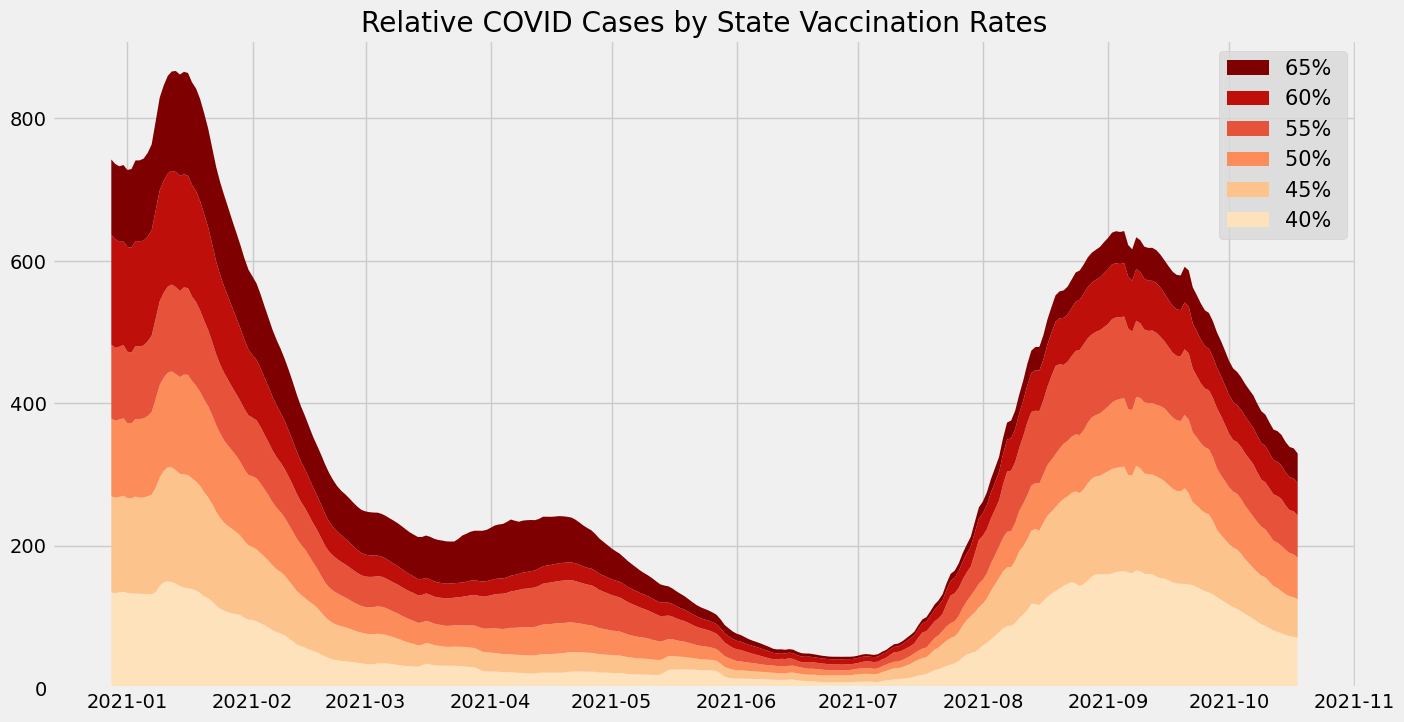

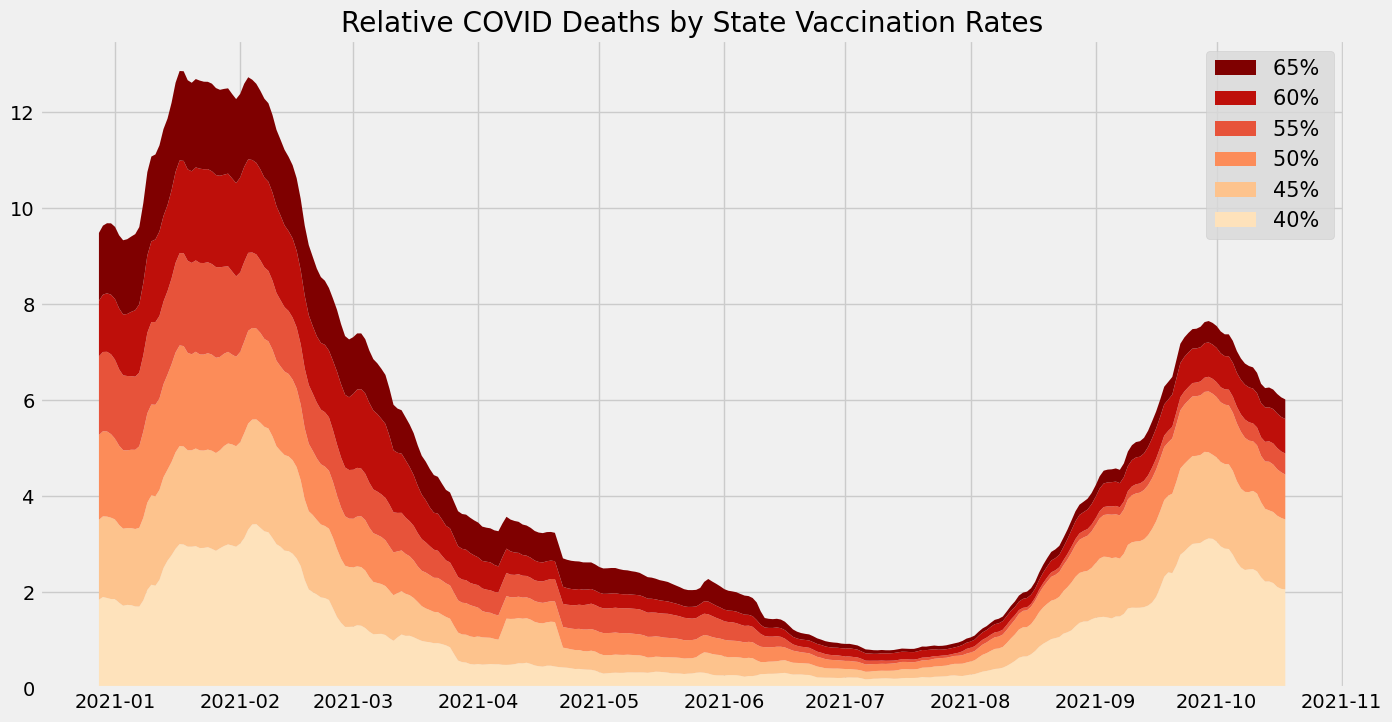

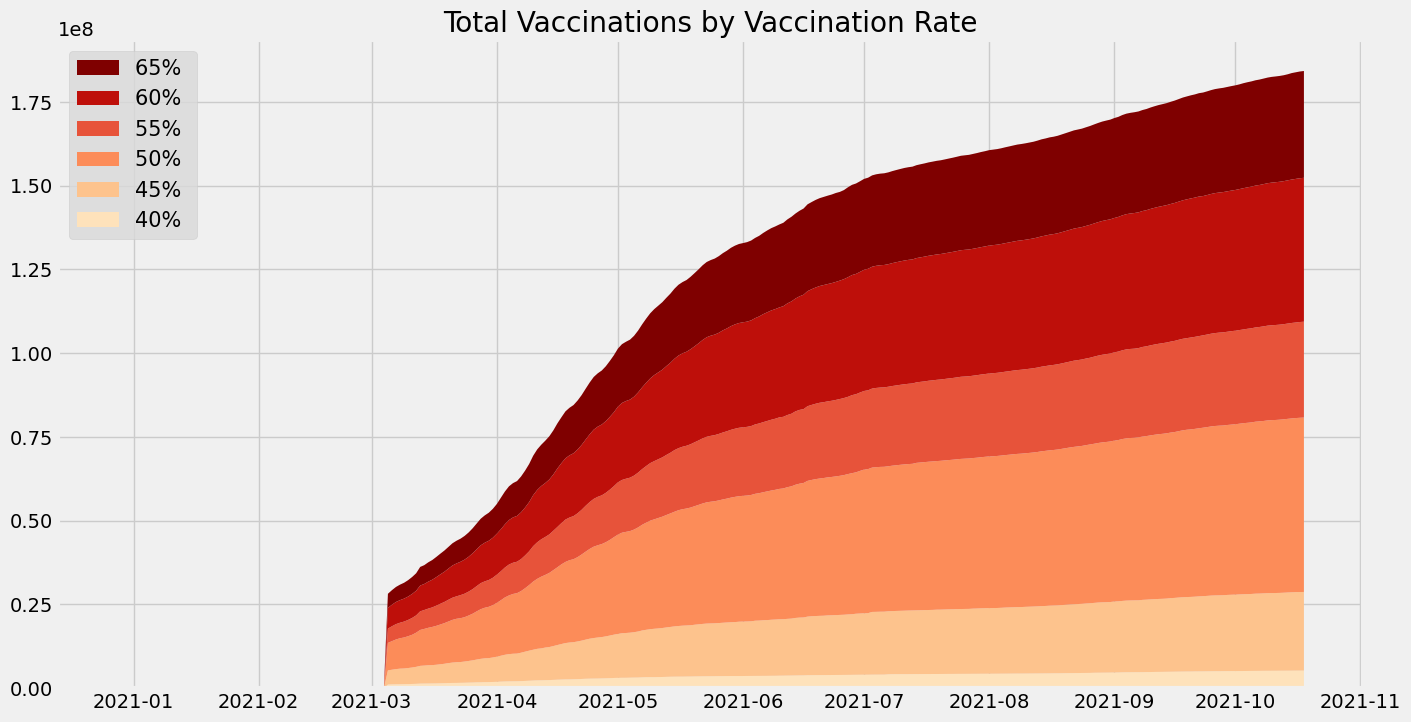

In [27]:
out_exec_summary_images = []

exec_fig_width =15
exec_fig_height=8
fontsize=15

plot_df = vax_tier_state_df



plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['case_avg_100k']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] = v1

#//*** Get a color Palette
item_count = len(cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)
    
vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Dark2(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

colors = {}
counter = 0
for period in plot_dict.keys():
    colors[period] = colors_palette[counter]
    counter+=1
    
labels=key_label_dict.values()


plt.rcdefaults()
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()


fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)


labels=key_label_dict.values()
ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
             colors=colors_palette,
            )


plt.title('Relative COVID Cases by State Vaccination Rates')
handles = plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize).legendHandles


outfilename='z_exec_summary_relative_covid_rates_by_vax.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)
#handles = plt.legend().legendHandles
plt.show()


plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['death_avg_100k']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] =  (v1)

#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)

labels=key_label_dict.values()


ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
            colors=colors_palette,
            )

plt.title('Relative COVID Deaths by State Vaccination Rates')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize)

outfilename='z_exec_summary_relative_death_rates_by_vax.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()
out_exec_summary_images.append("z_exec_summary_relative_death_rates_by_vax.jpg")
#//*** Category is the State Name
category_col = 'tier'

for cat in cats:
    
    v1 = plot_df[plot_df[category_col] == cat]['total_vaccinated_count']
    #v2 = plot_df[plot_df[category_col] == cat]['total_vaccinated_percent']
    #v2=1
    #//*** Replace Infinite divide my 0 errors with 0
    plot_dict[cat] =  (v1)


#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)

labels=key_label_dict.values()

ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
             labels=labels,
             colors=colors_palette,
            )
plt.title('Total Vaccinations by Vaccination Rate')
plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=fontsize)

outfilename='z_exec_summary_total_vax_rates.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()

out_exec_summary_images.append("z_exec_summary_total_vax_rates.jpg")

In [28]:
#//*** Summary stats to be built into a table.
for key,value in overview_state_dict.items():
    print(f"{key} pop pct:{round(overview_state_dict[key]['pop_pct'],4)} confirm 100k:{int(overview_state_dict[key]['confirm_period_100k'])} Death 100k:{int(overview_state_dict[key]['death_period_100k'])} Vaccine 100k:{int(overview_state_dict[key]['vax_complete_100k'])}")

total_40 pop pct:0.0368 confirm 100k:9408 Death 100k:176 Vaccine 100k:43547
total_45 pop pct:0.1495 confirm 100k:8981 Death 100k:139 Vaccine 100k:47985
total_50 pop pct:0.302 confirm 100k:7707 Death 100k:115 Vaccine 100k:52684
total_55 pop pct:0.1487 confirm 100k:8576 Death 100k:82 Vaccine 100k:58840
total_60 pop pct:0.2167 confirm 100k:6501 Death 100k:101 Vaccine 100k:60604
total_65 pop pct:0.1463 confirm 100k:7129 Death 100k:92 Vaccine 100k:66617


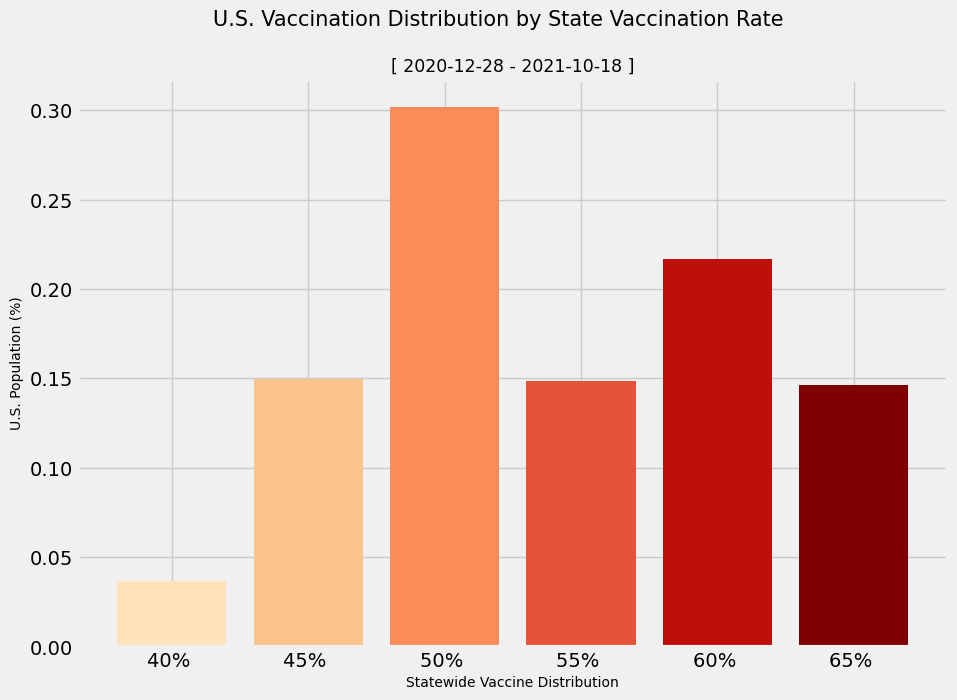

In [29]:
#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

fontsize=10

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(10,7)

labels = []

for label in key_label_dict.values():
    labels.append(label.split(":")[0])
    


x_vals = overview_state_dict.keys()
y_vals = np.array([overview_state_dict[x]['pop_pct'] for x in overview_state_dict.keys()])


ax.bar(x_vals, y_vals,
             label=labels,
             color=colors_palette,
            )
plt.suptitle(f'U.S. Vaccination Distribution by State Vaccination Rate',fontsize=fontsize*1.5)
plt.title(f'[ {start_date.date()} - {end_date.date()} ]',fontsize=fontsize*1.25)
ax.set_xlabel("Statewide Vaccine Distribution",fontsize=fontsize)
ax.set_ylabel("U.S. Population (%)",fontsize=fontsize)
#plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

outfilename='z_exec_summary_vax_distribution.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()
out_exec_summary_images.append("z_exec_summary_vax_distribution.jpg")

# Build Statewide Overview Summer Summary Dictionary #

In [30]:
#overview_state_dict

category_col = 'tier'
summer_overview_state_dict = {}
start_summer_date =  datetime(2021, 1, 7)

end_date =  vax_tier_state_df['Date'].max()
tot_pop = vax_tier_state_df['population'].unique().sum()
for cat in cats:
    loop_dict = {}
    
    #//*** Just the Summer Values
    summer_df = vax_tier_state_df[(vax_tier_state_df[category_col]==cat) & (vax_tier_state_df['Date'] >= start_summer_date ) ]
    
    #print( vax_tier_df[vax_tier_df[category_col]==cat])
    
    loop_dict['population'] = summer_df.iloc[0]['population']
    loop_dict['pop_pct'] = summer_df.iloc[0]['population'] / tot_pop
    loop_dict['date_start'] = summer_df['Date'].min()
    loop_dict['date_end'] = summer_df['Date'].max()
    #//*** Get Total Confirmed Cases for this period
    loop_dict['confirm_period'] = summer_df.iloc[-1]['tot_confirm'] - summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_start'] = summer_df.iloc[0]['tot_confirm']
    loop_dict['confirm_end'] = summer_df.iloc[-1]['tot_confirm']
    
    
    loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
    #//*** Get Total Deaths for this period
    loop_dict['confirm_deaths'] = summer_df.iloc[-1]['tot_death'] - summer_df.iloc[0]['tot_death']
    loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)
    
    loop_dict['vax_complete'] = summer_df.iloc[-1]['total_vaccinated_count']
    loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['population'] / 100000)
    loop_dict['vax_partial'] = summer_df.iloc[-1]['first_dose_count']
    loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['population'] / 100000)
    
    
    
    loop_dict['states'] = vax_range_dict[cat.replace("total_","")]
    summer_overview_state_dict[cat] = loop_dict
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[0])
    #print(vax_tier_df[vax_tier_df[category_col]==cat].iloc[-1])
summer_overview_state_dict


{'total_40': {'population': 12037305,
  'pop_pct': 0.03679124653005932,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-18 00:00:00'),
  'confirm_period': 1043870,
  'confirm_start': 906808,
  'confirm_end': 1950678,
  'confirm_period_100k': 8671.95771811049,
  'confirm_deaths': 20013,
  'death_period_100k': 166.25814499175686,
  'vax_complete': 5241926,
  'vax_complete_100k': 43547.338876933,
  'vax_partial': 6180061,
  'vax_partial_100k': 51340.90230329795,
  'states': ['Alabama', 'Idaho', 'Mississippi', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 48919367,
  'pop_pct': 0.14951889076429056,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-18 00:00:00'),
  'confirm_period': 4003320,
  'confirm_start': 3757311,
  'confirm_end': 7760631,
  'confirm_period_100k': 8183.507362227316,
  'confirm_deaths': 63666,
  'death_period_100k': 130.14477476783378,
  'vax_complete': 23474356,
  'vax_complete_100k': 47985

# Summer Statewide Vax Tier Graphs #

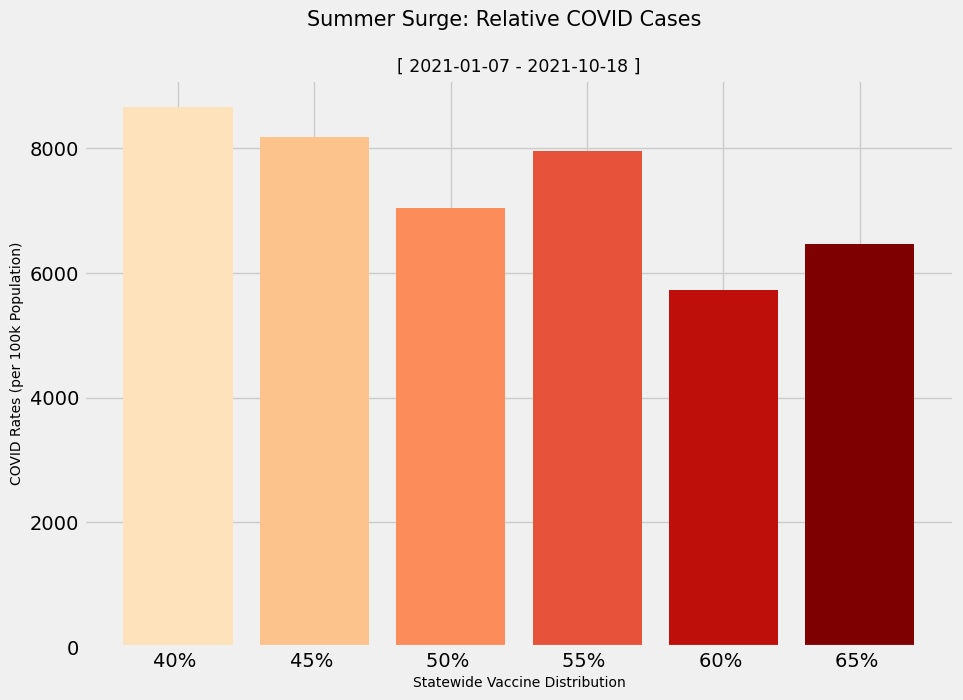

In [31]:


#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

fontsize=10

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(10,7)

labels = []

for label in key_label_dict.values():
    labels.append(label.split(":")[0])
    


x_vals = overview_state_dict.keys()
y_vals = np.array([summer_overview_state_dict[x]['confirm_period_100k'] for x in summer_overview_state_dict.keys()])


ax.bar(x_vals, y_vals,
             label=labels,
             color=colors_palette,
            )
plt.suptitle('Summer Surge: Relative COVID Cases',fontsize=fontsize*1.5)
plt.title(f'[ {start_summer_date.date()} - {end_date.date()} ]',fontsize=fontsize*1.25)
ax.set_xlabel("Statewide Vaccine Distribution",fontsize=fontsize)
ax.set_ylabel("COVID Rates (per 100k Population)",fontsize=fontsize)
#plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

outfilename='z_exec_summary_summer_covid_rates.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

plt.show()
out_exec_summary_images.append("z_exec_summary_summer_covid_rates.jpg")

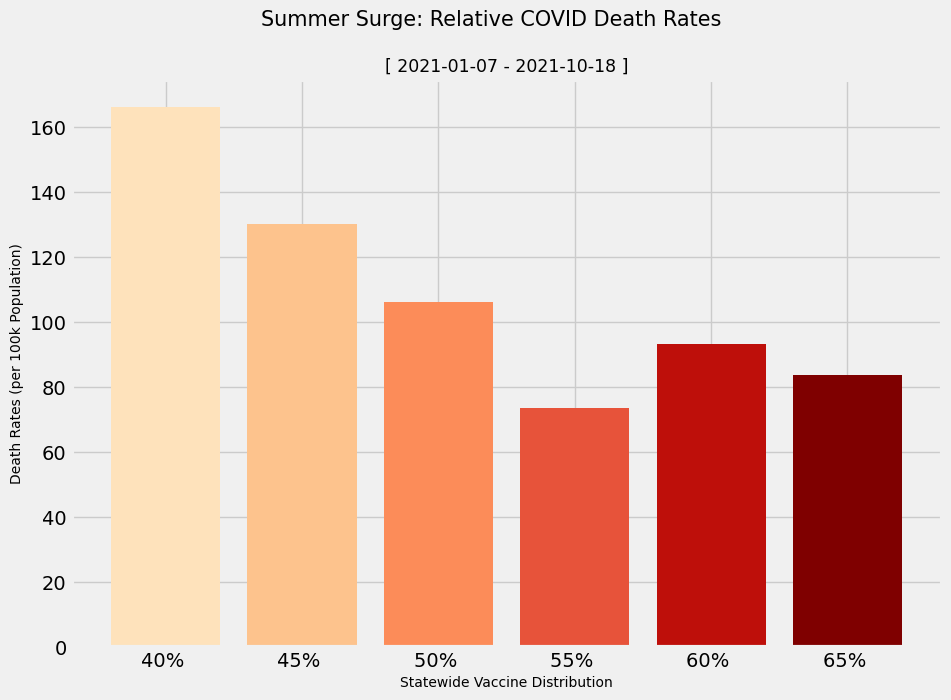

In [32]:
#//*** Style the Plot
plt.rcdefaults()
plt.style.use('fivethirtyeight')

fontsize=10

#//*** Initialize the subplots
fig, ax = plt.subplots()

#//*** Size the plot
fig = plt.gcf()
fig.set_size_inches(10,7)

labels = []

for label in key_label_dict.values():
    labels.append(label.split(":")[0])
    


x_vals = summer_overview_state_dict.keys()
y_vals = np.array([summer_overview_state_dict[x]['death_period_100k'] for x in summer_overview_state_dict.keys()])


ax.bar(x_vals, y_vals,
             label=labels,
             color=colors_palette,
            )
plt.suptitle('Summer Surge: Relative COVID Death Rates',fontsize=fontsize*1.5)
plt.title(f'[ {start_summer_date.date()} - {end_date.date()} ]',fontsize=fontsize*1.25)
ax.set_xlabel("Statewide Vaccine Distribution",fontsize=fontsize)
ax.set_ylabel("Death Rates (per 100k Population)",fontsize=fontsize)
#plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper left', facecolor='#d9d9d9', fontsize=12)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)

outfilename='z_exec_summary_summer_death_rates.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)


plt.show()
out_exec_summary_images.append("z_exec_summary_summer_death_rates.jpg")

['40% ', '45% ', '50% ', '55% ', '60% ', '65% ']


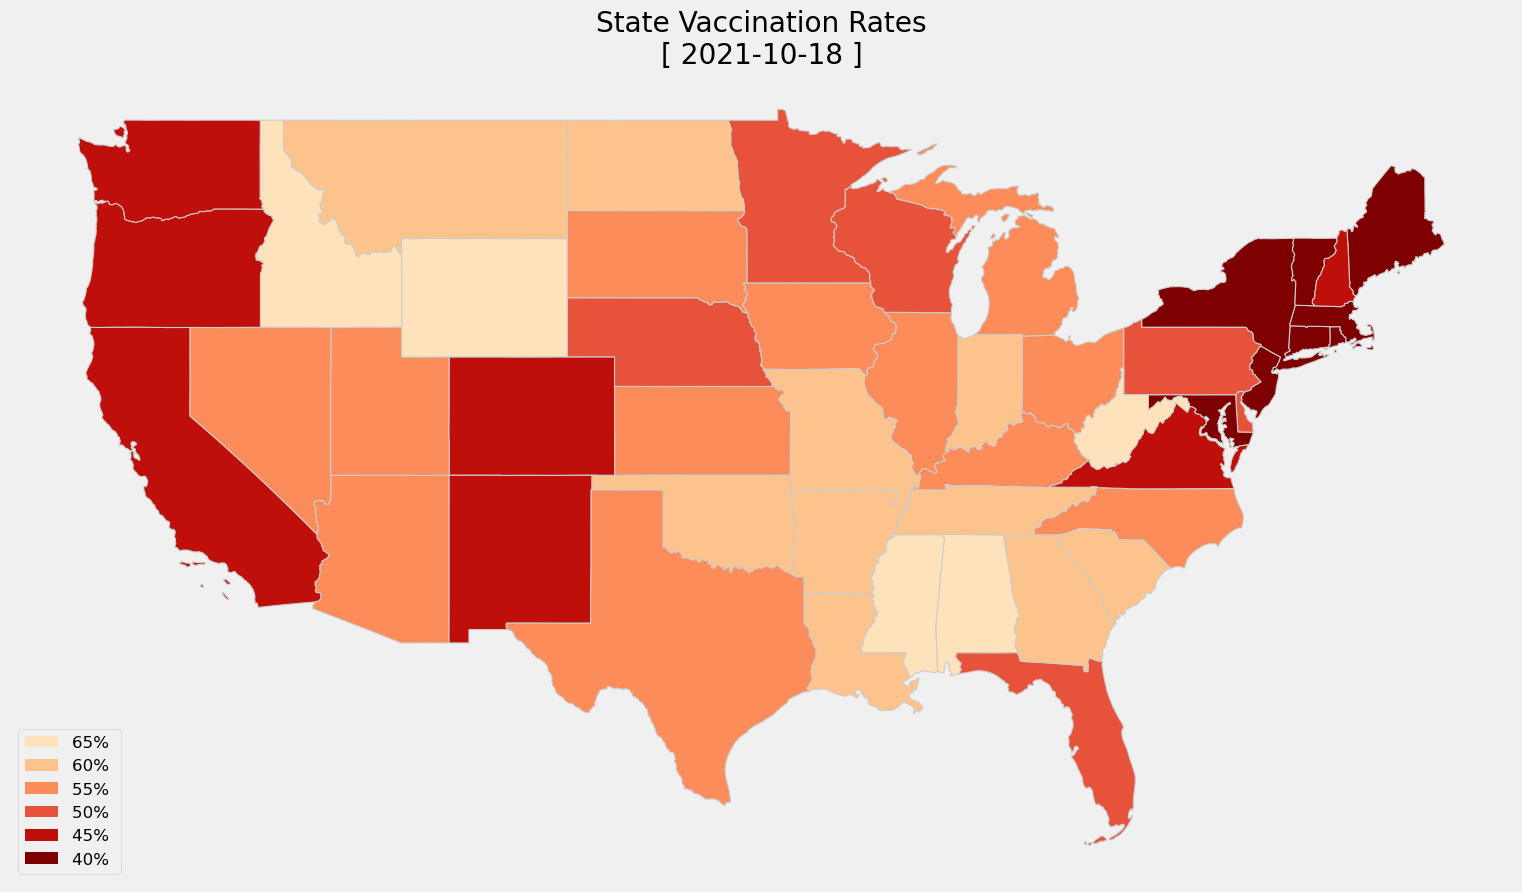

In [33]:
vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

td_state = []
td_tot = []

for key,value in overview_state_dict.items():
    for state in value['states']:
        td_state.append(state)
        td_tot.append(key)
tdf = pd.DataFrame([td_tot,td_state]).transpose()
tdf.columns = ['rank','Name']

vax_dist_df = vax_dist_df.merge(tdf,left_on='Name', right_on='Name')
vax_dist_df



#fig = plt.gcf()
#fig.set_size_inches(20,10)


labels=list(key_label_dict.values())
print(labels)

ax = vax_dist_df.plot(column='rank', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')
ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"State Vaccination Rates\n[ {end_date.date()} ]")
fig = plt.gcf()
fig.set_size_inches(20,10)

#//*** Handles is taken from earlie
plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)

outfilename='z_exec_summary_binned_vax_map.jpg'
out_exec_summary_images.append(outfilename)
fig.savefig(outfilename)

out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()

In [34]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

- [ Analyze State Hospitalization Tiers: state_hosp_tiers_df](#analyze_state_hosp_tiers_df)
<a id="analyze_state_hosp_tiers_df"></a> 
# Analyze State Hospitalization Tiers: state_hosp_tiers_df #

In [35]:
start_summer_date =  datetime(2021, 7, 1)

#//**** cats s a list of tiers
state_hosp_cats = state_hosp_tiers_df['tier'].unique()

tot_pop = state_hosp_tiers_df['population'].unique().sum()

category_col = 'tier'

#//*** Build the start and summer dataframes for convenience
start_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] < start_summer_date ]
summer_tier_df = state_hosp_tiers_df[state_hosp_tiers_df['Date'] >= start_summer_date ]



#//*** Placeholder dictionaries
start_summary_dict = {}
summer_summary_dict = {}

#//*** Final DataFrame for output
state_hosp_tier_summary_df = pd.DataFrame()

for df in ['start_tier_df','summer_tier_df']:
    
    for cat in state_hosp_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_tier_df[start_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_tier_df':
            loop_df = summer_tier_df[summer_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'
            
        loop_dict['population'] = loop_df.iloc[0]['population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_death'] - loop_df.iloc[0]['tot_death']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        
        #if df == 'start_tier_df':
        #    start_tier_df[cat] = loop_dict
    
        #if df == 'summer_tier_df':
        #    summer_tier_df[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        state_hosp_tier_summary_df = pd.concat([state_hosp_tier_summary_df,tdf])

        
state_hosp_tier_summary_df

tier  period  population   pop_pct date_start   date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0  total_40   start    12037305  0.036994 2020-02-07 2021-06-30         1294076         10750.545907           24554         203.982536
0  total_45   start    48919367  0.150342 2020-02-07 2021-06-30         5445744         11132.081901           93482         191.094051
0  total_50   start    98817290  0.303692 2020-02-07 2021-06-30        10314366         10437.815083          176156         178.264350
0  total_55   start    48649964  0.149514 2020-02-07 2021-06-30         5199262         10687.082934           84297         173.272482
0  total_60   start    69095648  0.212350 2020-02-07 2021-06-30         6075762          8793.262927           96158         139.166507
0  total_65   start    47242794  0.145190 2020-02-07 2021-06-30         4878690         10326.844767          119467         252.878778
0  total_70   start      623989  0.001918 2020-02-07 2021-06-30           24410          3911.927935             256          41.026364
0  total_40  summer    12037305  0.036994 2021-07-01 2021-10-18          656212          5451.486026            9065          75.307554
0  total_45  summer    48919367  0.150342 2021-07-01 2021-10-18         2310682          4723.450326           26602          54.379281
0  total_50  summer    98817290  0.303692 2021-07-01 2021-10-18         3420798          3461.740349           36522          36.959119
0  total_55  summer    48649964  0.149514 2021-07-01 2021-10-18         2011135          4133.887951            5041          10.361775
0  total_60  summer    69095648  0.212350 2021-07-01 2021-10-18         1807099          2615.358640           14867          21.516551
0  total_65  summer    47242794  0.145190 2021-07-01 2021-10-18          870577          1842.772043            6350          13.441203
0  total_70  summer      623989  0.001918 2021-07-01 2021-10-18           13107          2100.517798              89          14.263072

In [36]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
16      12037305 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
17      12037305 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
18      12037305 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
19      12037305 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
20      12037305 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
...          ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
27343     623989 2021-10-14       342       36503       478          3      471.428571     75.550782         3.857143       0.618143  VT                 [50]  total_70     1222.0     961.0   
27344     623989 2021-10-15       343       36730       378          3      443.714286     71.109312         3.571429       0.572354  VT                 [50]  total_70     1211.0     956.0   
27345     623989 2021-10-16       345       37069       566          3      448.000000     71.796137         3.000000       0.480778  VT                 [50]  total_70     1214.0     924.0   
27346     623989 2021-10-17       345       37318       588          2      465.142857     74.543439         2.857143       0.457884  VT                 [50]  total_70     1214.0     890.0   
27347     623989 2021-10-18       346       37519       450          1      467.571429      74.93264         3.000000       0.480778  VT                 [50]  total_70     1214.0     890.0   

      covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
16                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
17                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
18                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
19                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
20                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...               ...       ...                ...       ...              ...             ...              ...               ...  
27343            47.0     103.0  0.195876288659794      19.0             43.0             4.0        75.550782          0.618143  
27344            44.0      96.0  0.130434782608696      12.0             40.0             4.0        71.109312          0.572354  
27345            41.0      98.0  0.130434782608696      12.0             40.0             1.0        71.796137          0.480778  
27346            38.0      98.0  0.119565217391304      11.0             37.0             1.0        74.543439          0.457884  
27347            38.0      98.0  0.119565217391304      11.0             37.0             1.0         74.93264          0.480778  

[4340 rows x 23 columns]

In [37]:
#//*** Set Some Constants
start_summer_date =  datetime(2021, 7, 1).date()


#//*** Build the Start Datframe: All Dates up to Summer Surge
start_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date]

print(start_county_tier_df['Date'].min())
#print(whole_county_tier_df)
#//*** Build the Summer Datframe: All Dates after the Summer Surge
summer_county_tier_df = whole_county_tier_df[whole_county_tier_df['Date'] >= start_summer_date]

start_county_summary_dict = {}
summer_county_summary_dict = {}
county_summary_df = pd.DataFrame()

for df in ['start_county_tier_df','summer_county_tier_df']:
    
    for cat in county_cats:
        
        loop_dict = {}
        
        loop_dict['tier'] = cat
        
        if df == 'start_county_tier_df':
            #//*** Get all cat values from the tier dataframe
            loop_df = start_county_tier_df[start_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'start'
           
            
        
        if df == 'summer_county_tier_df':
            loop_df = summer_county_tier_df[summer_county_tier_df[category_col]==cat]
            loop_dict['period'] = 'summer'

        
        loop_dict['Population'] = loop_df.iloc[0]['Population']



        loop_dict['pop_pct'] = loop_df.iloc[0]['Population'] / tot_pop
        loop_dict['date_start'] = loop_df['Date'].min()

        loop_dict['date_end'] = loop_df['Date'].max()
        #//*** Get Total Confirmed Cases for this period
        loop_dict['confirm_period'] = loop_df.iloc[-1]['tot_confirm'] - loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_start'] = loop_df.iloc[0]['tot_confirm']
        #loop_dict['confirm_end'] = loop_df.iloc[-1]['tot_confirm']

        #print(loop_df)
        loop_dict['confirm_period_100k'] = loop_dict['confirm_period'] / ( loop_dict['Population'] / 100000)
        #//*** Get Total Deaths for this period
        loop_dict['confirm_deaths'] = loop_df.iloc[-1]['tot_deaths'] - loop_df.iloc[0]['tot_deaths']
        loop_dict['death_period_100k'] = loop_dict['confirm_deaths'] / ( loop_dict['Population'] / 100000)

        #loop_dict['vax_complete'] = loop_df.iloc[-1]['total_vaccinated_count']
        #loop_dict['vax_complete_100k'] = loop_dict['vax_complete'] / ( loop_dict['Population'] / 100000)
        #loop_dict['vax_partial'] = loop_df.iloc[-1]['first_dose_count']
        #loop_dict['vax_partial_100k'] = loop_dict['vax_partial'] / ( loop_dict['Population'] / 100000)
        

        
        if df == 'start_county_tier_df':
            start_county_summary_dict[cat] = loop_dict
    
        if df == 'summer_county_tier_df':
            summer_county_summary_dict[cat] = loop_dict
        
        tdf = pd.DataFrame()
        
        for key,value in loop_dict.items():
            #print(key,value)
            tdf[key] = [value]
        county_summary_df = pd.concat([county_summary_df,tdf])

county_summary_df = county_summary_df.reset_index()
        
county_summary_df = county_summary_df[county_summary_df['pop_pct'] > .025]
#county_summary_df = county_summary_df[county_summary_df['Population'] > 100000]

start_summary_df = county_summary_df[county_summary_df['period'] == 'start']
summer_summary_df = county_summary_df[county_summary_df['period'] == 'summer']
#whole_summary_df = county_summary_df[county_summary_df['period'] == 'whole']


#print(start_summary_df['confirm_period_100k'] /  start_summary_df['confirm_period_100k'].iloc[0])
print(start_summary_df['confirm_period_100k'])
print(summer_summary_df['confirm_period_100k'])
col1='confirm_period'
col2 = 'confirm_deaths'
print(pd.Series(np.array(summer_summary_df[col1]) / np.array(start_summary_df[col1])))
print(pd.Series(np.array(summer_summary_df[col2]) / np.array(start_summary_df[col2])))
print()

#print(summer_summary_df['confirm_period_100k'] /  summer_summary_df['confirm_period_100k'].iloc[0])
#print((summer_summary_df['confirm_period'] /  summer_summary_df['confirm_period'].iloc[0]).reset_index())


summer_summary_df
#print(county_summary_df['confirm_deaths'].sum())
county_summary_df.reset_index()



2020-02-06
6     10393.368169
7     11064.665505
8     10522.358394
9     10856.811227
10    10169.046658
11     9871.915887
12    10087.199643
13     9344.787183
14     9525.545273
Name: confirm_period_100k, dtype: float64
26    4629.001776
27    5102.199463
28    4671.045312
29    3764.723921
30    3557.273497
31    2925.105406
32    2513.695842
33    1768.857356
34    2463.306711
Name: confirm_period_100k, dtype: float64
0    0.445380
1    0.461126
2    0.443916
3    0.346761
4    0.349814
5    0.296306
6    0.249197
7    0.189288
8    0.258600
dtype: float64
0    0.291015
1    0.289586
2    0.268315
3    0.188423
4    0.153020
5    0.102664
6    0.078610
7    0.058967
8    0.048187
dtype: float64



level_0  index      tier  period  Population   pop_pct  date_start    date_end  confirm_period  confirm_period_100k  confirm_deaths  death_period_100k
0         6      0  total_30   start     9450180  0.029043  2020-02-06  2021-06-30          982192         10393.368169           17652         186.790093
1         7      0  total_35   start    16060603  0.049359  2020-02-06  2021-06-30         1777052         11064.665505           33282         207.227587
2         8      0  total_40   start    24033614  0.073862  2020-02-06  2021-06-30         2528903         10522.358394           44649         185.777303
3         9      0  total_45   start    40580479  0.124715  2020-02-06  2021-06-30         4405746         10856.811227           79072         194.852308
4        10      0  total_50   start    48443253  0.148879  2020-02-06  2021-06-30         4926217         10169.046658           78931         162.934971
5        11      0  total_55   start    54468738  0.167397  2020-02-06  2021-06-30         5377108          9871.915887           96022         176.288278
6        12      0  total_60   start    51896772  0.159493  2020-02-06  2021-06-30         5234931         10087.199643           96286         185.533698
7        13      0  total_65   start    18867717  0.057986  2020-02-06  2021-06-30         1763148          9344.787183           35376         187.494862
8        14      0  total_70   start    19201263  0.059011  2020-02-06  2021-06-30         1829025          9525.545273           35072         182.654651
9        26      0  total_30  summer     9450180  0.029043  2021-07-01  2021-10-18          437449          4629.001776            5137          54.358753
10       27      0  total_35  summer    16060603  0.049359  2021-07-01  2021-10-18          819444          5102.199463            9638          60.010200
11       28      0  total_40  summer    24033614  0.073862  2021-07-01  2021-10-18         1122621          4671.045312           11980          49.846852
12       29      0  total_45  summer    40580479  0.124715  2021-07-01  2021-10-18         1527743          3764.723921           14899          36.714697
13       30      0  total_50  summer    48443253  0.148879  2021-07-01  2021-10-18         1723259          3557.273497           12078          24.932265
14       31      0  total_55  summer    54468738  0.167397  2021-07-01  2021-10-18         1593268          2925.105406            9858          18.098455
15       32      0  total_60  summer    51896772  0.159493  2021-07-01  2021-10-18         1304527          2513.695842            7569          14.584722
16       33      0  total_65  summer    18867717  0.057986  2021-07-01  2021-10-18          333743          1768.857356            2086          11.055922
17       34      0  total_70  summer    19201263  0.059011  2021-07-01  2021-10-18          472986          2463.306711            1690           8.801504

In [274]:
whole_county_tier_df

Date                          FIPS         Admin2 Province_State                Combined_Key Population tot_confirm tot_deaths New_Confirm New_Deaths  case_7_day_avg  death_7_day_avg  \
15   2020-02-06  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
16   2020-02-07  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
17   2020-02-08  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
18   2020-02-09  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
19   2020-02-10  [25019, 54091, 54017, 25007]          Dukes  Massachusetts    Dukes, Massachusetts, US      53874           0          0           0          0        0.000000         0.000000   
..          ...                           ...            ...            ...                         ...        ...         ...        ...         ...        ...             ...              ...   
631  2021-10-14                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20118        519         190          1      127.285714         0.428571   
632  2021-10-15                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20156        519         131          0      119.714286         0.285714   
633  2021-10-16                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20156        519          38          0      111.428571         0.285714   
634  2021-10-17                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20156        519           0          0      111.428571         0.285714   
635  2021-10-18                [13053, 35031]  Chattahoochee        Georgia  Chattahoochee, Georgia, US      82274       20295        520         139          1      131.285714         0.428571   

    case_100k_avg death_100k_avg case_scaled_100k death_scaled_100k      tier  
15            0.0            0.0              0.0               0.0   total_0  
16            0.0            0.0              0.0               0.0   total_0  
17            0.0            0.0              0.0               0.0   total_0  
18            0.0            0.0              0.0               0.0   total_0  
19            0.0            0.0              0.0               0.0   total_0  
..            ...            ...              ...               ...       ...  
631    154.709525       0.520907              100          0.520907  total_95  
632    145.506826       0.347272              100          0.347272  total_95  
633    135.435947       0.347272              100          0.347272  total_95  
634    135.435947       0.347272              100          0.347272  total_95  
635    159.571328       0.520907              100          0.520907  total_95  

[12420 rows x 17 columns]

['30']


ValueError: operands could not be broadcast together with shapes (511,) (10220,) 

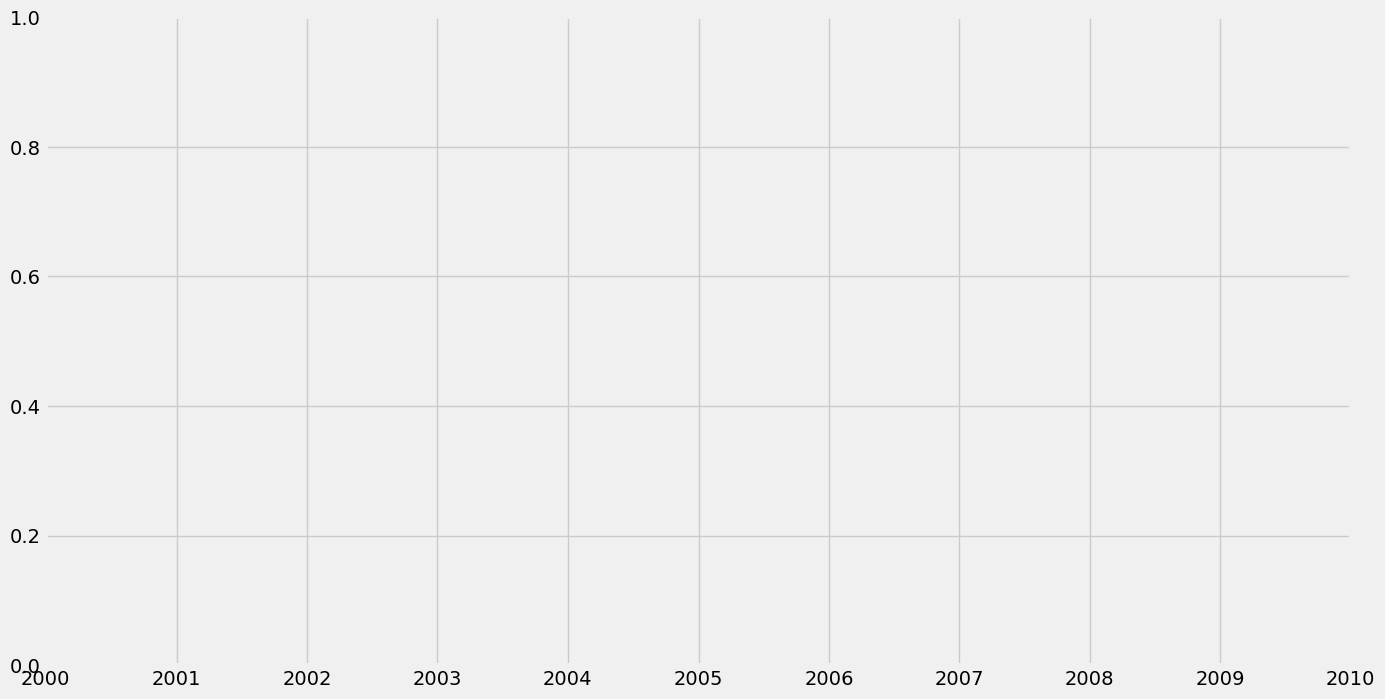

In [317]:

start_summer_date =  datetime(2021, 7, 1).date()

exec_fig_width =15
exec_fig_height=8
fontsize=15

plot_df = whole_county_tier_df[whole_county_tier_df['Date'] < start_summer_date].copy()
#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values


max_tier = 30
min_tier = 70


plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)
plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

#plot_df = plot_df.sort_values('tier').reset_index()
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = "total_" + plot_df['tier']
#print(plot_df)

plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'
plot_col = 'case_avg_100k'
plot_col = 'total_beds'
plot_col = 'covid_beds_used'
plot_col = 'covid_beds_used'
plot_col = 'icu_used'
plot_col = 'tot_confirm'
plot_col2 = 'population'
plot_cats = plot_df[category_col].unique()
print(plot_cats)
for plot_col in ['New_Confirm','New_Deaths']:
    for cat in plot_cats:

        v1 = plot_df[plot_df[category_col] == cat][plot_col].astype(float)
        #v2 = plot_df[plot_df[category_col] == cat][plot_col2].astype(float)
        #v1 = v1/v2
        #//*** Replace Infinite divide my 0 errors with 0
        plot_dict[cat] = v1



    #//*** Get a color Palette
    item_count = len(plot_cats)
    counter_list = []
    counter = 0
    for x in range(item_count):
        counter += 100 / item_count
        counter_list.append(counter)

    vmin=0
    vmax=item_count

    norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
    #colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
    colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

    #//*** Display Labels for Legend
    plot_label_dict = {}

    #//*** Generate Label Display Names
    for cat in plot_cats:
        value = int(cat.replace("total_",""))
        plot_label_dict[cat] = f"{value}% "

    #print(plot_dict.values())
    colors = {}
    counter = 0
    for period in plot_dict.keys():
        colors[period] = colors_palette[counter]
        counter+=1

    labels=key_label_dict.values()


    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots()


    fig = plt.gcf()
    fig.set_size_inches(exec_fig_width,exec_fig_height)


    labels=plot_label_dict.values()
    ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
                 labels=labels,
                 colors=colors_palette,
                )


    plt.title(f'Relative [ {plot_col} ] by Vaccination tiers')
    handles = plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize).legendHandles


    #outfilename='z_exec_summary_relative_covid_rates_by_vax.jpg'
    #out_exec_summary_images.append(outfilename)
    #fig.savefig(outfilename)
    #handles = plt.legend().legendHandles
    plt.show()



In [273]:
#datetime.strptime(col, "%m/%d/%y").date()

type(whole_county_tier_df['Date'].iloc[0])
start_days = (start_summer_date - county_summary_df['date_start'].min()).days
summer_days = (county_summary_df['date_start'].max() - start_summer_date).days


print(start_days,summer_days)


county_analysis_dict = {
    'start_daily_mean_confirm' : start_summary_df['confirm_period'] / start_days,
    'summer_daily_mean_confirm': summer_summary_df['confirm_period'] / summer_days,
    'start_daily_mean_death' : start_summary_df['confirm_deaths'] / start_days,
    'summer_daily_mean_death': summer_summary_df['confirm_deaths'] / summer_days
}

print(start_summary_df['confirm_period'] / start_days)
print(summer_summary_df['confirm_period'] / summer_days)

print( 1 - pd.Series(np.array(county_analysis_dict['summer_daily_mean_confirm']) / np.array(county_analysis_dict['start_daily_mean_confirm'])))

print(start_summary_df['confirm_deaths'] / start_days)
print(summer_summary_df['confirm_deaths'] / summer_days)
print( 1 - pd.Series(np.array(county_analysis_dict['summer_daily_mean_death']) / np.array(county_analysis_dict['start_daily_mean_death'])))

336 175
6      2923.190476
7      5288.845238
8      7526.497024
9     13112.339286
10    14661.360119
11    16003.297619
12    15580.151786
13     5247.464286
14     5443.526786
Name: confirm_period, dtype: float64
26    2499.708571
27    4682.537143
28    6414.977143
29    8729.960000
30    9847.194286
31    9104.388571
32    7454.440000
33    1907.102857
34    2702.777143
Name: confirm_period, dtype: float64
0    0.144870
1    0.114639
2    0.147681
3    0.334218
4    0.328357
5    0.431093
6    0.521543
7    0.636567
8    0.503488
dtype: float64
6      52.535714
7      99.053571
8     132.883929
9     235.333333
10    234.913690
11    285.779762
12    286.565476
13    105.285714
14    104.380952
Name: confirm_deaths, dtype: float64
26    29.354286
27    55.074286
28    68.457143
29    85.137143
30    69.017143
31    56.331429
32    43.251429
33    11.920000
34     9.657143
Name: confirm_deaths, dtype: float64
0    0.441251
1    0.443995
2    0.484835
3    0.638227
4    0.706202
5  

In [82]:
#//*** Associate County FIPS with a TIER value
ftd = {
    'tier' : [],
    'FIPS' : []
}
for row in whole_county_tier_df[whole_county_tier_df['Date'] == whole_county_tier_df['Date'].max()].iterrows():
    for FIPS in row[1]['FIPS']:
        ftd['tier'].append([row[1]['tier']][0])
        ftd['FIPS'].append(FIPS)

tdf = pd.DataFrame()

tdf['FIPS'] = ftd['FIPS']
tdf['tier'] = ftd['tier']

"""
#//*** Get Shape File
geo_county_tier_df = gpd.read_file('maps\cb_2018_us_county_20m.shp')

#//*** Keep the important Columns
geo_county_tier_df = geo_county_tier_df[['STATEFP','GEOID','NAME','geometry']]

geo_county_tier_df['GEOID'] = geo_county_tier_df['GEOID'].astype(int)
geo_county_tier_df['STATEFP'] = geo_county_tier_df['STATEFP'].astype(int)

print(len(geo_county_tier_df))

geo_county_tier_df = geo_county_tier_df.merge(tdf,left_on='GEOID',right_on='FIPS')
geo_county_tier_df.plot()
"""

print(state_daily_df)

     STATEFP  GEOID     NAME                                           geometry     Name Postal Code  FIPS       Date Location  first_dose_count  first_dose_pct  total_vaccinated_count  \
308        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-14       AL                 0             0.0                       0   
307        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-15       AL                 0             0.0                       0   
306        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-16       AL                 0             0.0                       0   
305        1      1  Alabama  POLYGON ((-88.46866 31.89386, -88.46866 31.933...  Alabama          AL     1 2020-12-17       AL                 0             0.0                       0   
304        1      1  Alabama  POLYGON ((-88.46866 31.89386, 

In [164]:
summer_summary_df['date_end'].min() - summer_summary_df['date_start'].min()

datetime.timedelta(days=109)

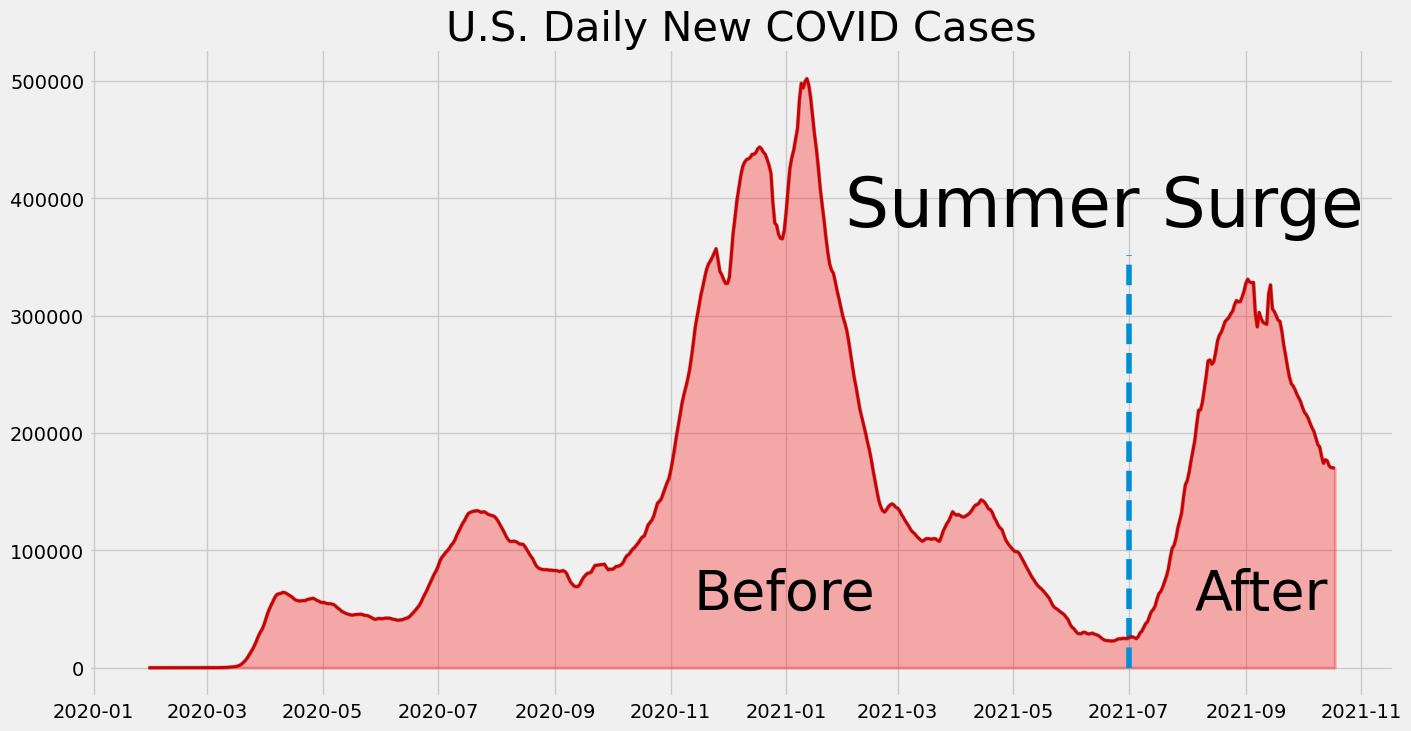

In [200]:
from datetime import timedelta
#//**** Build US. Totals
us_covid = confirm_df[confirm_df.columns[11:]].sum().diff(2).rolling(7).mean()[8:].reset_index()
us_covid.columns = ['date','New_Cases']
us_covid['date'] = us_covid['date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
us_covid


exec_fig_width =15
exec_fig_height=8
fontsize=15

plt.rcdefaults()
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots()


fig = plt.gcf()
fig.set_size_inches(exec_fig_width,exec_fig_height)



ax.fill_between(us_covid['date'], us_covid['New_Cases'],
             #labels=labels,
             color='red',
             linewidth=2,
             alpha=.3,
            )


ax.plot(us_covid['date'], us_covid['New_Cases'],
             #labels=labels,
             color='black',
             alpha=.2,
             linewidth=3,
        
            )

ax.plot(us_covid['date'], us_covid['New_Cases'],
             #labels=labels,
             color='red',
             linewidth=2,
            )

ax.plot(us_covid['date'], us_covid['New_Cases'],
             #labels=labels,
             color='black',
             alpha=.2,
             linewidth=2,
            )
plt.text((summer_summary_df['date_start'].iloc[0])- timedelta(days=150), us_covid['New_Cases'].max()*.75, 'Summer Surge',fontsize=50)
plt.text((summer_summary_df['date_start'].iloc[0])+ timedelta(days=35), us_covid['New_Cases'].max()*.1, 'After',fontsize=40)
plt.text((summer_summary_df['date_start'].iloc[0])- timedelta(days=230), us_covid['New_Cases'].max()*.1, 'Before',fontsize=40)
plt.vlines(summer_summary_df['date_start'].iloc[0],0,us_covid['New_Cases'].max()*.7,linestyle='dashed')
plt.title(f'U.S. Daily New COVID Cases',fontsize=fontsize*2)
plt.show()


['30%', '35%', '40%', '45%', '50%', '55%', '60%', '65%', '70+%']
{'start_daily_mean_confirm': 6      2923.190476
7      5288.845238
8      7526.497024
9     13112.339286
10    14661.360119
11    16003.297619
12    15580.151786
13     5247.464286
14     5443.526786
Name: confirm_period, dtype: float64, 'summer_daily_mean_confirm': 26    2499.708571
27    4682.537143
28    6414.977143
29    8729.960000
30    9847.194286
31    9104.388571
32    7454.440000
33    1907.102857
34    2702.777143
Name: confirm_period, dtype: float64, 'start_daily_mean_death': 6      52.535714
7      99.053571
8     132.883929
9     235.333333
10    234.913690
11    285.779762
12    286.565476
13    105.285714
14    104.380952
Name: confirm_deaths, dtype: float64, 'summer_daily_mean_death': 26    29.354286
27    55.074286
28    68.457143
29    85.137143
30    69.017143
31    56.331429
32    43.251429
33    11.920000
34     9.657143
Name: confirm_deaths, dtype: float64}


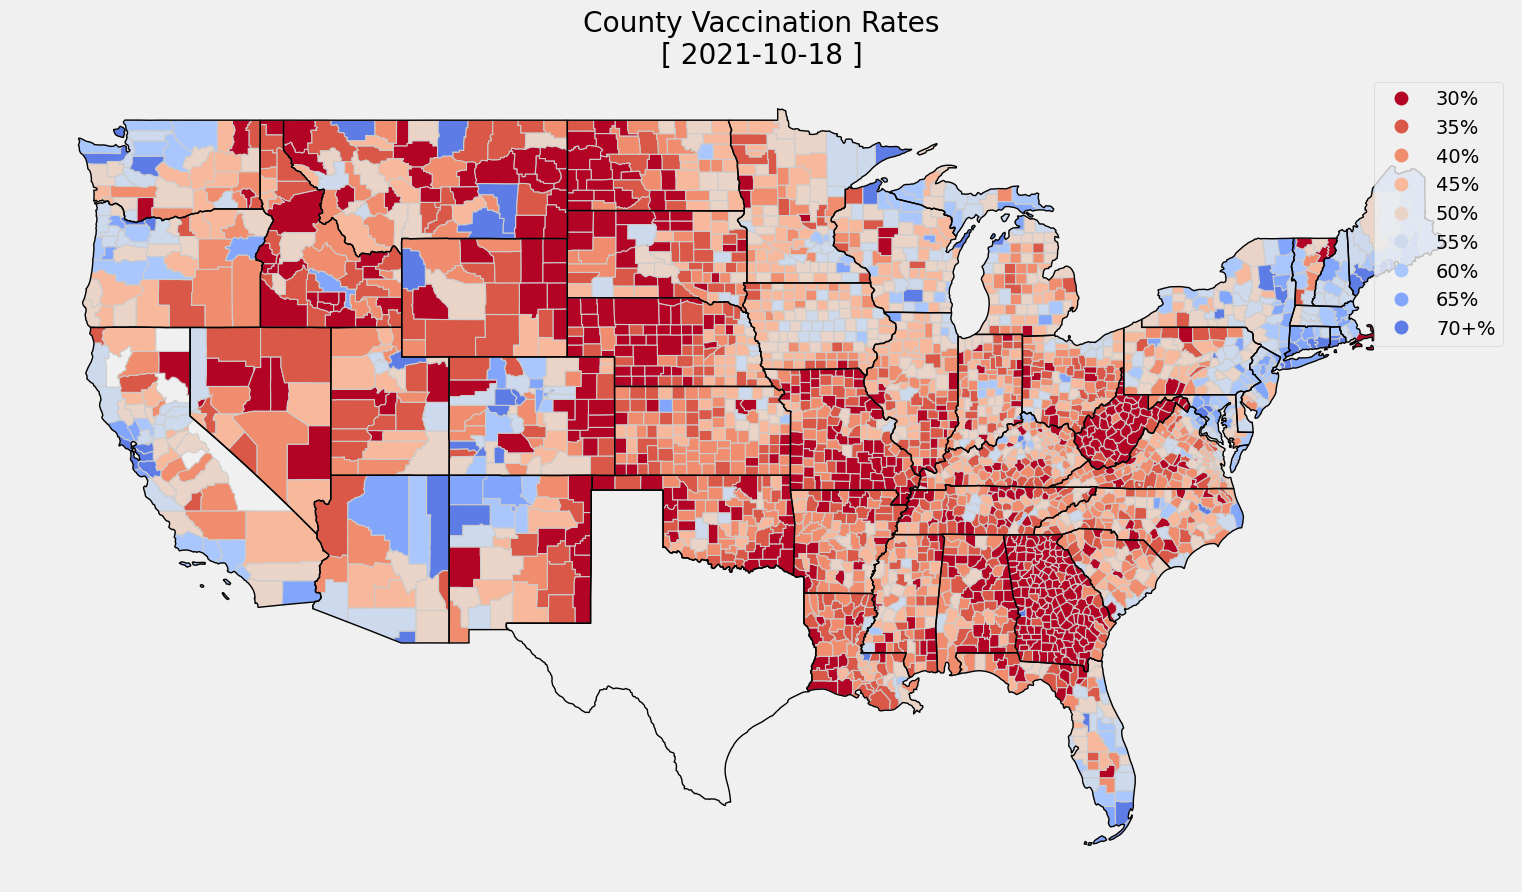

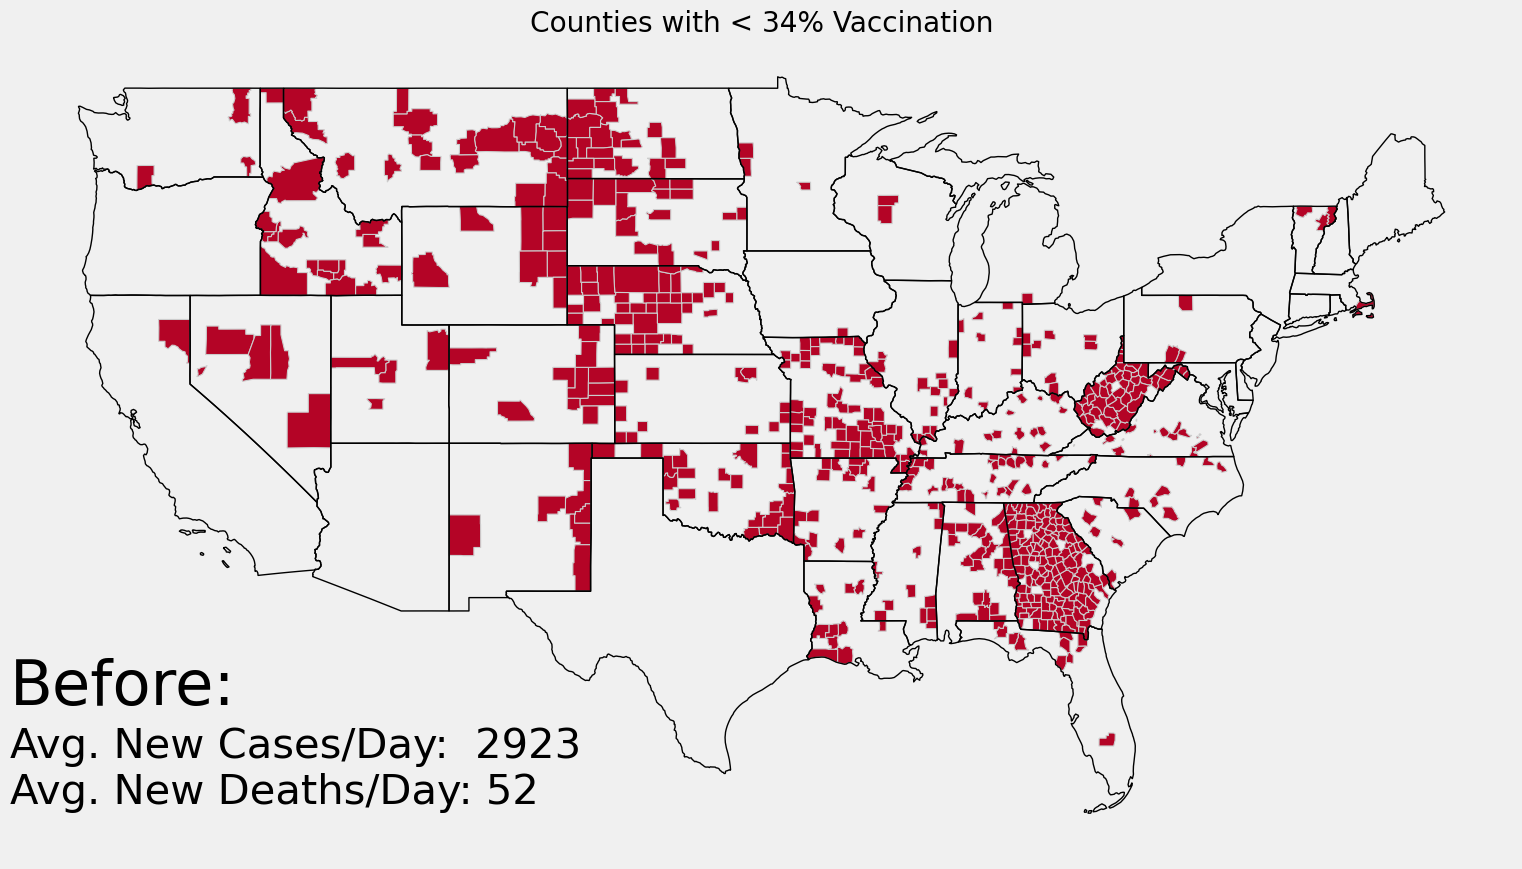

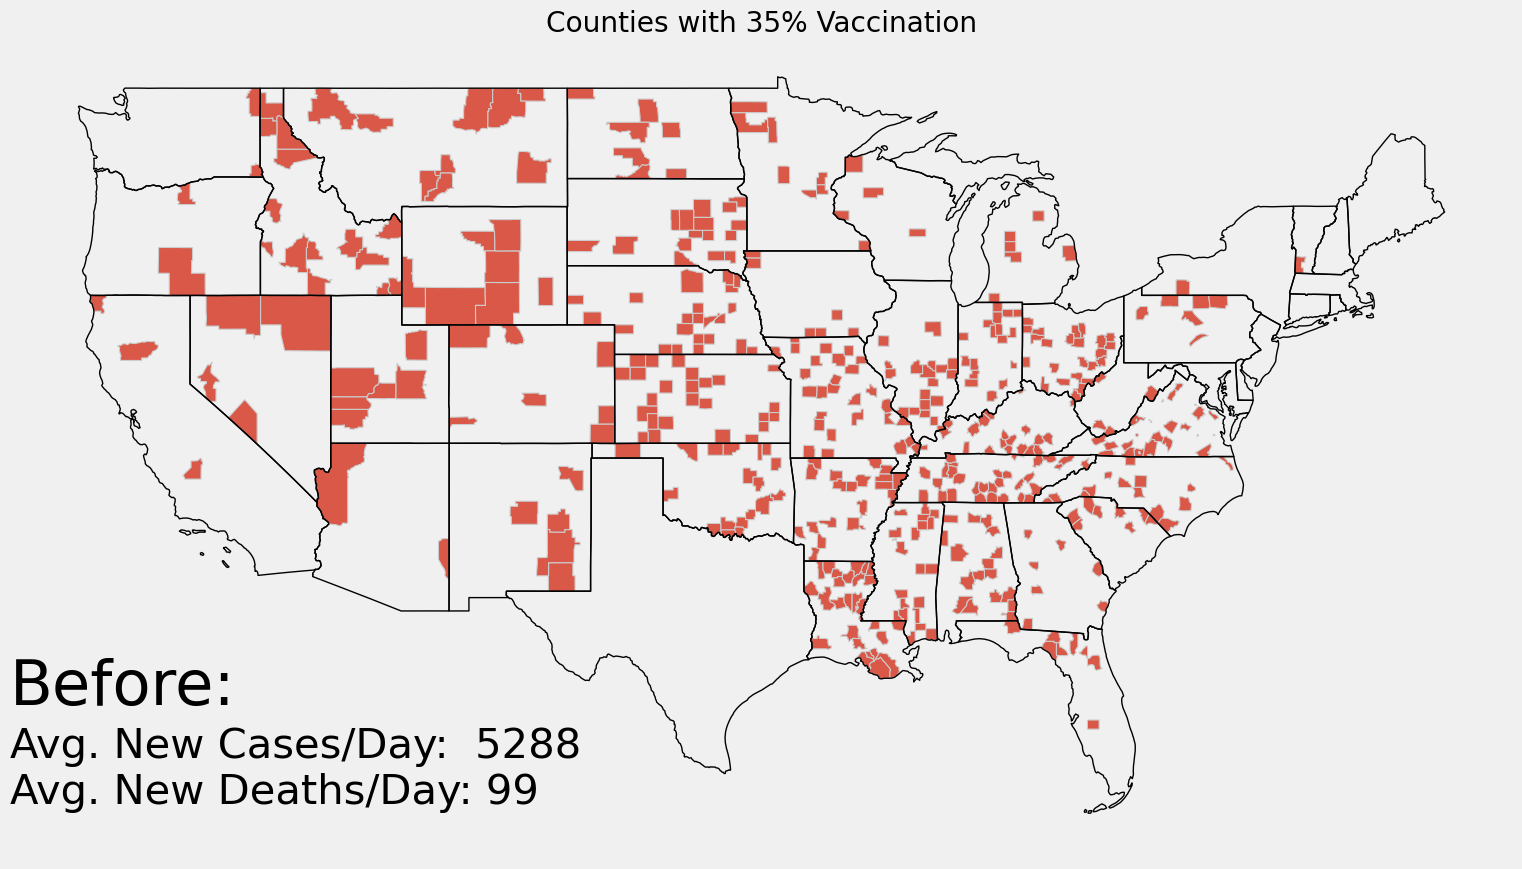

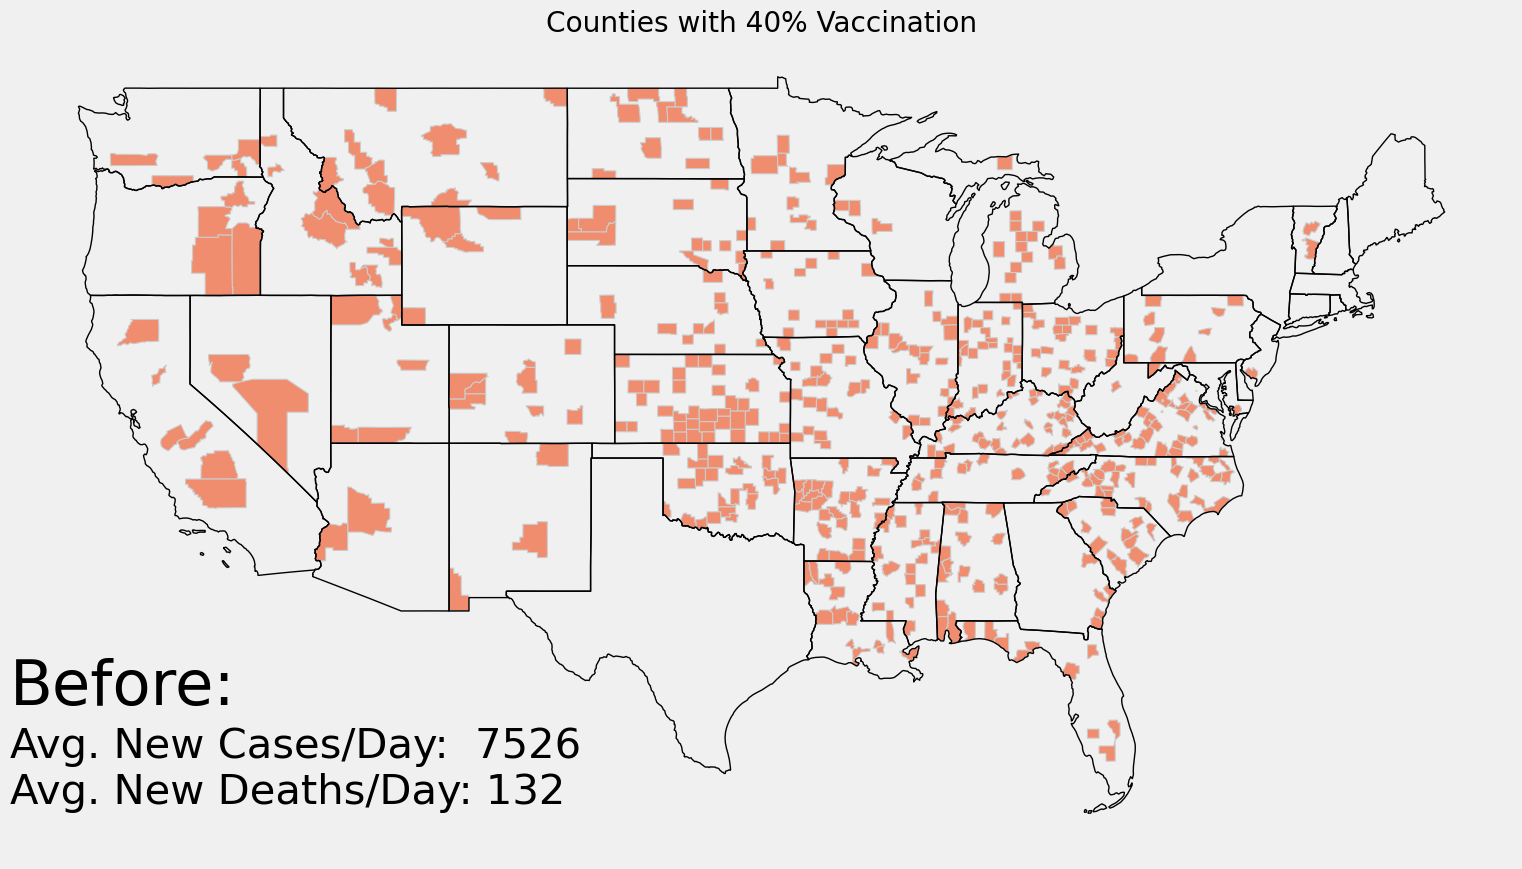

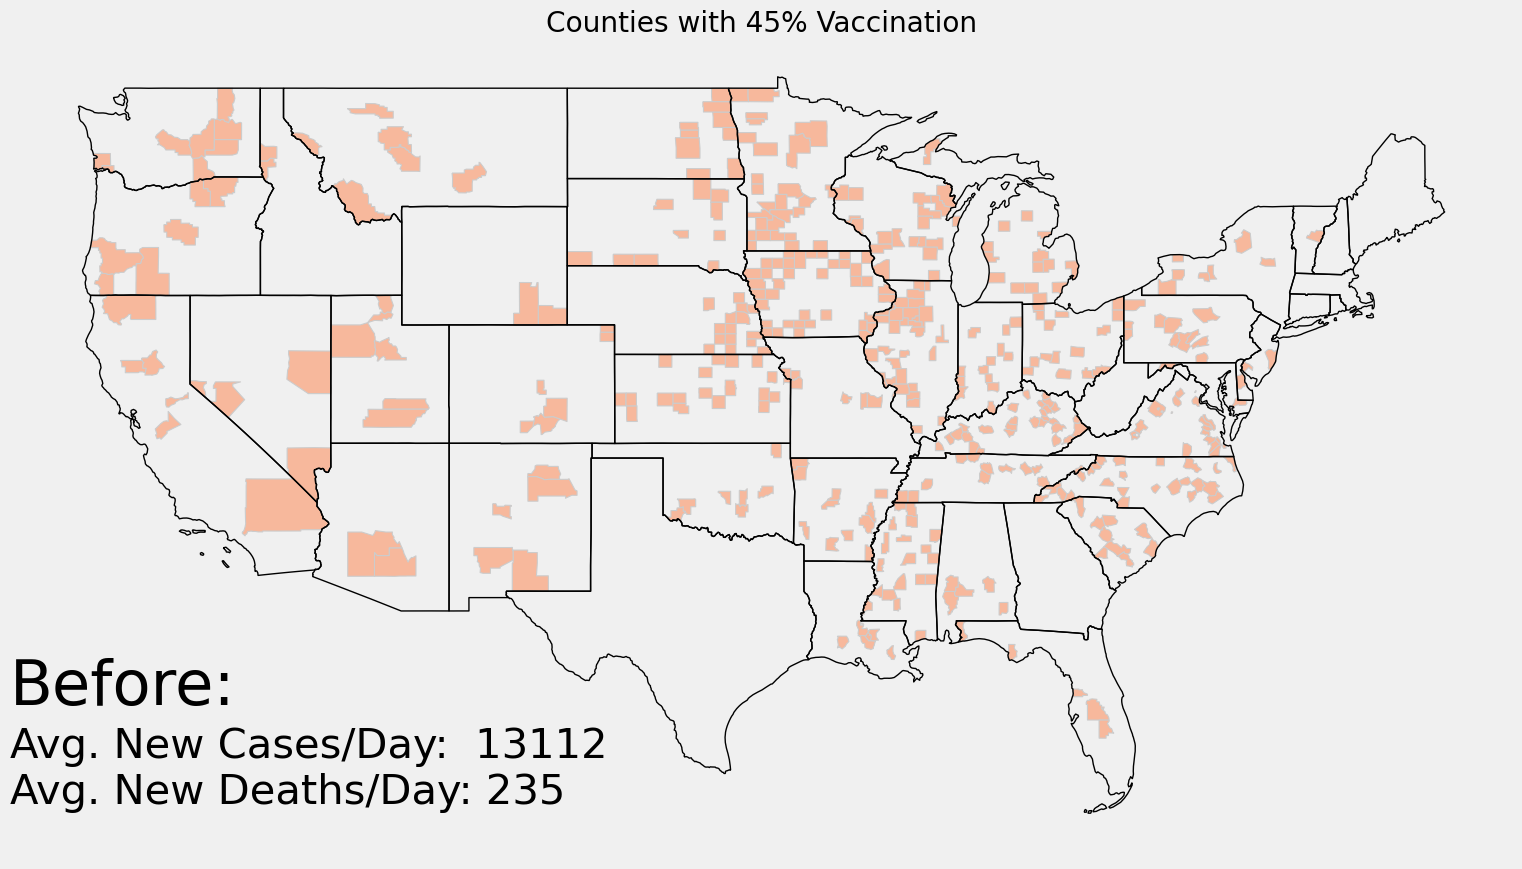

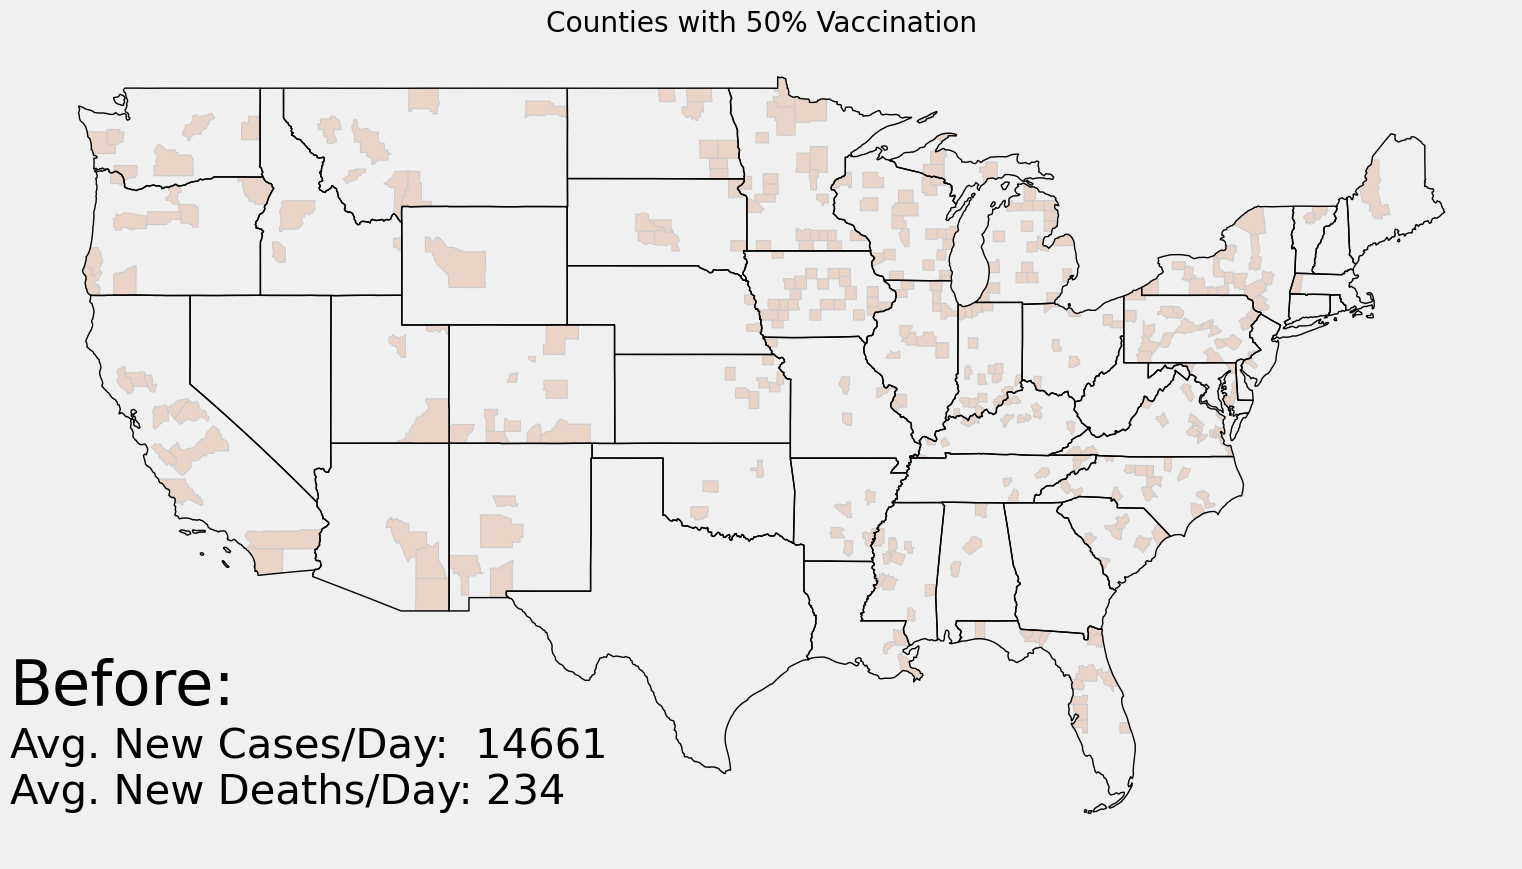

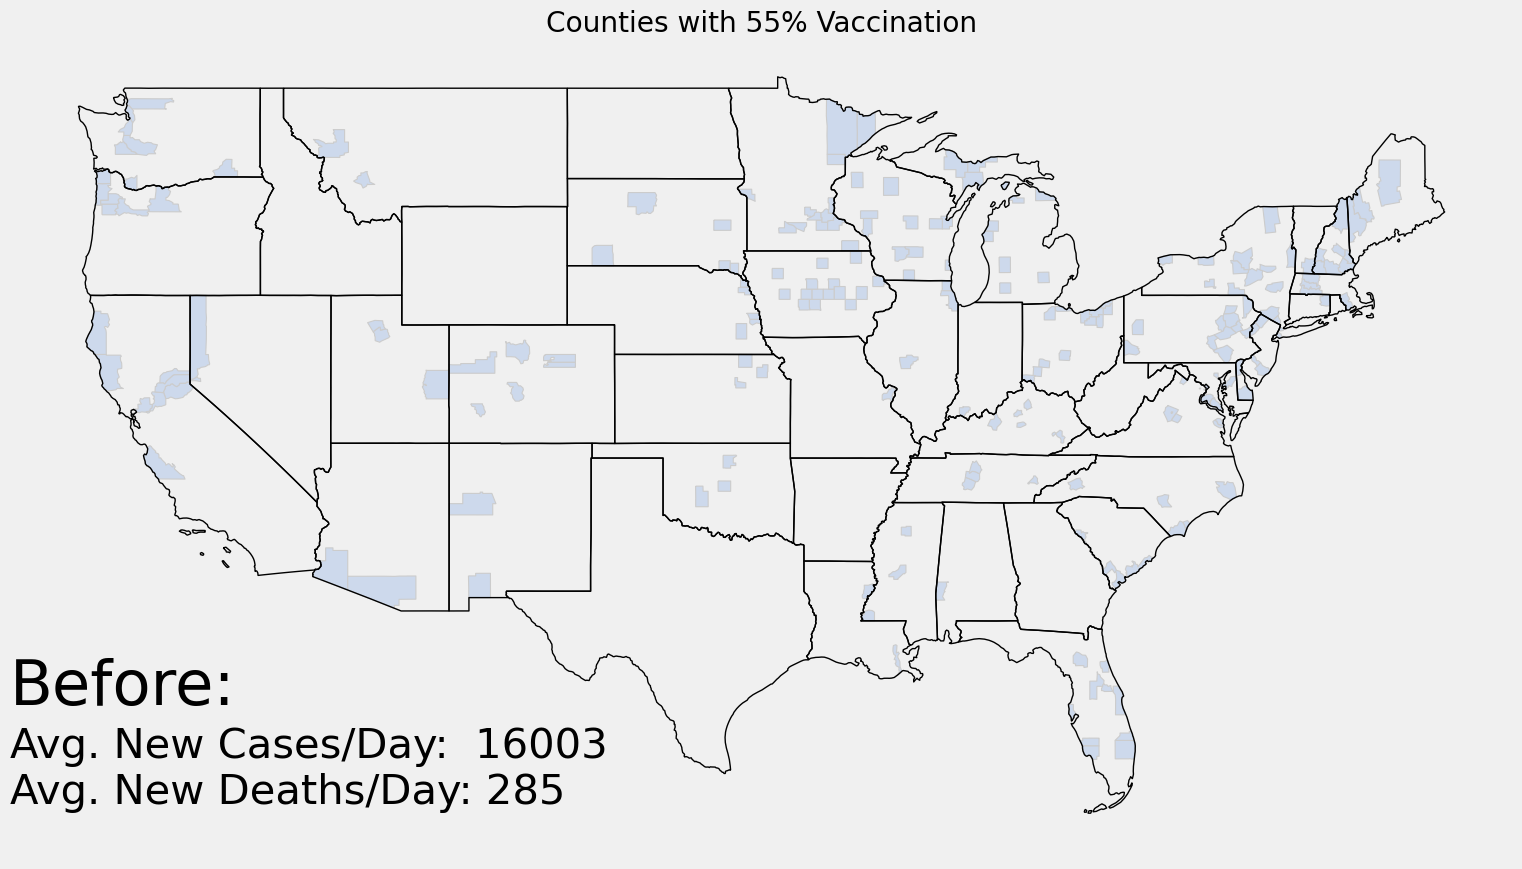

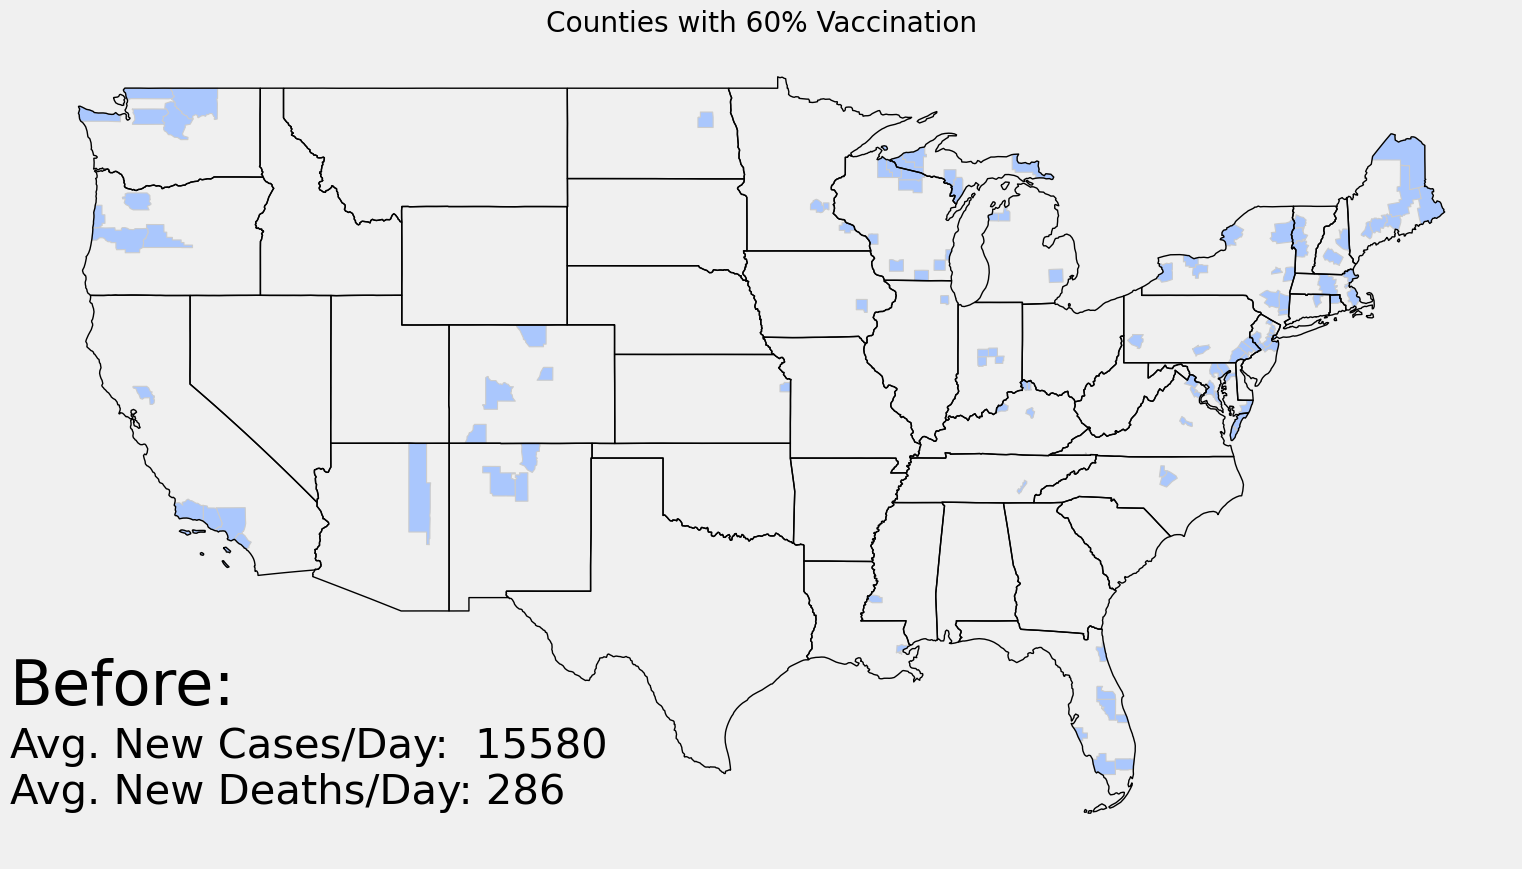

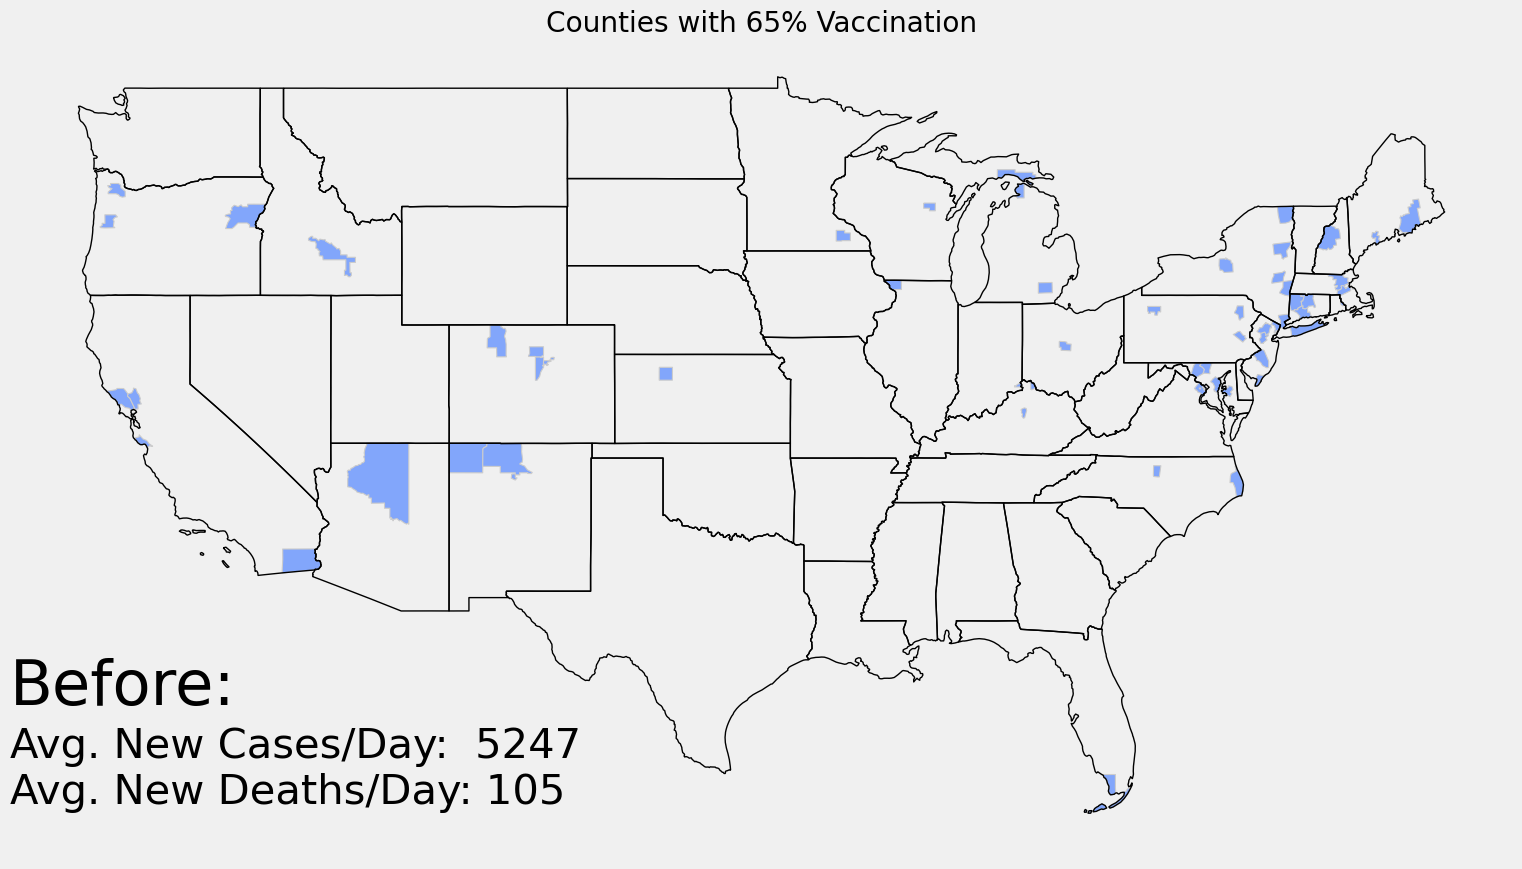

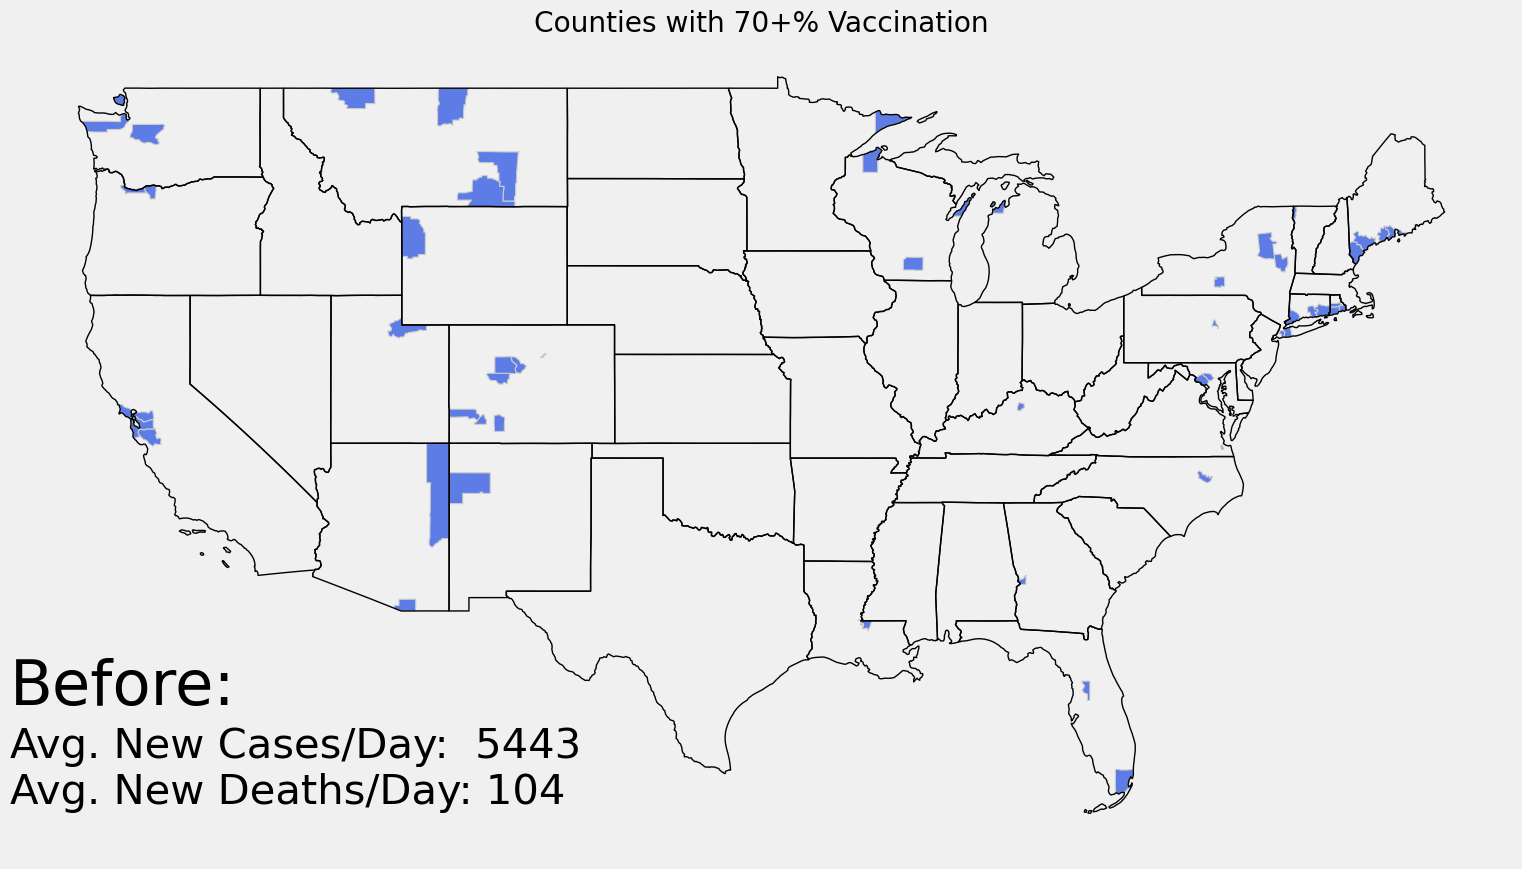

In [270]:

plot_df = geo_county_tier_df.copy()



#//*** Scale the plot to county_summary_df tiers.
#//*** Tiers outside of scope will be binned as max and min values
plot_df['tier'] = plot_df['tier'].str.replace("total_","").astype(int)


max_tier = county_summary_df['tier'].str.replace("total_","").astype(int).max()
min_tier = county_summary_df['tier'].str.replace("total_","").astype(int).min()


plot_df.loc[plot_df["tier"] < min_tier,'tier']=min_tier
plot_df.loc[plot_df["tier"] > max_tier,'tier']=max_tier

plot_df = plot_df.sort_values('tier').reset_index()

#print(plot_df['tier'].unique()[1])
#plot_df = plot_df.sort_values('tier')
plot_df['tier'] = plot_df['tier'].astype(str)
#plot_df['tier'] = plot_df['tier'].str.replace(str(min_tier),"\\< 35")

plot_df['tier'] = plot_df['tier'] + "%"
plot_df['tier'] = plot_df['tier'].str.replace("70%","70+%")
#plot_df['tier'] = plot_df['tier'].str.replace("total_5%","total_05%")


#//*** Assign column to graph
plot_column = 'tier'

#//*** Assign Categories for color palettes
plot_cats = plot_df[plot_column].unique()

#//*** Get a color Palette
item_count = len(plot_cats)
counter_list = []
counter = 0
for x in range(item_count):
    counter += 100 / item_count
    counter_list.append(counter)

vmin=0
vmax=item_count

norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
#colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list[::-1]]
#colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
#colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

#//*** Display Labels for Legend
plot_label_dict = {}



#//*** Generate Label Display Names
#for cat in plot_cats:
#    value = int(cat.replace("total_",""))
#    plot_label_dict[cat] = f"{value}"


colors = {}
counter = 0
for period in plot_dict.keys():
    colors[period] = colors_palette[counter]
    counter+=1

labels=plot_label_dict.values()


labels=list(plot_label_dict.values())
labels=list(plot_cats)
print(labels)
print(county_analysis_dict)
vax_dist_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()].sort_values('Name')

ax = plot_df.plot(column='tier', cmap=ListedColormap(colors_palette),categorical=True,legend=True, linewidth=0.8,edgecolor='0.8')

#//*** Draw State Shapes over top, Set Color to transparant with Black edgecolor
ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)

ax.axis('off')
#plt.suptitle(f"State Vaccination Rates")
plt.title(f"County Vaccination Rates\n[ {summer_county_tier_df['Date'].max()} ]")
fig = plt.gcf()
fig.set_size_inches(20,10)

#print(ax.legend())
#//*** Handles is taken from earlie
#plt.legend(reversed(handles),reversed(labels),loc='lower left', fontsize=12)
#plt.legend(plt.legend().legendHandles)

#outfilename='z_exec_summary_binned_vax_map.jpg'
#out_exec_summary_images.append(outfilename)
#fig.savefig(outfilename)

#out_exec_summary_images.append("z_exec_summary_binned_vax_map.jpg")
plt.show()
#plot_df['tier'] = plot_df['tier'].replace("total_","")

i = 0
for tier in plot_df['tier'].unique():
    disp_df = plot_df[plot_df['tier'] == tier]
    ax = disp_df.plot(column='tier', cmap=ListedColormap(colors_palette[i]),categorical=True,legend=False, linewidth=0.8,edgecolor='0.8',)
    ax = vax_dist_df.plot(categorical=True,legend=True, linewidth=1,edgecolor='black',color=(1,1,1,0),ax=ax)
    fig = plt.gcf()
    fig.set_size_inches(20,10)
    ax.axis('off')
    
    plt.annotate("Before:",(0,.18),xycoords='axes fraction',fontsize=fontsize*3)
    btext=""
    btext+=f"Avg. New Cases/Day:  {int(county_analysis_dict['start_daily_mean_confirm'].iloc[i])}\n"
    btext+=f"Avg. New Deaths/Day: {int(county_analysis_dict['start_daily_mean_death'].iloc[i])}\n"
    
    plt.annotate(btext,(0,0),xycoords='axes fraction',fontsize=fontsize*2)
    
    if tier == '30%':
        plt.title("Counties with < 34% Vaccination")
    
    else:
        plt.title(f"Counties with {tier} Vaccination")
    
    plt.show()
    i += 1



['total_40' 'total_45' 'total_50' 'total_55' 'total_60' 'total_65'
 'total_70']


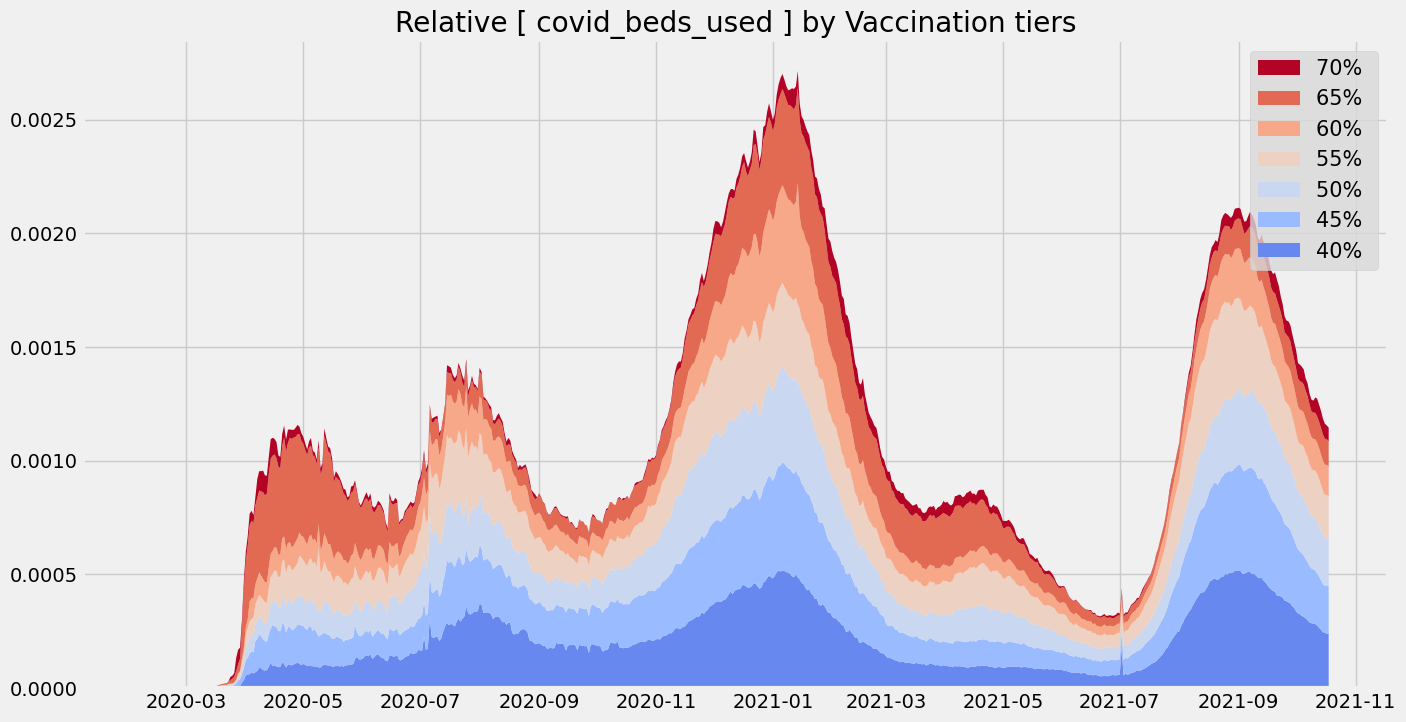

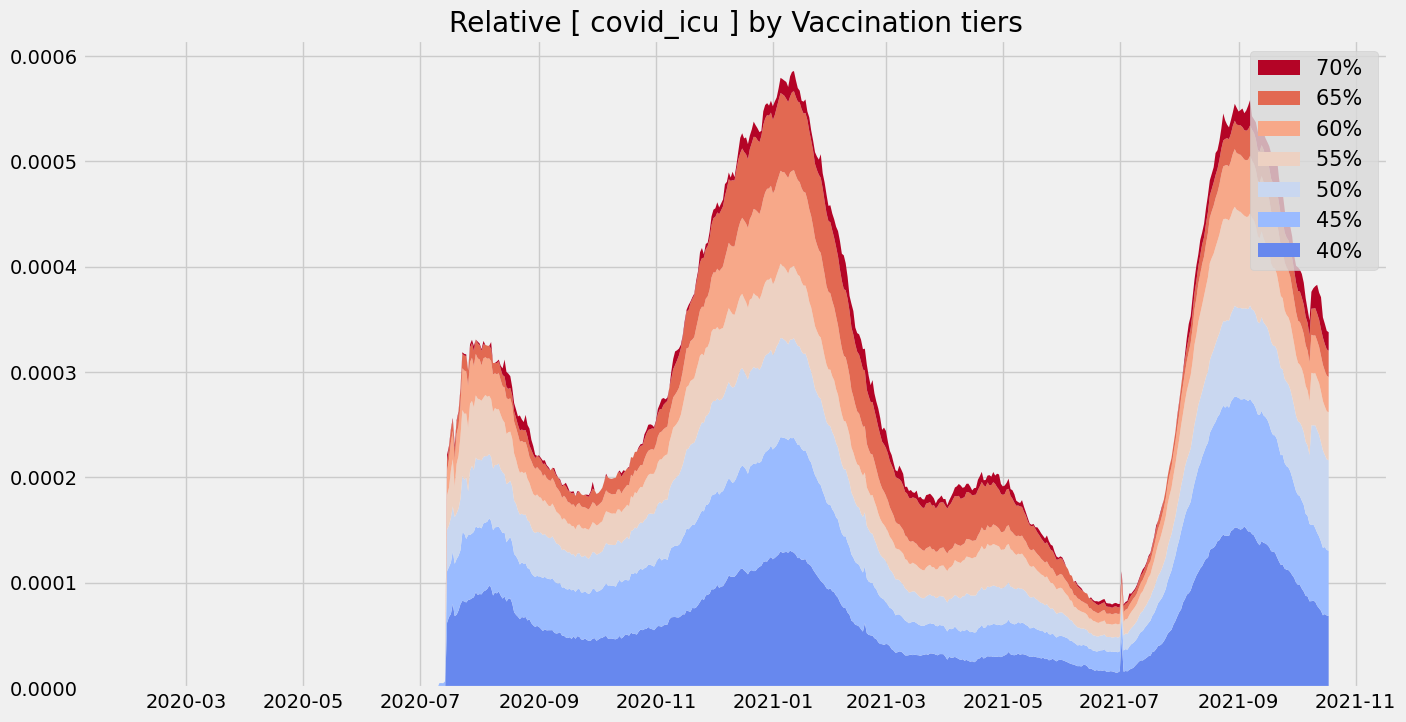

In [43]:

start_summer_date =  datetime(2021, 1, 7).date()

exec_fig_width =15
exec_fig_height=8
fontsize=15

plot_df = state_hosp_tiers_df



plot_dict = {}

#//*** Values for Each Category

#//*** Category is the State Name
category_col = 'tier'
plot_col = 'case_avg_100k'
plot_col = 'total_beds'
plot_col = 'covid_beds_used'
plot_col = 'covid_beds_used'
plot_col = 'icu_used'
plot_col = 'covid_icu'
plot_col2 = 'population'
plot_cats = plot_df[category_col].unique()
print(plot_cats)
for plot_col in ['covid_beds_used','covid_icu']:
    for cat in plot_cats:

        v1 = plot_df[plot_df[category_col] == cat][plot_col].astype(float)
        v2 = plot_df[plot_df[category_col] == cat][plot_col2].astype(float)
        v1 = v1/v2
        #//*** Replace Infinite divide my 0 errors with 0
        plot_dict[cat] = v1



    #//*** Get a color Palette
    item_count = len(plot_cats)
    counter_list = []
    counter = 0
    for x in range(item_count):
        counter += 100 / item_count
        counter_list.append(counter)

    vmin=0
    vmax=item_count

    norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
    #colors_palette = [matplotlib.cm.YlGn(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.YlOrBr(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.Spectral(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.copper(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.Accent(norm(value)) for value in counter_list]
    colors_palette = [matplotlib.cm.coolwarm(norm(value)) for value in counter_list]
    #colors_palette = [matplotlib.cm.OrRd(norm(value)) for value in counter_list]

    #//*** Display Labels for Legend
    plot_label_dict = {}

    #//*** Generate Label Display Names
    for cat in plot_cats:
        value = int(cat.replace("total_",""))
        plot_label_dict[cat] = f"{value}% "


    colors = {}
    counter = 0
    for period in plot_dict.keys():
        colors[period] = colors_palette[counter]
        counter+=1

    labels=key_label_dict.values()


    plt.rcdefaults()
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots()


    fig = plt.gcf()
    fig.set_size_inches(exec_fig_width,exec_fig_height)


    labels=plot_label_dict.values()
    ax.stackplot(plot_df['Date'].unique(), plot_dict.values(),
                 labels=labels,
                 colors=colors_palette,
                )


    plt.title(f'Relative [ {plot_col} ] by Vaccination tiers')
    handles = plt.legend(reversed(plt.legend().legendHandles), reversed(labels),loc='upper right', facecolor='#d9d9d9',fontsize=fontsize).legendHandles


    #outfilename='z_exec_summary_relative_covid_rates_by_vax.jpg'
    #out_exec_summary_images.append(outfilename)
    #fig.savefig(outfilename)
    #handles = plt.legend().legendHandles
    plt.show()



In [44]:
state_hosp_tiers_df

population       Date tot_death tot_confirm New_Cases New_Deaths  case_7_day_avg case_avg_100k  death_7_day_avg death_avg_100k loc                 FIPS      tier total_beds beds_used  \
16      12037305 2020-02-07         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
17      12037305 2020-02-08         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
18      12037305 2020-02-09         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
19      12037305 2020-02-10         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
20      12037305 2020-02-11         0           0         0          0        0.000000           0.0         0.000000            0.0  AL  [1, 16, 28, 54, 56]  total_40        6.0       0.0   
...          ...        ...       ...         ...       ...        ...             ...           ...              ...            ...  ..                  ...       ...        ...       ...   
27343     623989 2021-10-14       342       36503       478          3      471.428571     75.550782         3.857143       0.618143  VT                 [50]  total_70     1222.0     961.0   
27344     623989 2021-10-15       343       36730       378          3      443.714286     71.109312         3.571429       0.572354  VT                 [50]  total_70     1211.0     956.0   
27345     623989 2021-10-16       345       37069       566          3      448.000000     71.796137         3.000000       0.480778  VT                 [50]  total_70     1214.0     924.0   
27346     623989 2021-10-17       345       37318       588          2      465.142857     74.543439         2.857143       0.457884  VT                 [50]  total_70     1214.0     890.0   
27347     623989 2021-10-18       346       37519       450          1      467.571429      74.93264         3.000000       0.480778  VT                 [50]  total_70     1214.0     890.0   

      covid_beds_used icu_total           icu_used covid_icu covid_beds_adult covid_beds_kids case_scaled_100k death_scaled_100k  
16                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
17                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
18                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
19                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
20                0.0       0.0                0.0       0.0              0.0             0.0              0.0               0.0  
...               ...       ...                ...       ...              ...             ...              ...               ...  
27343            47.0     103.0  0.195876288659794      19.0             43.0             4.0        75.550782          0.618143  
27344            44.0      96.0  0.130434782608696      12.0             40.0             4.0        71.109312          0.572354  
27345            41.0      98.0  0.130434782608696      12.0             40.0             1.0        71.796137          0.480778  
27346            38.0      98.0  0.119565217391304      11.0             37.0             1.0        74.543439          0.457884  
27347            38.0      98.0  0.119565217391304      11.0             37.0             1.0         74.93264          0.480778  

[4340 rows x 23 columns]

In [45]:
vax_df = pd.read_csv(vaccine_data_filename)

#//*** Filter Columns to get just the Completed Values
cols = ['Date','Location']
filter_val = ['FedLTC','Unk','Janssen','Pfizer','Moderna','Fed_LTC']
for col in vax_df.columns:
    if 'Complete' in col or 'Dose1' in col:
        skipVal = False
        for val in filter_val:
            if val in col:
                skipVal = True
                continue
        if skipVal:
            continue
        cols.append(col)

#//*** Keep Relevant Data
vax_df = vax_df[cols]

vax_df = vax_df[vax_df["Location"] == 'US' ]
#vax_df['Date'] = 
vax_df['Date'] = pd.to_datetime(vax_df['Date'])

vax_df = vax_df.sort_values('Date')

out_stats

out_stats['total_vaccinated_count'] = format (vax_df.iloc[-1]["Series_Complete_Yes"],',d')
out_stats['total_vaccinated_percent'] = f"{vax_df.iloc[-1]['Series_Complete_Pop_Pct']}%"
out_stats['first_dose_count'] = format (vax_df.iloc[-1]["Administered_Dose1_Recip"],',d')
out_stats['first_dose_percent'] = f"{vax_df.iloc[-1]['Administered_Dose1_Pop_Pct']}%"



- [Graph Interactive: U.S. Vaccinations](#graph_us_vaccinations_by_state)


<a id="graph_us_vaccinations_by_state"></a> 
# Graph: U.S. Vaccinations #

In [46]:
#//********************************************
#//*** Build Current Vaccine Stats
#//********************************************

plot_df = state_daily_df[state_daily_df['Date'] == state_daily_df['Date'].max()]

ren_cols = {
    "total_vaccinated_percent" : "Fully Vaccinated %",
    "first_dose_pct" : "Partially Vaccinated %"
}

cols = plot_df.columns
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)
plot_df.columns = cols

category = "Fully Vaccinated %"

hover_cols = (["Name","Fully Vaccinated %","Partially Vaccinated %"] )
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID Vaccinations\nThrough: {plot_df['Date'].max().date()}",
    #category="New_Cases_9/17/21",
    simplify_shapes=50,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Blues",
    colormap="Cividis",
    hovertool_columns=hover_cols,
    toolbar_location=None,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )

out_plot['vaccine_us_current'] = out_html

- [Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive)](#graph_total_us_vaccination_full_and_partial)


<a id="graph_total_us_vaccination_full_and_partial"></a> 
# Graph: Total U.S. Vaccinations Full and Partial (Line Graph Interactive) #

In [47]:
from bokeh.models import ColumnDataSource
from bokeh.models import DatetimeTickFormatter
from bokeh.embed import components
#https://docs.bokeh.org/en/latest/docs/reference/models/formatters.html
plot_df = vax_df[-30:].copy()
plot_df['Series_Complete_Yes'] = plot_df['Series_Complete_Yes'] / 1000000
plot_df['Administered_Dose1_Recip'] = plot_df['Administered_Dose1_Recip'] / 1000000
plot_df['datelabel'] = plot_df['Date'].dt.strftime("%m/%d")

#plot_df['Series_Complete_Pop_Pct'] = plot_df['Series_Complete_Pop_Pct'].astype(str) + "%"
#plot_df['range']= np.arange(len(plot_df))

ren_cols = {
    "Series_Complete_Pop_Pct" : "Fully_Vaccinated",
    "Administered_Dose1_Pop_Pct" : "Partially_Vaccinated",
    "Series_Complete_Yes" : "Vaccinated",
    "Administered_Dose1_Recip" : "First_Dose",
}

cols = plot_df.columns
for find_col,replace_col in ren_cols.items():
    cols = np.where(cols == find_col,replace_col,cols)
plot_df.columns = cols

plot_df = ColumnDataSource(plot_df)

# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="U.S. Fully Vaccinated (30-Day)",
           toolbar_location=None,
           tools='hover',
           tooltips ="@datelabel @Vaccinated(m)"
          )
p.line(y='Fully_Vaccinated',x='Date',source=plot_df,legend_label="Fully Vaccinated")
p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "%"
p.legend.location = "bottom_right"
show(p)


script, div = components(p)
out_plot['vax_full_30day'] = f"{div}\n {script}"
 
# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="Partially_Vaccinated (30-Day)",
           toolbar_location=None,
           tools='hover',
           tooltips ="@datelabel @Vaccinated(m)"
          )
p.line(y='Partially_Vaccinated',x='Date',color='orange',source=plot_df,legend_label="First Dose")
p.scatter(y='Partially_Vaccinated',x='Date',source=plot_df,color='orange')
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "%"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['vax_partial_30day'] = f"{div}\n {script}"



- [Graph: List States by Highest Current Death rates (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_death_rates"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

In [48]:
death_df = pd.read_csv(death_data_filename)

death_df

death_df['Province_State'].unique()
death_df = death_df[death_df['iso2'] =='US']
death_df = death_df[death_df['Province_State'] != "Diamond Princess"]
death_df = death_df[death_df['Province_State'] != "Grand Princess"]


cols = []

cols.append(death_df.columns[6])
cols.append(death_df.columns[11])
cols = cols+list(death_df.columns[-37:])

death_state_df = pd.DataFrame(columns=cols)

for group in death_df.groupby("Province_State"):
    
   
    tds = group[1][ cols ].sum()
    tds['Province_State'] = group[0]
    #death_state_df=pd.concat([death_state_df,tds],axis=1)
    death_state_df.loc[len(death_state_df.index)] = tds
    
#death_state_df = death_state_df.transpose().reset_index(drop=True)

#death_state_df = death_state_df[ [death_state_df.columns[0]] + list(death_state_df.columns[-30:]) ] 

#//*** Generate New Deaths per Day 7-day average
death_state_df[death_state_df.columns[2:]] = death_state_df[death_state_df.columns[2:]].astype(int).diff(axis = 1, periods = 1)
death_state_df[death_state_df.columns[2:]] = death_state_df[death_state_df.columns[2:]].rolling(7,axis=1).mean()


pop100k = death_state_df['Population'] / 1000000

#for col in death_state_df[death_state_df.columns[2:]]:
#    death_state_df[col] = death_state_df[col] / pop100k

death_state_df = death_state_df.dropna(axis=1)

for col in death_state_df[death_state_df.columns[2:]]:
    death_state_df[col] = death_state_df[col].astype(str)
    death_state_df[col] = death_state_df[col].apply(lambda x : x[:4])
    death_state_df[col] = death_state_df[col].astype(float)

#death_state_df = death_state_df.sort_values(death_state_df.columns[-1],ascending=False)
total_us_deaths = death_state_df[death_state_df.columns[2:]].sum()
#plot_df = death_state_df.iloc[:10].reset_index(drop=True)
#plot_df

death_state_df
plot_df = death_state_df[death_state_df.columns[:2]].copy()
plot_df[death_state_df.columns[-1]] = death_state_df[death_state_df.columns[-1]]
plot_df.columns = ["State","Population","100k"]
plot_df["100k"] = plot_df["100k"] / pop100k
plot_df["100k"] = plot_df["100k"].apply(np.floor)
plot_df = plot_df.sort_values("100k",ascending=True)

date = death_state_df.columns[-1]
#print(plot_df)
#plot_df = ColumnDataSource(plot_df)

#[['Province_State',confirm_state_new_df.columns[-1]]]
labels = list(plot_df['State'])
# create a new plot (with a title) using figure
p = figure(plot_width=int(med_figsize_x*.8), 
           plot_height=med_figsize_y*2,
           y_range=labels,
           title=f"Statewide New Deaths (per 100k) 7 - Day Avg\nUpdated: {date}",
           toolbar_location=None,
           #tools='hover',
           #tooltips =[
           #     ("index", "$index"),
           #    ( "100k",  "@{9/21/21}{%0.2f}" ) ]
          )
#(y='Province_State',x=,source=plot_df,legend_label="Fully Vaccinated")
p.hbar(y=labels, right=list(plot_df[plot_df.columns[-1]]), left=0, height=0.5, fill_color="#b3de69")
#p.add_glyph(plot_df, glyph)

#p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
#p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.xaxis.axis_label = "New Deaths / 100k"
#p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['states_highests_new_deaths'] = f"{div}\n {script}"

- [Graph: US Total New Deaths Per Day (Line Plot)](#graph_US_total_new_deaths_per_day)


<a id="graph_US_total_new_deaths_per_day"></a> 
# Graph: US Total New Deaths Per Day (Line Plot) #

In [49]:
from bokeh.transform import factor_cmap
from bokeh.palettes import Spectral6

plot_df = pd.DataFrame()
plot_df['DateString'] = total_us_deaths.index
plot_df['Date'] = plot_df['DateString'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))
plot_df['Deaths'] = total_us_deaths.values
plot_df['index'] = np.arange(len(total_us_deaths))
plot_df = ColumnDataSource(plot_df)


x = np.arange(len(total_us_deaths))
# create a new plot
p = figure(plot_width=med_figsize_x, 
           plot_height=med_figsize_y, 
           title="U.S. New Deaths Per Day (7-Day Avg)",
           toolbar_location=None,
           tools='hover',
           tooltips =[    
               ( "Date",  "@DateString" ),
               ("Value", "$y{0} / Day"),
           ]
          )


#print(thisRow)
p.line(x="Date", y="Deaths", source=plot_df, alpha=0.8, color='black', line_width=2)
p.circle(x="Date", y="Deaths", source=plot_df, size=10, color='red',alpha=0.5)

p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "Daily Deaths"
#p.legend.location = "bottom_right"

show(p)

#script, div = components(p)
#out_plot['us_new_deaths'] = f"{div}\n {script}"

- [Graph: List States by Highest New Cases (Bar Plot)](#graph_list_states_highest_death_rates)


<a id="graph_list_states_highest_new_cases"></a> 
# Graph: List States by Highest Current Death rates (Bar Plot) #

In [50]:
#//*** Build State Totals
confirm_df = pd.read_csv(confirmed_data_filename)
confirm_df = confirm_df[confirm_df['iso2'] =='US']
confirm_df = confirm_df[confirm_df['Province_State'] != "Diamond Princess"]
confirm_df = confirm_df[confirm_df['Province_State'] != "Grand Princess"]


#state_df = pd.DataFrame(columns=(['Province_State'] + list(confirm_df.columns[11:])))

confirm_state_total_df = pd.DataFrame()

for group in confirm_df.groupby("Province_State"):
    
   
    tds = group[1][ ( [group[1].columns[6]] + list(group[1].columns[11:])) ].sum()
    tds['Province_State'] = group[0]
    confirm_state_total_df=pd.concat([confirm_state_total_df,tds],axis=1)

confirm_state_total_df = confirm_state_total_df.transpose().reset_index(drop=True)

confirm_state_total_df = confirm_state_total_df[ [confirm_state_total_df.columns[0]] + list(confirm_state_total_df.columns[-30:]) ]



confirm_state_total_df['Population'] = death_state_df['Population']
cols = list(confirm_state_total_df.columns)
cols.insert(1,cols[-1])
cols = cols[:-1]
confirm_state_total_df = confirm_state_total_df[cols]
confirm_state_new_df = confirm_state_total_df.copy()

#confirm_df[confirm_df.columns[6:]].diff(axis = 1, periods = 1)
confirm_state_new_df[confirm_state_new_df.columns[2:]] = confirm_state_new_df[confirm_state_new_df.columns[2:]].astype(int).diff(axis = 1, periods = 1)
confirm_state_new_df[confirm_state_new_df.columns[2:]] = confirm_state_new_df[confirm_state_new_df.columns[2:]].rolling(7,axis=1).mean()
                    

confirm_state_new_df = confirm_state_new_df.dropna(axis=1)
pop100k = confirm_state_new_df['Population']/100000




confirm_state_total_df[confirm_state_total_df.columns[2:]] = confirm_state_total_df[confirm_state_total_df.columns[2:]].astype(int).rolling(7,axis=1).mean()
confirm_state_total_df = confirm_state_total_df.dropna(axis=1)

for col in confirm_state_new_df.columns[2:]:
    confirm_state_new_df[col] = confirm_state_new_df[col]/pop100k
    confirm_state_new_df[col] = confirm_state_new_df[col].astype(int)
    #confirm_state_total_df[col+"%"] = confirm_state_total_df[col]/pop100k
    #confirm_state_total_df[col+"%"] = confirm_state_total_df[col].astype(int)
    #confirm_state_total_df[col+"%"] = (confirm_state_total_df[col]/1000).round(2)
    
    

from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot
plot_df=confirm_state_new_df.sort_values(confirm_state_new_df.columns[-1],ascending=True).iloc[:10]
#print(plot_df)
#plot_df = ColumnDataSource(plot_df)
col = plot_df.columns[-1]
print(col)
#[['Province_State',confirm_state_new_df.columns[-1]]]
labels = list(plot_df['Province_State'])
# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           y_range=labels,
           title="Statewide New Cases (per 100k) 7 - Day Avg",
           toolbar_location=None,
           #tools='hover',
           #tooltips =[
           #     ("index", "$index"),
           #    ( "100k",  "@{9/21/21}{%0.2f}" ) ]
          )
#(y='Province_State',x=,source=plot_df,legend_label="Fully Vaccinated")
p.hbar(y=labels, right=list(plot_df[plot_df.columns[-1]]), left=0, height=0.5, fill_color="#b3de69")
#p.add_glyph(plot_df, glyph)

#p.scatter(y='Fully_Vaccinated',x='Date',source=plot_df)
#p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.xaxis.axis_label = "New Cases / 100k"
#p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['states_highests_new_cases'] = f"{div}\n {script}"

#confirm_state_total_df.sort_values(confirm_state_total_df.columns[-1],ascending=False).iloc[:10]

10/18/21


- [Graph: Table of States with Highest Total COVID Counts (Table Plot)](#graph_list_states_highest_total_cases)


<a id="graph_list_states_highest_total_cases"></a> 
# Graph: Table of States with Highest Total COVID Counts (Table Plot) #

In [51]:
confirm_state_total_df=confirm_state_total_df.sort_values(confirm_state_total_df.columns[-1],ascending=False)
plot_df = confirm_state_total_df[['Province_State','Population']].copy()
#plot_df[confirm_state_total_df.columns[-2]] = confirm_state_total_df[confirm_state_total_df.columns[-2]]
plot_df[confirm_state_total_df.columns[-1]] = confirm_state_total_df[confirm_state_total_df.columns[-1]]

#cur_date = confirm_state_total_df.columns[-2]
cur_date = confirm_state_total_df.columns[-1]
plot_df.columns = ['State','Population','Confirmed']
plot_df['%'] = ((plot_df['Confirmed'] / plot_df['Population']) * 100)
plot_df = plot_df.sort_values("%",ascending=False)

plot_df['%'] = plot_df['%'].astype(str)
plot_df['%'] = plot_df['%'].apply(lambda x: x[:5])
plot_df['%'] = plot_df['%'] + "%"


plot_df['Confirmed'] = plot_df['Confirmed'].astype(int).apply(lambda x: "{:,}".format(x))

#plot_df['Confirmed']=  plot_df['Confirmed']
plot_df['Population'] = plot_df['Population'].apply(lambda x: "{:,}".format(x))

plot_df = plot_df.reset_index(drop='True')
plot_df = plot_df.reset_index()
plot_df.columns = ['Rank','State','Population','Confirmed',"%"]
plot_df['Rank'] = plot_df['Rank'] + 1 

out_html = ""
out_html+="<table id='total_confirmed_percent'>"
out_html+="<thead>"
for col in plot_df.columns:
    out_html += f"<td>{col}</td>"

out_html+="</thead>"

for row in plot_df.iterrows():
    out_html+="<tr>"
    for val in row[1]:
        out_html+=f"<td>{val}</td>"
    out_html+="</tr>"
out_html+="</table>"


out_plot['total_confirmed_percent'] = out_html
#print(out_html)
plot_df.iloc[:10]

Rank           State  Population  Confirmed       %
0     1       Tennessee   6,829,174  1,261,695  18.47%
1     2    North Dakota     762,062    140,547  18.44%
2     3  South Carolina   5,148,714    883,272  17.15%
3     4          Alaska     740,995    126,890  17.12%
4     5         Florida  21,477,737  3,656,036  17.02%
5     6    South Dakota     884,659    149,606  16.91%
6     7        Arkansas   3,017,804    505,753  16.75%
7     8         Wyoming     578,759     96,845  16.73%
8     9     Mississippi   2,976,149    497,470  16.71%
9    10    Rhode Island   1,059,361    176,231  16.63%

- [Graph: U.S. Total COVID Cases Trend (Line Plot)](#graph_us_total_covid_cases_trend)


<a id="graph_us_total_covid_cases_trend"></a> 
# Graph: U.S. Total COVID Cases Trend (Line Plot) #

In [52]:

#//*** Build and Plot US Total Confirm Cases and Rolling 7-day
confirm_df = pd.read_csv(confirmed_data_filename)

usa_df = pd.DataFrame(index=['total','7day_avg'],data=[confirm_df[confirm_df.columns[11:]].sum(),confirm_df[confirm_df.columns[11:]].rolling(7).mean().sum()] )

usa_df = usa_df.dropna(axis=1).transpose()
usa_df['7day_avg'] = usa_df['7day_avg'].astype(int)/1000000
usa_df['total'] = usa_df['total'].astype(int)/1000000
usa_df['total'] = usa_df['total'].round(1)
usa_df['Date'] =usa_df.index
usa_df['DateLabel'] =usa_df.index

#//*** Convert date string to datetime
usa_df['Date'] = usa_df['Date'].apply(lambda x: datetime.strptime(x, "%m/%d/%y"))

plot_df = usa_df[-30:]
plot_df


plot_df = ColumnDataSource(plot_df)

# create a new plot (with a title) using figure
p = figure(plot_width=400, 
           plot_height=200,
           title="US Confirmed Cases",
           toolbar_location=None,
           tools='hover',
           tooltips ="@total(m)"
          )
p.line(x='Date',y='total',source=plot_df,legend_label="Total Confirmed Cases")
p.scatter(y='total',x='Date',source=plot_df)
#p.line(x='Date',y='7day_avg',source=plot_df,legend_label="7 Day Average")
p.xaxis.formatter = DatetimeTickFormatter(months = ['%d:%m:%y'])
p.yaxis.axis_label = "(millions)"
p.legend.location = "bottom_right"
show(p)

script, div = components(p)
out_plot['us_confirmed_cases'] = f"{div}\n {script}"

In [53]:
"""
#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
field = 'case_7_day_avg'
plot_df = pd.DataFrame()

i = 0
#//*** Break County from Rows to Columns
for FIPS in county_daily_df['FIPS'].unique():
    
    i += 1
    
    loop_df = county_daily_df[county_daily_df['FIPS'] == FIPS]
    
    tds = loop_df.iloc[:1][['STATEFP','GEOID','NAME','geometry','FIPS']].reset_index()
    #print(tds)
    vals = loop_df[['Date',field]]
    vals.index = vals['Date']
    del vals['Date']
    vals = vals.transpose().reset_index()
    
    plot_df = pd.concat([plot_df,vals])
    
    if i % 100 == 0:
        print(f"Working: {i} of {len(county_daily_df['FIPS'].unique())} - {len(plot_df)}")

    
print("Done")
"""

'\n#//********************************************\n#//*** Build Confirmed Historical Slider Plot\n#//********************************************\nfield = \'case_7_day_avg\'\nplot_df = pd.DataFrame()\n\ni = 0\n#//*** Break County from Rows to Columns\nfor FIPS in county_daily_df[\'FIPS\'].unique():\n    \n    i += 1\n    \n    loop_df = county_daily_df[county_daily_df[\'FIPS\'] == FIPS]\n    \n    tds = loop_df.iloc[:1][[\'STATEFP\',\'GEOID\',\'NAME\',\'geometry\',\'FIPS\']].reset_index()\n    #print(tds)\n    vals = loop_df[[\'Date\',field]]\n    vals.index = vals[\'Date\']\n    del vals[\'Date\']\n    vals = vals.transpose().reset_index()\n    \n    plot_df = pd.concat([plot_df,vals])\n    \n    if i % 100 == 0:\n        print(f"Working: {i} of {len(county_daily_df[\'FIPS\'].unique())} - {len(plot_df)}")\n\n    \nprint("Done")\n'

In [54]:
plot_df = county_daily_df[county_daily_df['Date'] == county_daily_df['Date'].max()]
plot_df

Date   FIPS     Admin2 Province_State              Combined_Key  Population  tot_confirm  tot_deaths  New_Confirm  New_Deaths  case_7_day_avg  death_7_day_avg  case_100k_avg  \
635  2021-10-18   1001    Autauga        Alabama      Autauga, Alabama, US       55869         9904         146          3.0         0.0        7.571429         0.285714      13.552110   
635  2021-10-18   1003    Baldwin        Alabama      Baldwin, Alabama, US      223234        37098         540         11.0         0.0       27.571429         1.142857      12.350909   
635  2021-10-18   1005    Barbour        Alabama      Barbour, Alabama, US       24686         3560          75          4.0         0.0        2.000000         0.142857       8.101758   
635  2021-10-18   1007       Bibb        Alabama         Bibb, Alabama, US       22394         4217          86          0.0         0.0        3.285714         0.000000      14.672297   
635  2021-10-18   1009     Blount        Alabama       Blount, Alabama, US       57826        10104         174          2.0         0.0       12.000000         0.285714      20.751911   
..          ...    ...        ...            ...                       ...         ...          ...         ...          ...         ...             ...              ...            ...   
635  2021-10-18  56043   Washakie        Wyoming     Washakie, Wyoming, US        7805         1603          29         17.0         0.0       11.571429         0.000000     148.256612   
635  2021-10-18  56045     Weston        Wyoming       Weston, Wyoming, US        6927         1002           8         16.0         0.0        6.428571         0.000000      92.804554   
635  2021-10-18  80013  Out of GA        Georgia    Out of GA, Georgia, US           0        42971         968         83.0         5.0       33.428571         5.857143            inf   
635  2021-10-18  80026  Out of MI       Michigan   Out of MI, Michigan, US           0         2316          21         13.0         0.0        8.428571         0.142857            inf   
635  2021-10-18  80047  Out of TN      Tennessee  Out of TN, Tennessee, US           0        29212         132         58.0         0.0       56.857143         0.285714            inf   

     death_100k_avg  case_scaled_100k  death_scaled_100k  
635        0.511400         13.552110           0.511400  
635        0.511955         12.350909           0.511955  
635        0.578697          8.101758           0.578697  
635        0.000000         14.672297           0.000000  
635        0.494093         20.751911           0.494093  
..              ...               ...                ...  
635        0.000000        100.000000           0.000000  
635        0.000000         92.804554           0.000000  
635             inf        100.000000           5.000000  
635             inf        100.000000           5.000000  
635             inf        100.000000           5.000000  

[3147 rows x 16 columns]

In [55]:
"""
out_plot['confirm_historical'] = []
out_root_path = "./project/historical_confirm/"


plot_df = county_daily_df[county_daily_df['Date'] == county_daily_df['Date'].max()]



hover_cols = ["Population","Combined_Key","case_7_day_avg","tot_confirm","total_vaccinated_percent","first_dose_pct","FIPS"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    category="case_scaled_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {county_daily_df['Date'].max()}",
    #slider=slider_columns,
    #slider_range = slider_range,
    #slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
filename = f"{out_root_path}historic_confirm_{county_daily_df['Date'].max()}.raw"
#//*** write raw HTML to output folder
with open(filename, "w") as f:
    print(f"Writing File:{filename}")
    f.write(out_html)
#out_plot['confirm_historical'].append(filename)        
out_plot['confirm_latest'] = out_html
"""

'\nout_plot[\'confirm_historical\'] = []\nout_root_path = "./project/historical_confirm/"\n\n\nplot_df = county_daily_df[county_daily_df[\'Date\'] == county_daily_df[\'Date\'].max()]\n\n\n\nhover_cols = ["Population","Combined_Key","case_7_day_avg","tot_confirm","total_vaccinated_percent","first_dose_pct","FIPS"]\n\ntooltips =[\n   ("index", "$index"),    \n   ( "Date",  "@Date" ),\n   ("Value", "$y{0}/Day"),\n]\n\nslider_name = "COVID Day"\n\nout_html = plot_df.plot_bokeh(\n    figsize=(med_figsize_x*2, med_figsize_y*2),\n    category="case_scaled_100k",\n    title = f"U.S. COVID Prevalence (Cases per 100k Population): {county_daily_df[\'Date\'].max()}",\n    #slider=slider_columns,\n    #slider_range = slider_range,\n    #slider_name = slider_name,\n    toolbar_location=None,\n    #title = "TITLE HERE",\n    #category="New_Cases_9/17/21",\n    #simplify_shapes=5000,\n    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],\n    colormap="Viridis",\n    #colormap="Inferno",\n    hovertoo

In [56]:
#//********************************************
#//*** Build Confirmed Current Stats Plot
#//********************************************
plot_df = attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))].copy()

category = plot_df.columns[-1]

hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Case Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    hovertool_columns=hover_cols,
    show_figure=True,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_latest'] = out_html

In [57]:


#//********************************************
#//*** Build Confirmed Historical Slider Plot
#//********************************************
plot_df = attrib_confirm_df.copy()
    

slider_columns = [f"{x}_scaled_100k" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

tooltips =[
   ("index", "$index"),    
   ( "Date",  "@Date" ),
   ("Value", "$y{0}/Day"),
]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Prevalence (Cases per 100k Population): {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    toolbar_location=None,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    hovertool_columns=hover_cols,
    #tooltips=tooltips,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_historical'] = out_html

In [58]:
attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))]

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  10/18/21_New_Cases  10/18/21_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   6                           19   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  18                           29   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                 163                           30   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   1                           18   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                   9                           23   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                 ...                          ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                   1                            6   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                   2                           35   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                   3                           19   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  32                           36   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                   4                           16   

      10/18/21_scaled_100k  
0                       19  
1                       29  
2                       30  
3                       18  
4                       23  
...                    ...  
3137                     6  
3138                    35  
3139                    19  
3140                    36  
3141                    16  

[3108 rows x 11 columns]

In [59]:
#//********************************************
#//*** Build Confirmed Current Stats Plot
#//********************************************
plot_df = attrib_confirm_df[(list(attrib_confirm_df.columns[:8]) + list(attrib_confirm_df.columns[-3:]))].copy()

category = plot_df.columns[-1]

hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))
#hover_cols = ["Loc","Population"]
out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Case Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['confirm_latest'] = out_html

In [60]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  10/18/21_New_Cases  10/18/21_New_Cases_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   6                           19   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                  18                           29   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                 163                           30   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   1                           18   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                   9                           23   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                 ...                          ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                   1                            6   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                   2                           35   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                   3                           19   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                  32                           36   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                   4                           16   

      10/18/21_scaled_100k  
0                       19  
1                       29  
2                       30  
3                       18  
4                       23  
...                    ...  
3137                     6  
3138                    35  
3139                    19  
3140                    36  
3141                    16  

[3108 rows x 11 columns]

In [61]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL GIF
#//*********************************
#//*********************************
rebuild_all_images = False

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if not use_cached_files:

    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/base_gif_1/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_confirm_df.copy()

    fontsize=20

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True

    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        save_filename = f"{filepath}confirm_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                print(f"Skipping: {save_filename}")
                
                #//*** Read Files and Prepare Animated GID
                if first == True:
                    first=False
                    first_img = Image.open(save_filename)
                else:
                    gif_files.append(Image.open(save_filename))
                continue
                
                
        fig, ax = plt.subplots()

        fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.viridis(), norm=plt.Normalize(vmin=0, vmax=100))

        # empty array for the data range
        sm._A = []
        


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Prevalence\nNew Cases per 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})

        plt.close()

        #//*** Read Files and Prepare Animated GID
        if first == True:
            first=False
            first_img = Image.open(save_filename)
        else:
            gif_files.append(Image.open(save_filename))
    
    print("Building GIF...")
    #//*** Build and Save Animated GIF
    first_img.save("confirm_100k_history.gif", save_all=True, optimize=True, append_images=gif_files, duration=50, loop=0)

    out_images.append("confirm_100k_history.gif")


    print("Done...")

In [62]:
#//********************************************
#//*** Build Deaths Current Stats Plot
#//********************************************
plot_df = attrib_death_df[(list(attrib_death_df.columns[:8]) + list(attrib_death_df.columns[-3:]))].copy()



category = plot_df.columns[-1]

#//*** Assign Max Scale Value 5
plot_df.loc[plot_df[category] > 5,category]=5

hover_cols = ["Loc","Population"]
hover_cols = (["Loc","Population"] + list(plot_df.columns[-3:-1]))

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x, med_figsize_y),
    category=category,
    title = f"Current COVID New Death Prevalence (per 100k population) 7-Day Average\nUpdated: {all_dates[-1]}",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    colormap="Magma",
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )

out_plot['death_latest'] = out_html

In [63]:
plot_df
attrib_death_df[(list(attrib_death_df.columns[-10:]))]

10/15/21_scaled_100k  10/16/21_New_Deaths  10/16/21_New_Deaths_per_100k  10/16/21_scaled_100k  10/17/21_New_Deaths  10/17/21_New_Deaths_per_100k  10/17/21_scaled_100k  10/18/21_New_Deaths  \
0                        0                    0                             0                     0                    0                             0                     0                    0   
1                        1                    0                             1                     1                    0                             1                     1                    0   
2                        0                    0                             0                     0                    0                             0                     0                    0   
3                        0                    0                             0                     0                    0                             0                     0                    0   
4                        1                    0                             2                     2                    0                             2                     2                    0   
...                    ...                  ...                           ...                   ...                  ...                           ...                   ...                  ...   
3137                     1                    0                             1                     1                    0                             1                     1                    0   
3138                     0                    0                             0                     0                    0                             0                     0                    0   
3139                     0                    0                             0                     0                    0                             0                     0                    0   
3140                     1                    1                             1                     1                    1                             1                     1                    1   
3141                     2                    0                             2                     2                    0                             2                     2                    0   

      10/18/21_New_Deaths_per_100k  10/18/21_scaled_100k  
0                                0                     0  
1                                1                     1  
2                                0                     0  
3                                0                     0  
4                                2                     2  
...                            ...                   ...  
3137                             1                     1  
3138                             0                     0  
3139                             0                     0  
3140                             1                     1  
3141                             2                     2  

[3108 rows x 10 columns]

In [64]:
#//********************************************
#//*** Build Death Historical Slider Plot
#//********************************************
plot_df = attrib_death_df.copy()

#//*** Assign Max Scale Value 5
for col in [f"{x}_scaled_100k" for x in all_dates]:
    plot_df.loc[plot_df[col] > 5,col]=5

#//*** Assign Max Scale Value 100 is too much
#for col in [f"{x}_New_Deaths" for x in all_dates]:
#    plot_df.loc[plot_df[col] > 10,col]=20
#    plot_df.loc[plot_df[col] < 0,col]=0
    
    
slider_columns = [f"{x}_scaled_100k" for x in all_dates]
#slider_columns = [f"{x}_New_Deaths" for x in all_dates]

slider_range = all_dates
slider_range = [i for i in range(0,len(all_dates))]

#hover_cols = ["Population","Loc"]
#for x in [x*(int(len(all_dates)/8)) for x in range(1,9)]:
#    hover_cols.append(f"{all_dates[x]}_New_Cases")
#    hover_cols.append(f"{all_dates[x]}_New_Cases_per_100k")
hover_cols = ["Population","Loc"]

slider_name = "COVID Day"

out_html = plot_df.plot_bokeh(
    figsize=(med_figsize_x*2, med_figsize_y*2),
    #category="scale_100k",
    title = f"U.S. COVID Death Prevalence (Cases per 100k Population) 7-Day Average: {all_dates[0]} - {all_dates[-1]}",
    slider=slider_columns,
    slider_range = slider_range,
    slider_name = slider_name,
    #title = "TITLE HERE",
    #category="New_Cases_9/17/21",
    #simplify_shapes=5000,
    #dropdown=["POPESTIMATE2010", "POPESTIMATE2017"],
    #colormap="Viridis",
    #colormap="Inferno",
    toolbar_location=None,
    colormap="Magma",
    hovertool_columns=hover_cols,
    show_figure=False,
    return_html=True
    #tile_provider_url=r"http://c.tile.stamen.com/watercolor/{Z}/{X}/{Y}.jpg"
    )
out_plot['death_historical'] = out_html

In [65]:
#//*********************************
#//*********************************
#//*** RENDER HISTORICAL Death GIF
#//*********************************
#//*********************************

#//*** Only Render Animated GIF if not using Cached values...ie during an update.
if not use_cached_files:
#if True:
    #//********************************************
    #//*** Build Output Filepath
    #//********************************************
    filepath = os.getcwd()
    filepath = filepath.replace("\\","/")
    filepath = f"{filepath}/project/base_gif_death_1/"

    files_jpg = []
    gif_files = []
    #//********************************************


    plot_df = attrib_death_df.copy()

    fontsize=20

    dates = all_dates[100:]
    #dates = all_dates[-30:]

    first=True
    first_img = None
    file_counter = 0
    print("Working...")
    for date in dates:

        file_counter += 1

        
        save_filename = f"{filepath}death_hist_{file_counter}.jpg"
        if rebuild_all_images == False:
            #//*** Check If File already Exists, If yes....Skip it.
            if os.path.exists(save_filename):
                print(f"Skipping: {save_filename}")
                
                #//*** Read Files and Prepare Animated GID
                if first == True:
                    first=False
                    first_img = Image.open(save_filename)
                else:
                    gif_files.append(Image.open(save_filename))
                continue
                
        fig, ax = plt.subplots()

        fig.set_size_inches(20,10)
        fig = plt.gcf()
        ax.axis('off')

        # Create colorbar as a legend
        sm = plt.cm.ScalarMappable(cmap=plt.magma(), norm=plt.Normalize(vmin=0, vmax=5))

        # empty array for the data range
        sm._A = []


        cbar = fig.colorbar(sm,shrink=.7)

        #plt.title("Cumulative COVID Prevalence",fontsize=display_size)
        #fig.text(.78, .2, 'Cumulative Cases (per 100k)', va='center' ,fontsize=display_size/2)
        plot_df.plot(column=f'{date}_scaled_100k', ax=ax,linewidth=0.8,edgecolor='.8')
        plt.title(f"COVID-19 Daily Deaths \nper 100,000 Population (7-Day Average)",fontsize=fontsize)
        plt.text(-120,25,date,fontsize=fontsize)
        plt.viridis()

        
        print(save_filename)
        plt.savefig(save_filename,pil_kwargs={'quality': 95})
        #plt.show()
        plt.close()
        
        #//*** Read Files and Prepare Animated GID
        if first == True:
            first=False
            first_img = Image.open(save_filename)
        else:
            gif_files.append(Image.open(save_filename))
    print("Building Animated GIF...")
    #//*** Build and Save Animated GIF
    first_img.save("confirm_100k_history_deaths.gif", save_all=True, optimize=True, append_images=gif_files, duration=50, loop=0)

    out_images.append("confirm_100k_history_deaths.gif")


    print("Done...")

In [66]:
#out_images.append("confirm_100k_thumb.gif")
#out_images.append("confirm_100k_history.gif")

In [67]:

#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


for filename,html in out_plot.items():
    
    
    #//*** write raw HTML to output folder
    with open(f"{directory_path}{filename}.raw" , "w") as f:
        print(f"Writing File:{directory_path}{filename}.raw")
        f.write(html)

for filename in out_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")


Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vaccine_us_current.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vax_full_30day.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/vax_partial_30day.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/states_highests_new_deaths.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/states_highests_new_cases.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/total_confirmed_percent.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/us_confirmed_cases.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/confirm_latest.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/confirm_historical.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/death_latest.raw
Writing File:C:/Users/stonk013//kstoneburner.github.io/DSC640/death_historical.raw


In [68]:
#//****************************************************************************************
#//*** Update the HTML Template, by inserting Graph code into the template placeholders
#//*** Keeps things smooth(ish)
#//****************************************************************************************

import os
#//****************************************************************************************
#//*** Copy the HTML/Javascript & Animated GIFs o the Website Production Folder
#//****************************************************************************************
directory_path = os.getcwd()

directory_path = directory_path.replace("\\","/")

#//*** Remove two sublevels to get to github root
directory_path = "".join(f"{x}/" for x in directory_path.split("/")[:-2])

#//*** Add in Fixed Relative path
directory_path += "/kstoneburner.github.io/DSC640/"


input_template_filename = "covid_dash_v1.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()

#//******************************************************
#//*** Replace template values with out_plot keys
#//******************************************************
#//*** Replace Each Value in Replace_vals
for find in out_plot.keys():

    replace_filename = f"{find}.raw"
    
    with open(f"{directory_path}{replace_filename}" , "r") as f:
        find = f"$${find}$$"
        #//*** Replace the find val (placeholder) with the HTML file
        template_text = template_text.replace(find,f.read())
        
#//*** Replace Bokeh Network calls with local calls

template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-2.4.0.min.js","bokeh/bokeh-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-gl-2.4.0.min.js","bokeh/bokeh-gl-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-widgets-2.4.0.min.js","bokeh/bokeh-widgets-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-tables-2.4.0.min.js","bokeh/bokeh-tables-2.4.0.min.js")
template_text = template_text.replace("https://cdn.bokeh.org/bokeh/release/bokeh-mathjax-2.4.0.min.js","bokeh/bokeh-mathjax-2.4.0.min.js")
        
    
for find,replace in out_stats.items():
    template_text = template_text.replace(f"$${find}$$",replace)

#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)


In [69]:
summer_overview_state_dict
out_exec_summary ={}

#//*** Build the State Summary Table
state_summary ={}
#//*** Display Intervals 40%,45%...etc
state_summary['levels'] = [f'{x.replace("total_","")}%' for x in list(summer_overview_state_dict.keys())]
state_summary['states'] =[]
state_summary['pct'] = []
for key,value in summer_overview_state_dict.items():
    state_summary['states'].append(", ".join(value['states']))
    state_summary['pct'].append(f"{round(value['pop_pct']*100,1)}%")
out_table=""
out_table+="<table>"
out_table+="<thead>"
for val in state_summary['levels']:
    out_table += f"<td>{val}</td>"
out_table+="</thead>"
out_table+="<tr>"
for val in state_summary['states']:
    out_table += f"<td>{val}</td>"
out_table+="</tr>"
#out_table+="<tr>"
#for val in state_summary['pct']:
#    out_table += f"<td>{val}\r\nU.S. Pop</td>"
#out_table+="</tr>"
out_table+="</table>"

out_exec_summary['summary_table'] = out_table
summer_overview_state_dict

{'total_40': {'population': 12037305,
  'pop_pct': 0.03679124653005932,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-18 00:00:00'),
  'confirm_period': 1043870,
  'confirm_start': 906808,
  'confirm_end': 1950678,
  'confirm_period_100k': 8671.95771811049,
  'confirm_deaths': 20013,
  'death_period_100k': 166.25814499175686,
  'vax_complete': 5241926,
  'vax_complete_100k': 43547.338876933,
  'vax_partial': 6180061,
  'vax_partial_100k': 51340.90230329795,
  'states': ['Alabama', 'Idaho', 'Mississippi', 'West Virginia', 'Wyoming']},
 'total_45': {'population': 48919367,
  'pop_pct': 0.14951889076429056,
  'date_start': Timestamp('2021-01-07 00:00:00'),
  'date_end': Timestamp('2021-10-18 00:00:00'),
  'confirm_period': 4003320,
  'confirm_start': 3757311,
  'confirm_end': 7760631,
  'confirm_period_100k': 8183.507362227316,
  'confirm_deaths': 63666,
  'death_period_100k': 130.14477476783378,
  'vax_complete': 23474356,
  'vax_complete_100k': 47985

In [70]:



deaths_low = 10000
confirm_low = 10000
deaths_high = 0
confirm_high = 0
for key,value in summer_overview_state_dict.items():
    if summer_overview_state_dict[key]['death_period_100k'] > deaths_high:
        deaths_high = summer_overview_state_dict[key]['death_period_100k']

    if summer_overview_state_dict[key]['death_period_100k'] < deaths_low:
        deaths_low = summer_overview_state_dict[key]['death_period_100k']
        
    if summer_overview_state_dict[key]['confirm_period_100k'] > confirm_high:
        confirm_high = summer_overview_state_dict[key]['confirm_period_100k']

    if summer_overview_state_dict[key]['confirm_period_100k'] < confirm_low:
        confirm_low = summer_overview_state_dict[key]['confirm_period_100k']


#print(deaths_high,deaths_low,confirm_high,confirm_low)
fewer_death_percent = f"{round((1 - deaths_low / deaths_high)*100,1)}%"
fewer_cases_percent = f"{round((1 - confirm_low / confirm_high)*100,1)}%"
#print(fewer_death_percent, fewer_cases_percent)

exec_summary_variable_update = {
    "confirm_low" : str(int(confirm_low)),
    "confirm_high" : str(int(confirm_high)),
    "deaths_low" : str(int(deaths_low)),
    "deaths_high" : str(int(deaths_high)),
    "fewer_death_percent" : fewer_death_percent,
    "fewer_cases_percent" : fewer_cases_percent
}



In [71]:
input_template_filename = "covid_vaccine_results.template.html"
output_html_filename = input_template_filename.replace(".template","")


#//*** Load the Template
with open(f"{directory_path}{input_template_filename}" , "r") as f:
    template_text = f.read()
    
    
    #//*** Update 
out_exec_summary_images

for filename in out_exec_summary_images:
    shutil.copyfile(filename, f"{directory_path}{filename}")

for find, replace in out_exec_summary.items():
    template_text = template_text.replace(f"$${find}$$",replace)

for find, replace in exec_summary_variable_update.items():

    template_text = template_text.replace(f"$${find}$$",replace)
    
#//*** Write the updated text to file
with open(f"{directory_path}{output_html_filename}" , "w") as f:
    f.write(template_text)

In [72]:
plot_df

STATEFP  GEOID      NAME                                           geometry  Province_State                     Loc  Population  pop_100k  1/29/20_New_Deaths  1/29/20_New_Deaths_per_100k  \
0         37  37017    Bladen  POLYGON ((-78.90200 34.83527, -78.79960 34.850...  North Carolina  Bladen, North Carolina       32722   0.32722                   0                            0   
1         37  37167    Stanly  POLYGON ((-80.49737 35.20210, -80.29542 35.502...  North Carolina  Stanly, North Carolina       62806   0.62806                   0                            0   
2         39  39153    Summit  POLYGON ((-81.68699 41.13596, -81.68495 41.277...            Ohio            Summit, Ohio      541013   5.41013                   0                            0   
3         42  42113  Sullivan  POLYGON ((-76.81373 41.59003, -76.22014 41.541...    Pennsylvania  Sullivan, Pennsylvania        6066   0.06066                   0                            0   
4         48  48459    Upshur  POLYGON ((-95.15274 32.66095, -95.15211 32.902...           Texas           Upshur, Texas       41753   0.41753                   0                            0   
...      ...    ...       ...                                                ...             ...                     ...         ...       ...                 ...                          ...   
3137      22  22003     Allen  POLYGON ((-93.13029 30.59789, -92.97917 30.598...       Louisiana        Allen, Louisiana       25627   0.25627                   0                            0   
3138      38  38005    Benson  POLYGON ((-99.84661 48.37130, -99.49292 48.370...    North Dakota    Benson, North Dakota        6832   0.06832                   0                            0   
3139      31  31159    Seward  POLYGON ((-97.36812 41.04695, -96.91094 41.046...        Nebraska        Seward, Nebraska       17284   0.17284                   0                            0   
3140      37  37023     Burke  POLYGON ((-81.90665 35.88338, -81.94319 35.960...  North Carolina   Burke, North Carolina       90485   0.90485                   0                            0   
3141      13  13261    Sumter  POLYGON ((-84.43301 32.04196, -84.43121 32.134...         Georgia         Sumter, Georgia       29524   0.29524                   0                            0   

      1/29/20_scaled_100k  1/30/20_New_Deaths  1/30/20_New_Deaths_per_100k  1/30/20_scaled_100k  1/31/20_New_Deaths  1/31/20_New_Deaths_per_100k  1/31/20_scaled_100k  2/1/20_New_Deaths  \
0                       0                   0                            0                    0                   0                            0                    0                  0   
1                       0                   0                            0                    0                   0                            0                    0                  0   
2                       0                   0                            0                    0                   0                            0                    0                  0   
3                       0                   0                            0                    0                   0                            0                    0                  0   
4                       0                   0                            0                    0                   0                            0                    0                  0   
...                   ...                 ...                          ...                  ...                 ...                          ...                  ...                ...   
3137                    0                   0                            0                    0                   0                            0                    0                  0   
3138                    0                   0                            0                    0                   0                            0                